# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [5]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [5]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to convert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [6]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [7]:
## Your code here
from collections import Counter
import random

words_counter = Counter(int_words)
words_count = len(int_words)
p = dict()
for word, count in words_counter.items():
    p[word] = 1 - np.sqrt(1e-5/(count/words_count))
train_words = list()# The final subsampled word list
for word in int_words:
    if p[word] > random.uniform(0.0,1.0) :
        train_words.append(word)

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [12]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    size = random.randint(1, window_size+1)
    target_words = set(words[max(0, idx - size):idx] + words[idx + 1 : min(idx + size, len(words))])
    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [13]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [14]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None])
    labels = tf.placeholder(tf.int32, [None, None])

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [15]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1)) # create embedding weight matrix here
    embed = tf.nn.embedding_lookup(embedding, inputs) # use tf.nn.embedding_lookup to get the hidden layer output

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [16]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1)) # create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros((n_vocab))) # create softmax biases here
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [17]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [18]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [19]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 8.7846 0.5478 sec/batch


Epoch 1/10 Iteration: 200 Avg. Training loss: 7.4998 0.5102 sec/batch


Epoch 1/10 Iteration: 300 Avg. Training loss: 6.2614 0.5214 sec/batch


Epoch 1/10 Iteration: 400 Avg. Training loss: 5.5364 0.5219 sec/batch


Epoch 1/10 Iteration: 500 Avg. Training loss: 5.1813 0.4896 sec/batch


Epoch 1/10 Iteration: 600 Avg. Training loss: 4.8918 0.4729 sec/batch


Epoch 1/10 Iteration: 700 Avg. Training loss: 4.6574 0.4739 sec/batch


Epoch 1/10 Iteration: 800 Avg. Training loss: 4.4865 0.4777 sec/batch


Epoch 1/10 Iteration: 900 Avg. Training loss: 4.5690 0.4702 sec/batch


Epoch 1/10 Iteration: 1000 Avg. Training loss: 4.5300 0.4748 sec/batch


Nearest to is: after, site, links, specific, two, real, thought, been,
Nearest to d: indicate, ecw, dangerous, revolutionary, arms, claim, happened, kruskal,
Nearest to on: eventually, bbc, african, intervocalic, many, nations, lost, women,
Nearest to an: non, follow, house, much, a, division, development, loss,
Nearest to up: ernst, been, agreed, turn, distinction, tai, fires, barely,
Nearest to will: who, nationalgalerie, particular, geologic, most, medicine, mchugh, proposed,
Nearest to a: said, perhaps, an, this, through, directly, when, frac,
Nearest to his: bandwagon, el, graphics, daughter, ttern, several, flute, tynwald,
Nearest to versions: polyploid, eventually, structures, nfl, defensive, gas, philosophy, stabat,
Nearest to magazine: unable, length, present, greek, malibu, claim, bambara, vii,
Nearest to quite: mohamed, religious, do, influence, commonly, some, coast, argue,
Nearest to notes: at, important, northwest, users, power, pole, yoakum, true,
Nearest to professional

Epoch 1/10 Iteration: 1100 Avg. Training loss: 4.4747 0.5015 sec/batch


Epoch 1/10 Iteration: 1200 Avg. Training loss: 4.4296 0.4832 sec/batch


Epoch 1/10 Iteration: 1300 Avg. Training loss: 4.3541 0.5285 sec/batch


Epoch 1/10 Iteration: 1400 Avg. Training loss: 4.3410 0.4358 sec/batch


Epoch 1/10 Iteration: 1500 Avg. Training loss: 4.3575 0.4227 sec/batch


Epoch 1/10 Iteration: 1600 Avg. Training loss: 4.3376 0.4134 sec/batch


Epoch 1/10 Iteration: 1700 Avg. Training loss: 4.3565 0.4122 sec/batch


Epoch 1/10 Iteration: 1800 Avg. Training loss: 4.2645 0.4080 sec/batch


Epoch 1/10 Iteration: 1900 Avg. Training loss: 4.3428 0.4105 sec/batch


Epoch 1/10 Iteration: 2000 Avg. Training loss: 4.2926 0.4114 sec/batch


Nearest to is: after, os, rings, site, piece, real, repeated, specific,
Nearest to d: dangerous, ecw, revolutionary, indicate, arms, columbus, happened, kruskal,
Nearest to on: eventually, bbc, strategy, african, lost, nations, symphony, intervocalic,
Nearest to an: non, division, robinson, much, development, a, sets, loss,
Nearest to up: ernst, distinction, fires, agreed, been, alexandria, maximum, glucose,
Nearest to will: who, particular, nationalgalerie, strategy, geologic, most, proposed, heard,
Nearest to a: said, frac, perhaps, an, treat, through, this, directly,
Nearest to his: bandwagon, el, graphics, flute, protocol, treat, hollow, later,
Nearest to versions: defensive, structures, nfl, eventually, polyploid, mormon, gas, philosophy,
Nearest to magazine: unable, present, length, greek, vii, plans, bambara, clubs,
Nearest to quite: mohamed, argue, religious, requirement, do, commonly, behaviour, influence,
Nearest to notes: at, northwest, pole, weapons, important, morris, user

Epoch 1/10 Iteration: 2100 Avg. Training loss: 4.2794 0.4307 sec/batch


Epoch 1/10 Iteration: 2200 Avg. Training loss: 4.2520 0.4271 sec/batch


Epoch 1/10 Iteration: 2300 Avg. Training loss: 4.1991 0.4071 sec/batch


Epoch 1/10 Iteration: 2400 Avg. Training loss: 4.2102 0.4152 sec/batch


Epoch 1/10 Iteration: 2500 Avg. Training loss: 4.2461 0.4101 sec/batch


Epoch 1/10 Iteration: 2600 Avg. Training loss: 4.2480 0.4127 sec/batch


Epoch 1/10 Iteration: 2700 Avg. Training loss: 4.1951 0.4093 sec/batch


Epoch 1/10 Iteration: 2800 Avg. Training loss: 4.2762 0.4168 sec/batch


Epoch 1/10 Iteration: 2900 Avg. Training loss: 4.2324 0.4259 sec/batch


Epoch 1/10 Iteration: 3000 Avg. Training loss: 4.1242 0.4081 sec/batch


Nearest to is: rings, after, os, sharp, site, repeated, piece, real,
Nearest to d: dangerous, ecw, revolutionary, arms, columbus, indicate, max, kruskal,
Nearest to on: eventually, bbc, lost, strategy, symphony, partner, awarded, unemployment,
Nearest to an: non, robinson, division, sets, development, a, much, follow,
Nearest to up: ernst, fires, distinction, agreed, maximum, myth, alexandria, been,
Nearest to will: who, strategy, nationalgalerie, particular, heard, geologic, anything, most,
Nearest to a: said, frac, perhaps, an, treat, through, regularly, this,
Nearest to his: bandwagon, el, later, flute, graphics, daughter, ha, scots,
Nearest to versions: defensive, nfl, structures, eventually, polyploid, creative, mormon, philosophy,
Nearest to magazine: unable, present, length, vii, greek, bambara, plans, clubs,
Nearest to quite: mohamed, argue, behaviour, requirement, religious, counterpart, do, commonly,
Nearest to notes: morris, pole, northwest, at, weapons, important, consequen

Epoch 1/10 Iteration: 3100 Avg. Training loss: 4.2533 0.4146 sec/batch


Epoch 1/10 Iteration: 3200 Avg. Training loss: 4.1942 0.4048 sec/batch


Epoch 1/10 Iteration: 3300 Avg. Training loss: 4.2112 0.4099 sec/batch


Epoch 1/10 Iteration: 3400 Avg. Training loss: 4.2020 0.4072 sec/batch


Epoch 1/10 Iteration: 3500 Avg. Training loss: 4.2067 0.4076 sec/batch


Epoch 1/10 Iteration: 3600 Avg. Training loss: 4.1658 0.4002 sec/batch


Epoch 1/10 Iteration: 3700 Avg. Training loss: 4.2002 0.4110 sec/batch


Epoch 1/10 Iteration: 3800 Avg. Training loss: 4.1687 0.4038 sec/batch


Epoch 1/10 Iteration: 3900 Avg. Training loss: 4.1928 0.4068 sec/batch


Epoch 1/10 Iteration: 4000 Avg. Training loss: 4.1900 0.4083 sec/batch


Nearest to is: rings, sharp, after, os, piece, real, repeated, competitive,
Nearest to d: dangerous, ecw, arms, indicate, t, revolutionary, max, kruskal,
Nearest to on: eventually, bbc, lost, strategy, symphony, virus, unemployment, broad,
Nearest to an: non, robinson, a, sets, division, development, much, loss,
Nearest to up: fires, ernst, distinction, myth, glucose, agreed, extreme, been,
Nearest to will: particular, who, anything, heard, strategy, geologic, nationalgalerie, should,
Nearest to a: said, frac, perhaps, an, treat, this, through, marking,
Nearest to his: later, bandwagon, flute, ha, daughter, el, scots, him,
Nearest to versions: nfl, defensive, structures, eventually, polyploid, creative, times, gas,
Nearest to magazine: unable, present, length, vii, greek, bambara, imperialism, clubs,
Nearest to quite: argue, mohamed, behaviour, pleasure, requirement, commonly, counterpart, religious,
Nearest to notes: morris, acquire, pole, weapons, northwest, important, at, consequenc

Epoch 1/10 Iteration: 4100 Avg. Training loss: 4.1461 0.4129 sec/batch


Epoch 1/10 Iteration: 4200 Avg. Training loss: 4.1584 0.4058 sec/batch


Epoch 1/10 Iteration: 4300 Avg. Training loss: 4.1751 0.4065 sec/batch


Epoch 1/10 Iteration: 4400 Avg. Training loss: 4.1880 0.4062 sec/batch


Epoch 1/10 Iteration: 4500 Avg. Training loss: 4.1369 0.4100 sec/batch


Epoch 1/10 Iteration: 4600 Avg. Training loss: 4.1317 0.4016 sec/batch


Epoch 1/10 Iteration: 4700 Avg. Training loss: 4.1110 0.4052 sec/batch


Epoch 1/10 Iteration: 4800 Avg. Training loss: 4.1538 0.4059 sec/batch


Epoch 1/10 Iteration: 4900 Avg. Training loss: 4.1429 0.4037 sec/batch


Epoch 1/10 Iteration: 5000 Avg. Training loss: 4.1441 0.4145 sec/batch


Nearest to is: rings, sharp, after, os, piece, another, letter, real,
Nearest to d: dangerous, ecw, max, revolutionary, t, arms, steve, kruskal,
Nearest to on: eventually, bbc, lost, strategy, symphony, back, timekeeping, unemployment,
Nearest to an: non, a, robinson, development, division, sets, clinical, perceived,
Nearest to up: fires, ernst, myth, agreed, glucose, humorous, maximum, turn,
Nearest to will: anything, particular, heard, who, should, geologic, nationalgalerie, strategy,
Nearest to a: said, an, frac, perhaps, through, marking, this, treat,
Nearest to his: later, daughter, bandwagon, flute, ha, him, el, several,
Nearest to versions: nfl, defensive, structures, polyploid, creative, eventually, gas, smallest,
Nearest to magazine: unable, length, present, vii, imperialism, greek, bambara, ltc,
Nearest to quite: mohamed, argue, behaviour, counterpart, pleasure, requirement, ions, commonly,
Nearest to notes: morris, pole, acquire, weapons, northwest, at, important, messiah,
N

Epoch 1/10 Iteration: 5100 Avg. Training loss: 4.1608 0.4203 sec/batch


Epoch 1/10 Iteration: 5200 Avg. Training loss: 4.1613 0.4117 sec/batch


Epoch 1/10 Iteration: 5300 Avg. Training loss: 4.1380 0.4094 sec/batch


Epoch 1/10 Iteration: 5400 Avg. Training loss: 4.1578 0.4073 sec/batch


Epoch 1/10 Iteration: 5500 Avg. Training loss: 4.1261 0.4057 sec/batch


Epoch 1/10 Iteration: 5600 Avg. Training loss: 4.1276 0.4055 sec/batch


Epoch 1/10 Iteration: 5700 Avg. Training loss: 4.1300 0.4062 sec/batch


Epoch 1/10 Iteration: 5800 Avg. Training loss: 4.1379 0.4083 sec/batch


Epoch 1/10 Iteration: 5900 Avg. Training loss: 4.1412 0.4041 sec/batch


Epoch 1/10 Iteration: 6000 Avg. Training loss: 4.1263 0.4091 sec/batch


Nearest to is: rings, after, sharp, os, creates, letter, repeated, competitive,
Nearest to d: ecw, dangerous, t, max, revolutionary, kruskal, arms, e,
Nearest to on: eventually, bbc, lost, strategy, fires, back, unemployment, timekeeping,
Nearest to an: non, a, sets, robinson, division, development, functions, perceived,
Nearest to up: fires, ernst, myth, glucose, agreed, humorous, turn, distinction,
Nearest to will: particular, anything, strategy, should, heard, geologic, if, without,
Nearest to a: said, an, frac, marking, through, perhaps, this, treat,
Nearest to his: later, flute, daughter, bandwagon, ha, him, several, scots,
Nearest to versions: defensive, nfl, structures, polyploid, creative, eventually, smallest, ghost,
Nearest to magazine: unable, present, imperialism, length, vii, greek, ltc, malibu,
Nearest to quite: argue, mohamed, behaviour, counterpart, pleasure, requirement, ions, commonly,
Nearest to notes: acquire, pole, weapons, morris, northwest, messiah, at, important

Epoch 1/10 Iteration: 6100 Avg. Training loss: 4.1496 0.4116 sec/batch


Epoch 1/10 Iteration: 6200 Avg. Training loss: 4.0752 0.3998 sec/batch


Epoch 1/10 Iteration: 6300 Avg. Training loss: 4.0895 0.4020 sec/batch


Epoch 1/10 Iteration: 6400 Avg. Training loss: 4.1093 0.4016 sec/batch


Epoch 1/10 Iteration: 6500 Avg. Training loss: 4.1518 0.4089 sec/batch


Epoch 1/10 Iteration: 6600 Avg. Training loss: 4.1174 0.4070 sec/batch


Epoch 1/10 Iteration: 6700 Avg. Training loss: 4.1458 0.4085 sec/batch


Epoch 1/10 Iteration: 6800 Avg. Training loss: 4.1288 0.4100 sec/batch


Epoch 1/10 Iteration: 6900 Avg. Training loss: 4.0910 0.4048 sec/batch


Epoch 1/10 Iteration: 7000 Avg. Training loss: 4.1206 0.4053 sec/batch


Nearest to is: rings, after, os, creates, sharp, piece, saturn, competitive,
Nearest to d: ecw, max, dangerous, t, revolutionary, kruskal, jean, arms,
Nearest to on: bbc, eventually, lost, strategy, back, timekeeping, now, symphony,
Nearest to an: non, a, sets, development, robinson, loss, division, usually,
Nearest to up: fires, ernst, myth, turn, agreed, humorous, glucose, maximum,
Nearest to will: should, particular, anything, strategy, without, if, heard, geologic,
Nearest to a: said, an, through, this, marking, perhaps, frac, usually,
Nearest to his: later, flute, daughter, bandwagon, him, ha, several, hollywood,
Nearest to versions: defensive, nfl, structures, polyploid, creative, smallest, sand, gas,
Nearest to magazine: unable, present, imperialism, vii, length, clubs, infected, malibu,
Nearest to quite: argue, mohamed, behaviour, pleasure, counterpart, there, requirement, ions,
Nearest to notes: acquire, weapons, pole, morris, messiah, sprites, northwest, power,
Nearest to pro

Epoch 1/10 Iteration: 7100 Avg. Training loss: 4.1246 0.4127 sec/batch


Epoch 1/10 Iteration: 7200 Avg. Training loss: 4.1203 0.4030 sec/batch


Epoch 1/10 Iteration: 7300 Avg. Training loss: 4.1252 0.4102 sec/batch


Epoch 1/10 Iteration: 7400 Avg. Training loss: 4.1372 0.4085 sec/batch


Epoch 1/10 Iteration: 7500 Avg. Training loss: 4.1042 0.4071 sec/batch


Epoch 1/10 Iteration: 7600 Avg. Training loss: 4.1161 0.4080 sec/batch


Epoch 1/10 Iteration: 7700 Avg. Training loss: 4.1273 0.4076 sec/batch


Epoch 1/10 Iteration: 7800 Avg. Training loss: 4.1317 0.4086 sec/batch


Epoch 1/10 Iteration: 7900 Avg. Training loss: 4.0979 0.4251 sec/batch


Epoch 1/10 Iteration: 8000 Avg. Training loss: 4.1221 0.4141 sec/batch


Nearest to is: after, rings, os, sharp, piece, creates, letter, aemilius,
Nearest to d: ecw, dangerous, max, t, revolutionary, kruskal, e, obligation,
Nearest to on: bbc, eventually, lost, strategy, back, timekeeping, now, virus,
Nearest to an: non, a, division, sets, robinson, development, loss, much,
Nearest to up: ernst, fires, turn, myth, humorous, agreed, glucose, barely,
Nearest to will: anything, should, particular, strategy, heard, without, geologic, contact,
Nearest to a: said, an, marking, through, this, usually, frac, treat,
Nearest to his: later, daughter, flute, bandwagon, him, ha, scots, hollywood,
Nearest to versions: defensive, nfl, structures, polyploid, ghost, creative, smallest, sand,
Nearest to magazine: imperialism, unable, present, vii, infected, malibu, length, jonathan,
Nearest to quite: argue, mohamed, behaviour, there, pleasure, really, ions, requirement,
Nearest to notes: acquire, weapons, pole, morris, sprites, consequence, messiah, northwest,
Nearest to pro

Epoch 1/10 Iteration: 8100 Avg. Training loss: 4.0986 0.4150 sec/batch


Epoch 1/10 Iteration: 8200 Avg. Training loss: 4.1181 0.4052 sec/batch


Epoch 1/10 Iteration: 8300 Avg. Training loss: 4.1088 0.4153 sec/batch


Epoch 1/10 Iteration: 8400 Avg. Training loss: 4.0780 0.4040 sec/batch


Epoch 1/10 Iteration: 8500 Avg. Training loss: 4.1329 0.4029 sec/batch


Epoch 1/10 Iteration: 8600 Avg. Training loss: 4.1269 0.4036 sec/batch


Epoch 1/10 Iteration: 8700 Avg. Training loss: 4.0596 0.4016 sec/batch


Epoch 1/10 Iteration: 8800 Avg. Training loss: 4.0899 0.4042 sec/batch


Epoch 1/10 Iteration: 8900 Avg. Training loss: 4.1009 0.4018 sec/batch


Epoch 1/10 Iteration: 9000 Avg. Training loss: 4.1265 0.4135 sec/batch


Nearest to is: after, rings, was, aemilius, creates, sharp, saturn, os,
Nearest to d: ecw, t, dangerous, max, e, obligation, revolutionary, kruskal,
Nearest to on: bbc, eventually, lost, strategy, timekeeping, back, now, symphony,
Nearest to an: non, a, sets, development, division, robinson, loss, functions,
Nearest to up: ernst, fires, barely, myth, turn, humorous, maximum, glucose,
Nearest to will: anything, should, heard, strategy, without, geologic, particular, make,
Nearest to a: an, said, marking, through, this, exit, frac, usually,
Nearest to his: later, daughter, flute, him, bandwagon, ha, hollywood, scots,
Nearest to versions: defensive, nfl, creative, ghost, structures, sand, smallest, polyploid,
Nearest to magazine: imperialism, unable, malibu, present, infected, vii, length, servlet,
Nearest to quite: mohamed, argue, there, behaviour, ions, pleasure, requirement, burning,
Nearest to notes: acquire, weapons, morris, pole, sprites, messiah, consequence, yoakum,
Nearest to pro

Epoch 1/10 Iteration: 9100 Avg. Training loss: 3.7380 0.3957 sec/batch


Epoch 1/10 Iteration: 9200 Avg. Training loss: 3.9575 0.3965 sec/batch


Epoch 1/10 Iteration: 9300 Avg. Training loss: 3.9086 0.3983 sec/batch


Epoch 1/10 Iteration: 9400 Avg. Training loss: 3.9807 0.4012 sec/batch


Epoch 1/10 Iteration: 9500 Avg. Training loss: 4.0837 0.4122 sec/batch


Epoch 1/10 Iteration: 9600 Avg. Training loss: 4.0616 0.4077 sec/batch


Epoch 1/10 Iteration: 9700 Avg. Training loss: 4.1169 0.4253 sec/batch


Epoch 1/10 Iteration: 9800 Avg. Training loss: 4.1037 0.4139 sec/batch


Epoch 1/10 Iteration: 9900 Avg. Training loss: 4.0901 0.4049 sec/batch


Epoch 1/10 Iteration: 10000 Avg. Training loss: 4.0817 0.4158 sec/batch


Nearest to is: after, was, rings, aemilius, creates, os, sharp, competitive,
Nearest to d: ecw, max, dangerous, revolutionary, kruskal, reich, obligation, adjective,
Nearest to on: bbc, eventually, timekeeping, lost, back, strategy, now, galleon,
Nearest to an: non, a, development, division, perceived, sets, loss, robinson,
Nearest to up: fires, ernst, myth, turn, humorous, down, barely, glucose,
Nearest to will: should, anything, geologic, strategy, heard, without, particular, your,
Nearest to a: an, said, through, usually, exit, marking, this, frac,
Nearest to his: later, flute, daughter, bandwagon, several, him, hollywood, ha,
Nearest to versions: defensive, creative, nfl, structures, polyploid, smallest, sand, ghost,
Nearest to magazine: imperialism, malibu, unable, infected, ltc, present, servlet, jonathan,
Nearest to quite: mohamed, argue, there, behaviour, ions, really, pleasure, some,
Nearest to notes: acquire, weapons, morris, pole, sprites, messiah, consequence, at,
Nearest t

Epoch 1/10 Iteration: 10100 Avg. Training loss: 4.1196 0.4346 sec/batch


Epoch 1/10 Iteration: 10200 Avg. Training loss: 4.0303 0.4323 sec/batch


Epoch 1/10 Iteration: 10300 Avg. Training loss: 4.1162 0.4241 sec/batch


Epoch 1/10 Iteration: 10400 Avg. Training loss: 4.1003 0.4205 sec/batch


Epoch 1/10 Iteration: 10500 Avg. Training loss: 4.0806 0.4246 sec/batch


Epoch 1/10 Iteration: 10600 Avg. Training loss: 4.0803 0.4193 sec/batch


Epoch 1/10 Iteration: 10700 Avg. Training loss: 4.1173 0.4282 sec/batch


Epoch 1/10 Iteration: 10800 Avg. Training loss: 4.1047 0.4235 sec/batch


Epoch 1/10 Iteration: 10900 Avg. Training loss: 4.1006 0.4279 sec/batch


Epoch 1/10 Iteration: 11000 Avg. Training loss: 4.0049 0.4214 sec/batch


Nearest to is: was, after, rings, aemilius, competitive, saturn, creates, os,
Nearest to d: ecw, dangerous, max, t, reich, kruskal, revolutionary, cdot,
Nearest to on: bbc, eventually, timekeeping, lost, back, now, strategy, six,
Nearest to an: non, a, development, sets, division, loss, fastest, robinson,
Nearest to up: fires, ernst, barely, maximum, turn, myth, humorous, down,
Nearest to will: should, anything, strategy, geologic, heard, particular, without, denominators,
Nearest to a: an, exit, said, marking, through, usually, this, treat,
Nearest to his: later, daughter, flute, bandwagon, him, several, himself, suit,
Nearest to versions: defensive, structures, polyploid, creative, nfl, ghost, smallest, sand,
Nearest to magazine: imperialism, malibu, infected, unable, ltc, length, servlet, disobey,
Nearest to quite: mohamed, argue, there, behaviour, pleasure, really, ions, some,
Nearest to notes: acquire, weapons, morris, sprites, pole, messiah, at, consequence,
Nearest to profession

Epoch 1/10 Iteration: 11100 Avg. Training loss: 4.0379 0.4334 sec/batch


Epoch 1/10 Iteration: 11200 Avg. Training loss: 4.0741 0.4253 sec/batch


Epoch 1/10 Iteration: 11300 Avg. Training loss: 3.9682 0.4252 sec/batch


Epoch 1/10 Iteration: 11400 Avg. Training loss: 4.0619 0.4308 sec/batch


Epoch 1/10 Iteration: 11500 Avg. Training loss: 4.0942 0.4231 sec/batch


Epoch 1/10 Iteration: 11600 Avg. Training loss: 4.0824 0.4269 sec/batch


Epoch 1/10 Iteration: 11700 Avg. Training loss: 3.9898 0.4221 sec/batch


Epoch 1/10 Iteration: 11800 Avg. Training loss: 4.0493 0.4249 sec/batch


Epoch 1/10 Iteration: 11900 Avg. Training loss: 4.0583 0.4244 sec/batch


Epoch 1/10 Iteration: 12000 Avg. Training loss: 4.1164 0.4342 sec/batch


Nearest to is: was, after, rings, aemilius, sharp, makes, frottage, creates,
Nearest to d: ecw, max, revolutionary, cdot, kruskal, dangerous, reich, adjective,
Nearest to on: bbc, eventually, timekeeping, back, now, strategy, galleon, panama,
Nearest to an: non, a, development, sets, loss, perceived, robinson, usually,
Nearest to up: fires, ernst, humorous, maximum, down, turn, rolling, barely,
Nearest to will: should, anything, strategy, geologic, denominators, heard, your, if,
Nearest to a: an, said, usually, through, exit, this, treat, marking,
Nearest to his: later, daughter, flute, him, bandwagon, himself, several, hollywood,
Nearest to versions: defensive, structures, polyploid, ghost, sand, muentzer, smallest, creative,
Nearest to magazine: malibu, imperialism, servlet, ltc, infected, length, insurer, disobey,
Nearest to quite: mohamed, argue, there, ions, behaviour, pleasure, really, some,
Nearest to notes: acquire, weapons, sprites, morris, messiah, pole, consequence, at,
Near

Epoch 2/10 Iteration: 12100 Avg. Training loss: 4.0992 0.2066 sec/batch


Epoch 2/10 Iteration: 12200 Avg. Training loss: 4.0983 0.4275 sec/batch


Epoch 2/10 Iteration: 12300 Avg. Training loss: 4.0962 0.4287 sec/batch


Epoch 2/10 Iteration: 12400 Avg. Training loss: 4.1014 0.4255 sec/batch


Epoch 2/10 Iteration: 12500 Avg. Training loss: 4.0224 0.4244 sec/batch


Epoch 2/10 Iteration: 12600 Avg. Training loss: 4.0550 0.4220 sec/batch


Epoch 2/10 Iteration: 12700 Avg. Training loss: 4.0282 0.4318 sec/batch


Epoch 2/10 Iteration: 12800 Avg. Training loss: 3.9419 0.4170 sec/batch


Epoch 2/10 Iteration: 12900 Avg. Training loss: 3.9817 0.4184 sec/batch


Epoch 2/10 Iteration: 13000 Avg. Training loss: 4.0765 0.4267 sec/batch


Nearest to is: was, after, rings, aemilius, frottage, makes, competitive, genera,
Nearest to d: max, ecw, revolutionary, dangerous, cdot, kruskal, physicist, t,
Nearest to on: bbc, eventually, timekeeping, back, galleon, lost, six, now,
Nearest to an: non, a, sets, development, deterred, loss, perceived, usually,
Nearest to up: fires, ernst, down, humorous, maximum, turn, barely, rolling,
Nearest to will: should, anything, geologic, heard, your, strategy, denominators, contact,
Nearest to a: said, an, usually, exit, marking, through, treat, this,
Nearest to his: later, daughter, flute, him, bandwagon, several, himself, suit,
Nearest to versions: defensive, structures, polyploid, sand, ghost, creative, muentzer, smallest,
Nearest to magazine: malibu, imperialism, servlet, ltc, columbia, unable, jonathan, clubs,
Nearest to quite: mohamed, argue, there, behaviour, ions, pleasure, florid, cantonese,
Nearest to notes: acquire, sprites, weapons, morris, messiah, pole, consequence, yoakum,
Ne

Epoch 2/10 Iteration: 13100 Avg. Training loss: 4.0753 0.4277 sec/batch


Epoch 2/10 Iteration: 13200 Avg. Training loss: 4.0437 0.4250 sec/batch


Epoch 2/10 Iteration: 13300 Avg. Training loss: 4.0450 0.4206 sec/batch


Epoch 2/10 Iteration: 13400 Avg. Training loss: 4.0333 0.4271 sec/batch


Epoch 2/10 Iteration: 13500 Avg. Training loss: 4.0845 0.4295 sec/batch


Epoch 2/10 Iteration: 13600 Avg. Training loss: 4.0923 0.4270 sec/batch


Epoch 2/10 Iteration: 13700 Avg. Training loss: 4.0932 0.5029 sec/batch


Epoch 2/10 Iteration: 13800 Avg. Training loss: 4.0288 0.4984 sec/batch


Epoch 2/10 Iteration: 13900 Avg. Training loss: 4.0920 0.4985 sec/batch


Epoch 2/10 Iteration: 14000 Avg. Training loss: 4.0830 0.4805 sec/batch


Nearest to is: was, rings, after, aemilius, makes, sharp, frottage, genera,
Nearest to d: ecw, max, dangerous, revolutionary, cdot, kruskal, t, temporal,
Nearest to on: bbc, eventually, timekeeping, back, galleon, strategy, six, lost,
Nearest to an: non, a, sets, development, usually, deterred, perceived, fastest,
Nearest to up: fires, ernst, maximum, down, rolling, humorous, turn, barely,
Nearest to will: should, strategy, anything, geologic, denominators, contact, your, heard,
Nearest to a: an, usually, said, exit, marking, this, through, treat,
Nearest to his: later, flute, daughter, bandwagon, him, himself, several, suit,
Nearest to versions: defensive, structures, polyploid, ghost, sand, muentzer, nfl, creative,
Nearest to magazine: malibu, imperialism, spears, servlet, ltc, columbia, disobey, jonathan,
Nearest to quite: mohamed, argue, there, ions, behaviour, pleasure, cantonese, it,
Nearest to notes: acquire, sprites, weapons, morris, messiah, pole, yoakum, consequence,
Nearest 

Epoch 2/10 Iteration: 14100 Avg. Training loss: 4.0775 0.5508 sec/batch


Epoch 2/10 Iteration: 14200 Avg. Training loss: 4.0965 0.5588 sec/batch


Epoch 2/10 Iteration: 14300 Avg. Training loss: 4.0903 0.6337 sec/batch


Epoch 2/10 Iteration: 14400 Avg. Training loss: 4.0526 0.5769 sec/batch


Epoch 2/10 Iteration: 14500 Avg. Training loss: 4.0750 0.5832 sec/batch


Epoch 2/10 Iteration: 14600 Avg. Training loss: 4.0986 0.5965 sec/batch


Epoch 2/10 Iteration: 14700 Avg. Training loss: 4.0734 0.5609 sec/batch


Epoch 2/10 Iteration: 14800 Avg. Training loss: 4.0852 0.5355 sec/batch


Epoch 2/10 Iteration: 14900 Avg. Training loss: 4.0861 0.5086 sec/batch


Epoch 2/10 Iteration: 15000 Avg. Training loss: 4.0470 0.5034 sec/batch


Nearest to is: was, rings, aemilius, after, makes, genera, frottage, sharp,
Nearest to d: ecw, dangerous, max, cdot, t, kruskal, revolutionary, reich,
Nearest to on: bbc, eventually, timekeeping, six, back, galleon, strategy, partner,
Nearest to an: non, a, development, sets, deterred, loss, fastest, perceived,
Nearest to up: fires, ernst, maximum, down, humorous, abbot, turn, barely,
Nearest to will: should, geologic, anything, strategy, denominators, your, heard, contact,
Nearest to a: an, said, usually, this, oblates, marking, exit, treat,
Nearest to his: later, flute, daughter, him, bandwagon, himself, suit, several,
Nearest to versions: defensive, structures, polyploid, sand, ghost, muentzer, applications, mccourt,
Nearest to magazine: malibu, imperialism, spears, servlet, infected, disobey, ltc, insurer,
Nearest to quite: mohamed, argue, there, pleasure, behaviour, florid, cantonese, it,
Nearest to notes: acquire, sprites, morris, weapons, messiah, yoakum, consequence, at,
Neares

Epoch 2/10 Iteration: 15100 Avg. Training loss: 4.0273 0.5057 sec/batch


Epoch 2/10 Iteration: 15200 Avg. Training loss: 4.0945 0.5109 sec/batch


Epoch 2/10 Iteration: 15300 Avg. Training loss: 4.0524 0.4977 sec/batch


Epoch 2/10 Iteration: 15400 Avg. Training loss: 4.0543 0.5043 sec/batch


Epoch 2/10 Iteration: 15500 Avg. Training loss: 4.0699 0.5158 sec/batch


Epoch 2/10 Iteration: 15600 Avg. Training loss: 4.0830 0.4791 sec/batch


Epoch 2/10 Iteration: 15700 Avg. Training loss: 4.0307 0.4795 sec/batch


Epoch 2/10 Iteration: 15800 Avg. Training loss: 4.0794 0.5093 sec/batch


Epoch 2/10 Iteration: 15900 Avg. Training loss: 4.0810 0.4832 sec/batch


Epoch 2/10 Iteration: 16000 Avg. Training loss: 4.0828 0.4829 sec/batch


Nearest to is: was, aemilius, makes, rings, after, genera, frottage, sharp,
Nearest to d: ecw, dangerous, cdot, t, max, e, symbols, kruskal,
Nearest to on: bbc, eventually, timekeeping, six, galleon, abendana, back, gp,
Nearest to an: non, a, sets, development, deterred, loss, perceived, belisarius,
Nearest to up: fires, ernst, maximum, down, calculi, willing, barely, rolling,
Nearest to will: should, geologic, anything, denominators, strategy, your, contact, heard,
Nearest to a: said, an, usually, this, treat, exit, frac, oblates,
Nearest to his: later, flute, daughter, him, bandwagon, himself, suit, several,
Nearest to versions: defensive, structures, polyploid, sand, ghost, muentzer, creative, mccourt,
Nearest to magazine: malibu, imperialism, spears, festival, servlet, disobey, insurer, ltc,
Nearest to quite: mohamed, argue, there, pleasure, ions, florid, cantonese, behaviour,
Nearest to notes: acquire, sprites, weapons, consequence, morris, messiah, yoakum, at,
Nearest to professi

Epoch 2/10 Iteration: 16100 Avg. Training loss: 4.0727 0.5227 sec/batch


Epoch 2/10 Iteration: 16200 Avg. Training loss: 4.0600 0.4900 sec/batch


Epoch 2/10 Iteration: 16300 Avg. Training loss: 4.0778 0.4714 sec/batch


Epoch 2/10 Iteration: 16400 Avg. Training loss: 4.0930 0.4772 sec/batch


Epoch 2/10 Iteration: 16500 Avg. Training loss: 4.0465 0.4876 sec/batch


Epoch 2/10 Iteration: 16600 Avg. Training loss: 4.0572 0.4839 sec/batch


Epoch 2/10 Iteration: 16700 Avg. Training loss: 3.9986 0.5221 sec/batch


Epoch 2/10 Iteration: 16800 Avg. Training loss: 4.0719 0.4737 sec/batch


Epoch 2/10 Iteration: 16900 Avg. Training loss: 4.0537 0.4332 sec/batch


Epoch 2/10 Iteration: 17000 Avg. Training loss: 4.0424 0.4617 sec/batch


Nearest to is: was, aemilius, makes, rings, after, genera, frottage, sharp,
Nearest to d: max, ecw, dangerous, cdot, temporal, t, revolutionary, symbols,
Nearest to on: bbc, eventually, timekeeping, galleon, six, gp, abendana, back,
Nearest to an: a, non, development, deterred, perceived, jonathan, fastest, belisarius,
Nearest to up: fires, ernst, maximum, barely, down, calculi, humorous, turn,
Nearest to will: should, geologic, anything, denominators, strategy, your, heard, would,
Nearest to a: said, an, usually, marking, oblates, this, exit, frac,
Nearest to his: later, flute, daughter, him, bandwagon, himself, hollywood, several,
Nearest to versions: defensive, structures, polyploid, ghost, muentzer, sand, applications, nfl,
Nearest to magazine: malibu, imperialism, spears, festival, disobey, servlet, featured, ltc,
Nearest to quite: mohamed, argue, there, ions, pleasure, florid, cantonese, vaporization,
Nearest to notes: acquire, sprites, morris, weapons, messiah, consequence, yoak

Epoch 2/10 Iteration: 17100 Avg. Training loss: 4.0702 0.4744 sec/batch


Epoch 2/10 Iteration: 17200 Avg. Training loss: 4.0758 0.4801 sec/batch


Epoch 2/10 Iteration: 17300 Avg. Training loss: 4.0559 0.4883 sec/batch


Epoch 2/10 Iteration: 17400 Avg. Training loss: 4.0954 0.5008 sec/batch


Epoch 2/10 Iteration: 17500 Avg. Training loss: 4.0400 0.5195 sec/batch


Epoch 2/10 Iteration: 17600 Avg. Training loss: 4.0745 0.5111 sec/batch


Epoch 2/10 Iteration: 17700 Avg. Training loss: 4.0871 0.4786 sec/batch


Epoch 2/10 Iteration: 17800 Avg. Training loss: 4.0489 0.4525 sec/batch


Epoch 2/10 Iteration: 17900 Avg. Training loss: 4.0655 0.4352 sec/batch


Epoch 2/10 Iteration: 18000 Avg. Training loss: 4.0689 0.4255 sec/batch


Nearest to is: was, makes, aemilius, rings, frottage, genera, after, branch,
Nearest to d: ecw, dangerous, cdot, max, t, temporal, symbols, kruskal,
Nearest to on: bbc, eventually, timekeeping, galleon, abendana, six, incessant, gp,
Nearest to an: non, a, deterred, fastest, elliott, development, sets, belisarius,
Nearest to up: fires, ernst, maximum, barely, calculi, down, willing, humorous,
Nearest to will: should, geologic, strategy, denominators, anything, your, heard, contact,
Nearest to a: said, an, usually, oblates, this, treat, marking, exit,
Nearest to his: later, him, daughter, flute, bandwagon, himself, several, suit,
Nearest to versions: defensive, polyploid, structures, ghost, muentzer, sand, applications, letters,
Nearest to magazine: malibu, imperialism, festival, books, disobey, spears, insurer, columbia,
Nearest to quite: mohamed, argue, there, florid, cantonese, vaporization, it, pleasure,
Nearest to notes: acquire, sprites, morris, weapons, messiah, consequence, avalo

Epoch 2/10 Iteration: 18100 Avg. Training loss: 4.0647 0.4302 sec/batch


Epoch 2/10 Iteration: 18200 Avg. Training loss: 4.0262 0.4157 sec/batch


Epoch 2/10 Iteration: 18300 Avg. Training loss: 4.0155 0.4221 sec/batch


Epoch 2/10 Iteration: 18400 Avg. Training loss: 4.0508 0.4235 sec/batch


Epoch 2/10 Iteration: 18500 Avg. Training loss: 4.0275 0.4226 sec/batch


Epoch 2/10 Iteration: 18600 Avg. Training loss: 4.0953 0.4466 sec/batch


Epoch 2/10 Iteration: 18700 Avg. Training loss: 4.0639 0.4274 sec/batch


Epoch 2/10 Iteration: 18800 Avg. Training loss: 4.0871 0.4270 sec/batch


Epoch 2/10 Iteration: 18900 Avg. Training loss: 4.0117 0.4236 sec/batch


Epoch 2/10 Iteration: 19000 Avg. Training loss: 4.0763 0.4267 sec/batch


Nearest to is: was, makes, aemilius, rings, genera, frottage, after, branch,
Nearest to d: ecw, max, dangerous, cdot, symbols, temporal, revolutionary, t,
Nearest to on: bbc, eventually, timekeeping, galleon, six, abendana, back, incessant,
Nearest to an: non, a, deterred, development, elliott, jonathan, perceived, sets,
Nearest to up: fires, ernst, barely, maximum, down, calculi, restore, willing,
Nearest to will: should, geologic, denominators, strategy, anything, heard, your, would,
Nearest to a: said, usually, oblates, an, ambiguous, this, exit, treat,
Nearest to his: later, him, flute, bandwagon, daughter, himself, several, suit,
Nearest to versions: defensive, structures, polyploid, muentzer, ghost, sand, applications, letters,
Nearest to magazine: imperialism, malibu, books, festival, disobey, spears, insurer, servlet,
Nearest to quite: mohamed, argue, there, pleasure, it, ions, vaporization, really,
Nearest to notes: acquire, sprites, morris, weapons, consequence, messiah, true

Epoch 2/10 Iteration: 19100 Avg. Training loss: 4.0558 0.4320 sec/batch


Epoch 2/10 Iteration: 19200 Avg. Training loss: 4.0681 0.4291 sec/batch


Epoch 2/10 Iteration: 19300 Avg. Training loss: 4.0600 0.4344 sec/batch


Epoch 2/10 Iteration: 19400 Avg. Training loss: 4.0632 0.4179 sec/batch


Epoch 2/10 Iteration: 19500 Avg. Training loss: 4.0617 0.4211 sec/batch


Epoch 2/10 Iteration: 19600 Avg. Training loss: 4.0572 0.4204 sec/batch


Epoch 2/10 Iteration: 19700 Avg. Training loss: 4.0784 0.4299 sec/batch


Epoch 2/10 Iteration: 19800 Avg. Training loss: 4.0657 0.4194 sec/batch


Epoch 2/10 Iteration: 19900 Avg. Training loss: 4.0518 0.4225 sec/batch


Epoch 2/10 Iteration: 20000 Avg. Training loss: 4.0632 0.4258 sec/batch


Nearest to is: was, makes, aemilius, genera, rings, frottage, after, does,
Nearest to d: ecw, dangerous, cdot, max, symbols, t, temporal, kruskal,
Nearest to on: bbc, eventually, timekeeping, six, galleon, abendana, incessant, back,
Nearest to an: non, deterred, a, elliott, jonathan, development, together, belisarius,
Nearest to up: fires, ernst, maximum, down, barely, calculi, willing, rolling,
Nearest to will: should, geologic, denominators, anything, your, strategy, would, heard,
Nearest to a: said, oblates, an, usually, this, exit, marking, treat,
Nearest to his: later, him, himself, flute, bandwagon, daughter, andr, suit,
Nearest to versions: defensive, structures, muentzer, ghost, polyploid, sand, lounges, version,
Nearest to magazine: imperialism, malibu, festival, books, disobey, columbia, jonathan, insurer,
Nearest to quite: mohamed, there, argue, it, really, pleasure, vaporization, ions,
Nearest to notes: acquire, sprites, morris, consequence, weapons, true, avalon, at,
Neare

Epoch 2/10 Iteration: 20100 Avg. Training loss: 4.0867 0.4285 sec/batch


Epoch 2/10 Iteration: 20200 Avg. Training loss: 4.0617 0.4222 sec/batch


Epoch 2/10 Iteration: 20300 Avg. Training loss: 4.0662 0.4192 sec/batch


Epoch 2/10 Iteration: 20400 Avg. Training loss: 4.0674 0.4234 sec/batch


Epoch 2/10 Iteration: 20500 Avg. Training loss: 4.0333 0.4193 sec/batch


Epoch 2/10 Iteration: 20600 Avg. Training loss: 4.0793 0.4209 sec/batch


Epoch 2/10 Iteration: 20700 Avg. Training loss: 4.0162 0.4205 sec/batch


Epoch 2/10 Iteration: 20800 Avg. Training loss: 4.0683 0.4187 sec/batch


Epoch 2/10 Iteration: 20900 Avg. Training loss: 4.0434 0.4153 sec/batch


Epoch 2/10 Iteration: 21000 Avg. Training loss: 4.0755 0.4212 sec/batch


Nearest to is: was, makes, aemilius, rings, genera, creates, frottage, does,
Nearest to d: ecw, dangerous, cdot, symbols, t, max, temporal, revolutionary,
Nearest to on: bbc, eventually, timekeeping, six, galleon, abendana, incessant, sands,
Nearest to an: non, deterred, a, elliott, sets, belisarius, development, jonathan,
Nearest to up: fires, ernst, barely, maximum, down, calculi, willing, rolling,
Nearest to will: should, geologic, denominators, would, anything, your, heard, strategy,
Nearest to a: said, oblates, an, usually, this, marking, treat, exit,
Nearest to his: later, him, flute, bandwagon, himself, daughter, suit, several,
Nearest to versions: defensive, structures, version, muentzer, ghost, applications, ascii, released,
Nearest to magazine: imperialism, malibu, books, festival, disobey, columbia, insurer, organise,
Nearest to quite: mohamed, there, it, argue, really, ions, pleasure, vaporization,
Nearest to notes: acquire, sprites, morris, true, yoakum, consequence, avalo

Epoch 2/10 Iteration: 21100 Avg. Training loss: 3.9263 0.4214 sec/batch


Epoch 2/10 Iteration: 21200 Avg. Training loss: 3.7217 0.4035 sec/batch


Epoch 2/10 Iteration: 21300 Avg. Training loss: 3.8856 0.4134 sec/batch


Epoch 2/10 Iteration: 21400 Avg. Training loss: 3.9216 0.4265 sec/batch


Epoch 2/10 Iteration: 21500 Avg. Training loss: 4.0072 0.4216 sec/batch


Epoch 2/10 Iteration: 21600 Avg. Training loss: 4.0154 0.4179 sec/batch


Epoch 2/10 Iteration: 21700 Avg. Training loss: 4.0475 0.4196 sec/batch


Epoch 2/10 Iteration: 21800 Avg. Training loss: 4.0720 0.4213 sec/batch


Epoch 2/10 Iteration: 21900 Avg. Training loss: 4.0562 0.4215 sec/batch


Epoch 2/10 Iteration: 22000 Avg. Training loss: 4.0490 0.4237 sec/batch


Nearest to is: was, makes, aemilius, rings, genera, frottage, after, facemask,
Nearest to d: ecw, dangerous, max, revolutionary, cdot, chan, symbols, reich,
Nearest to on: bbc, eventually, timekeeping, six, abendana, galleon, incessant, gp,
Nearest to an: deterred, non, a, elliott, development, belisarius, jonathan, together,
Nearest to up: fires, ernst, barely, down, calculi, willing, maximum, restore,
Nearest to will: should, geologic, denominators, would, anything, your, can, heard,
Nearest to a: said, usually, oblates, marking, an, treat, this, ambiguous,
Nearest to his: later, flute, himself, bandwagon, him, daughter, suit, several,
Nearest to versions: defensive, structures, version, ghost, muentzer, applications, sand, polyploid,
Nearest to magazine: malibu, imperialism, books, festival, disobey, insurer, organise, columbia,
Nearest to quite: mohamed, there, really, it, vaporization, pleasure, ions, argue,
Nearest to notes: acquire, sprites, morris, true, consequence, yoakum, me

Epoch 2/10 Iteration: 22100 Avg. Training loss: 4.0830 0.4360 sec/batch


Epoch 2/10 Iteration: 22200 Avg. Training loss: 4.0686 0.4183 sec/batch


Epoch 2/10 Iteration: 22300 Avg. Training loss: 4.0135 0.4192 sec/batch


Epoch 2/10 Iteration: 22400 Avg. Training loss: 4.0832 0.4187 sec/batch


Epoch 2/10 Iteration: 22500 Avg. Training loss: 4.0449 0.4204 sec/batch


Epoch 2/10 Iteration: 22600 Avg. Training loss: 4.0320 0.4123 sec/batch


Epoch 2/10 Iteration: 22700 Avg. Training loss: 4.0614 0.4204 sec/batch


Epoch 2/10 Iteration: 22800 Avg. Training loss: 4.0722 0.4273 sec/batch


Epoch 2/10 Iteration: 22900 Avg. Training loss: 4.0620 0.4257 sec/batch


Epoch 2/10 Iteration: 23000 Avg. Training loss: 4.0182 0.4155 sec/batch


Nearest to is: was, makes, aemilius, rings, genera, frottage, facemask, creates,
Nearest to d: ecw, cdot, dangerous, max, symbols, t, chan, revolutionary,
Nearest to on: bbc, eventually, timekeeping, six, abendana, galleon, incessant, panama,
Nearest to an: deterred, non, a, elliott, belisarius, development, crucified, jonathan,
Nearest to up: fires, ernst, maximum, barely, down, calculi, willing, restore,
Nearest to will: should, geologic, denominators, would, can, your, strategy, heard,
Nearest to a: oblates, said, usually, an, this, treat, exit, neptune,
Nearest to his: later, himself, bandwagon, him, flute, daughter, suit, several,
Nearest to versions: structures, defensive, version, applications, released, muentzer, polyploid, ghost,
Nearest to magazine: malibu, imperialism, disobey, books, festival, insurer, organise, servlet,
Nearest to quite: mohamed, there, it, really, ions, vaporization, pleasure, argue,
Nearest to notes: sprites, acquire, morris, true, yoakum, messiah, conse

Epoch 2/10 Iteration: 23100 Avg. Training loss: 3.9543 0.4243 sec/batch


Epoch 2/10 Iteration: 23200 Avg. Training loss: 4.0250 0.4124 sec/batch


Epoch 2/10 Iteration: 23300 Avg. Training loss: 4.0477 0.4179 sec/batch


Epoch 2/10 Iteration: 23400 Avg. Training loss: 3.9475 0.4147 sec/batch


Epoch 2/10 Iteration: 23500 Avg. Training loss: 4.0321 0.4216 sec/batch


Epoch 2/10 Iteration: 23600 Avg. Training loss: 4.0634 0.4191 sec/batch


Epoch 2/10 Iteration: 23700 Avg. Training loss: 4.0287 0.4135 sec/batch


Epoch 2/10 Iteration: 23800 Avg. Training loss: 4.0383 0.4190 sec/batch


Epoch 2/10 Iteration: 23900 Avg. Training loss: 3.9719 0.4136 sec/batch


Epoch 2/10 Iteration: 24000 Avg. Training loss: 4.0744 0.4209 sec/batch


Nearest to is: was, makes, aemilius, rings, frottage, genera, facemask, creates,
Nearest to d: ecw, cdot, dangerous, max, meroitic, revolutionary, symbols, reich,
Nearest to on: bbc, eventually, timekeeping, six, abendana, incessant, galleon, gp,
Nearest to an: deterred, non, a, elliott, belisarius, development, together, crucified,
Nearest to up: fires, ernst, maximum, calculi, barely, down, willing, handle,
Nearest to will: should, geologic, would, denominators, can, strategy, your, karamanlis,
Nearest to a: said, oblates, usually, an, this, authoritarian, treat, neptune,
Nearest to his: later, himself, him, bandwagon, daughter, flute, grandson, andr,
Nearest to versions: version, defensive, applications, structures, released, macintosh, muentzer, ghost,
Nearest to magazine: malibu, imperialism, books, disobey, festival, insurer, organise, servlet,
Nearest to quite: mohamed, there, vaporization, really, it, ions, florid, cantonese,
Nearest to notes: sprites, acquire, morris, true, me

Epoch 2/10 Iteration: 24100 Avg. Training loss: 4.0834 0.4317 sec/batch


Epoch 3/10 Iteration: 24200 Avg. Training loss: 4.0788 0.4055 sec/batch


Epoch 3/10 Iteration: 24300 Avg. Training loss: 4.0493 0.4254 sec/batch


Epoch 3/10 Iteration: 24400 Avg. Training loss: 4.0713 0.4181 sec/batch


Epoch 3/10 Iteration: 24500 Avg. Training loss: 4.0267 0.4129 sec/batch


Epoch 3/10 Iteration: 24600 Avg. Training loss: 4.0270 0.4144 sec/batch


Epoch 3/10 Iteration: 24700 Avg. Training loss: 4.0174 0.4142 sec/batch


Epoch 3/10 Iteration: 24800 Avg. Training loss: 3.9362 0.4151 sec/batch


Epoch 3/10 Iteration: 24900 Avg. Training loss: 3.9344 0.4172 sec/batch


Epoch 3/10 Iteration: 25000 Avg. Training loss: 4.0260 0.4228 sec/batch


Nearest to is: was, makes, aemilius, frottage, rings, genera, facemask, after,
Nearest to d: ecw, cdot, dangerous, max, revolutionary, meroitic, symbols, t,
Nearest to on: bbc, eventually, timekeeping, six, galleon, incessant, abendana, panama,
Nearest to an: deterred, elliott, non, a, together, belisarius, development, roughly,
Nearest to up: fires, ernst, calculi, down, barely, maximum, willing, restore,
Nearest to will: should, would, geologic, denominators, can, your, strategy, karamanlis,
Nearest to a: said, oblates, usually, an, this, treat, supposedly, authoritarian,
Nearest to his: himself, later, him, bandwagon, flute, daughter, suit, several,
Nearest to versions: version, defensive, structures, applications, released, macintosh, muentzer, polyploid,
Nearest to magazine: malibu, imperialism, books, disobey, festival, organise, servlet, insurer,
Nearest to quite: mohamed, there, it, vaporization, really, particularly, ions, cantonese,
Nearest to notes: sprites, acquire, morris,

Epoch 3/10 Iteration: 25100 Avg. Training loss: 4.0457 0.4291 sec/batch


Epoch 3/10 Iteration: 25200 Avg. Training loss: 4.0353 0.4168 sec/batch


Epoch 3/10 Iteration: 25300 Avg. Training loss: 4.0265 0.4127 sec/batch


Epoch 3/10 Iteration: 25400 Avg. Training loss: 4.0237 0.4299 sec/batch


Epoch 3/10 Iteration: 25500 Avg. Training loss: 4.0138 0.4770 sec/batch


Epoch 3/10 Iteration: 25600 Avg. Training loss: 4.0634 0.4926 sec/batch


Epoch 3/10 Iteration: 25700 Avg. Training loss: 4.0331 0.4758 sec/batch


Epoch 3/10 Iteration: 25800 Avg. Training loss: 4.0798 0.5017 sec/batch


Epoch 3/10 Iteration: 25900 Avg. Training loss: 4.0011 0.4762 sec/batch


Epoch 3/10 Iteration: 26000 Avg. Training loss: 4.0760 0.4908 sec/batch


Nearest to is: was, makes, aemilius, rings, frottage, genera, facemask, occurs,
Nearest to d: ecw, cdot, dangerous, symbols, chan, meroitic, reich, temporal,
Nearest to on: bbc, timekeeping, eventually, six, abendana, incessant, galleon, permanence,
Nearest to an: deterred, a, non, elliott, belisarius, jonathan, development, together,
Nearest to up: fires, ernst, calculi, maximum, barely, down, willing, restore,
Nearest to will: should, would, geologic, denominators, can, strategy, your, karamanlis,
Nearest to a: oblates, said, usually, dew, an, neptune, exit, this,
Nearest to his: himself, later, bandwagon, him, flute, suit, daughter, corporatist,
Nearest to versions: version, defensive, applications, structures, muentzer, macintosh, released, lounges,
Nearest to magazine: malibu, imperialism, disobey, festival, books, organise, servlet, insurer,
Nearest to quite: mohamed, vaporization, it, there, ions, really, particularly, pleasure,
Nearest to notes: sprites, acquire, morris, yoakum

Epoch 3/10 Iteration: 26100 Avg. Training loss: 4.0598 0.4853 sec/batch


Epoch 3/10 Iteration: 26200 Avg. Training loss: 4.0841 0.5222 sec/batch


Epoch 3/10 Iteration: 26300 Avg. Training loss: 4.0654 0.4949 sec/batch


Epoch 3/10 Iteration: 26400 Avg. Training loss: 4.0370 0.4599 sec/batch


Epoch 3/10 Iteration: 26500 Avg. Training loss: 4.0362 0.4756 sec/batch


Epoch 3/10 Iteration: 26600 Avg. Training loss: 4.0687 0.4812 sec/batch


Epoch 3/10 Iteration: 26700 Avg. Training loss: 4.0798 0.4948 sec/batch


Epoch 3/10 Iteration: 26800 Avg. Training loss: 4.0490 0.4991 sec/batch


Epoch 3/10 Iteration: 26900 Avg. Training loss: 4.0601 0.4709 sec/batch


Epoch 3/10 Iteration: 27000 Avg. Training loss: 4.0548 0.4913 sec/batch


Nearest to is: was, makes, aemilius, rings, frottage, genera, facemask, does,
Nearest to d: ecw, cdot, dangerous, symbols, chan, t, meroitic, temporal,
Nearest to on: bbc, timekeeping, eventually, six, abendana, incessant, upon, sands,
Nearest to an: deterred, non, elliott, a, belisarius, together, development, crucified,
Nearest to up: fires, ernst, calculi, maximum, barely, down, willing, restore,
Nearest to will: should, would, geologic, denominators, can, your, karamanlis, strategy,
Nearest to a: oblates, usually, said, neptune, this, dew, exit, an,
Nearest to his: himself, later, him, bandwagon, flute, daughter, suit, corporatist,
Nearest to versions: version, structures, defensive, applications, muentzer, lounges, polyploid, ascii,
Nearest to magazine: imperialism, malibu, disobey, festival, servlet, organise, books, insurer,
Nearest to quite: mohamed, vaporization, there, it, particularly, conversational, really, ions,
Nearest to notes: acquire, sprites, morris, consequence, tru

Epoch 3/10 Iteration: 27100 Avg. Training loss: 3.9577 0.5256 sec/batch


Epoch 3/10 Iteration: 27200 Avg. Training loss: 4.0914 0.4924 sec/batch


Epoch 3/10 Iteration: 27300 Avg. Training loss: 4.0518 0.4916 sec/batch


Epoch 3/10 Iteration: 27400 Avg. Training loss: 4.0610 0.5081 sec/batch


Epoch 3/10 Iteration: 27500 Avg. Training loss: 4.0396 0.4896 sec/batch


Epoch 3/10 Iteration: 27600 Avg. Training loss: 4.0506 0.4813 sec/batch


Epoch 3/10 Iteration: 27700 Avg. Training loss: 3.9942 0.4849 sec/batch


Epoch 3/10 Iteration: 27800 Avg. Training loss: 4.0402 0.4839 sec/batch


Epoch 3/10 Iteration: 27900 Avg. Training loss: 4.0598 0.4864 sec/batch


Epoch 3/10 Iteration: 28000 Avg. Training loss: 4.0534 0.4809 sec/batch


Nearest to is: was, makes, aemilius, frottage, rings, genera, facemask, gives,
Nearest to d: ecw, cdot, t, dangerous, symbols, chan, meroitic, temporal,
Nearest to on: bbc, timekeeping, eventually, six, incessant, abendana, upon, permanence,
Nearest to an: deterred, elliott, a, belisarius, non, jonathan, together, crucified,
Nearest to up: fires, barely, ernst, calculi, down, maximum, willing, handle,
Nearest to will: should, denominators, geologic, would, can, strategy, your, karamanlis,
Nearest to a: oblates, said, another, usually, this, an, dew, treat,
Nearest to his: later, himself, him, bandwagon, flute, suit, daughter, grandson,
Nearest to versions: version, applications, structures, muentzer, defensive, lounges, sailplane, polyploid,
Nearest to magazine: imperialism, malibu, disobey, festival, servlet, books, conifers, organise,
Nearest to quite: mohamed, vaporization, there, particularly, it, really, ripple, conversational,
Nearest to notes: acquire, sprites, true, consequence

Epoch 3/10 Iteration: 28100 Avg. Training loss: 4.0613 0.4958 sec/batch


Epoch 3/10 Iteration: 28200 Avg. Training loss: 4.0462 0.4839 sec/batch


Epoch 3/10 Iteration: 28300 Avg. Training loss: 4.0386 0.4953 sec/batch


Epoch 3/10 Iteration: 28400 Avg. Training loss: 4.0692 0.5179 sec/batch


Epoch 3/10 Iteration: 28500 Avg. Training loss: 4.0676 0.4955 sec/batch


Epoch 3/10 Iteration: 28600 Avg. Training loss: 4.0370 0.4976 sec/batch


Epoch 3/10 Iteration: 28700 Avg. Training loss: 4.0393 0.4794 sec/batch


Epoch 3/10 Iteration: 28800 Avg. Training loss: 3.9873 0.5473 sec/batch


Epoch 3/10 Iteration: 28900 Avg. Training loss: 4.0453 0.5058 sec/batch


Epoch 3/10 Iteration: 29000 Avg. Training loss: 4.0352 0.5294 sec/batch


Nearest to is: was, makes, aemilius, frottage, rings, genera, gives, does,
Nearest to d: ecw, cdot, dangerous, meroitic, max, symbols, chan, t,
Nearest to on: bbc, timekeeping, eventually, abendana, incessant, six, upon, galleon,
Nearest to an: deterred, jonathan, belisarius, a, elliott, non, patch, development,
Nearest to up: fires, barely, ernst, calculi, maximum, down, willing, handle,
Nearest to will: should, would, denominators, geologic, can, your, strategy, karamanlis,
Nearest to a: oblates, said, another, usually, this, dew, an, neptune,
Nearest to his: himself, later, him, bandwagon, flute, suit, daughter, corporatist,
Nearest to versions: version, applications, muentzer, structures, defensive, released, lounges, letters,
Nearest to magazine: imperialism, malibu, disobey, festival, conifers, servlet, books, insurer,
Nearest to quite: mohamed, vaporization, it, particularly, really, there, ripple, pleasure,
Nearest to notes: acquire, sprites, morris, true, avalon, consequence, 

Epoch 3/10 Iteration: 29100 Avg. Training loss: 4.0247 0.4906 sec/batch


Epoch 3/10 Iteration: 29200 Avg. Training loss: 4.0643 0.4259 sec/batch


Epoch 3/10 Iteration: 29300 Avg. Training loss: 4.0563 0.4388 sec/batch


Epoch 3/10 Iteration: 29400 Avg. Training loss: 4.0276 0.4230 sec/batch


Epoch 3/10 Iteration: 29500 Avg. Training loss: 4.0516 0.4283 sec/batch


Epoch 3/10 Iteration: 29600 Avg. Training loss: 4.0288 0.4349 sec/batch


Epoch 3/10 Iteration: 29700 Avg. Training loss: 4.0486 0.4276 sec/batch


Epoch 3/10 Iteration: 29800 Avg. Training loss: 4.0449 0.4311 sec/batch


Epoch 3/10 Iteration: 29900 Avg. Training loss: 4.0508 0.4290 sec/batch


Epoch 3/10 Iteration: 30000 Avg. Training loss: 4.0456 0.4304 sec/batch


Nearest to is: was, makes, aemilius, frottage, rings, genera, branch, does,
Nearest to d: ecw, cdot, dangerous, t, meroitic, symbols, chan, temporal,
Nearest to on: bbc, timekeeping, eventually, upon, incessant, abendana, six, galleon,
Nearest to an: deterred, non, elliott, a, jonathan, belisarius, patch, crucified,
Nearest to up: fires, ernst, barely, calculi, willing, down, maximum, majorities,
Nearest to will: should, denominators, would, geologic, can, strategy, karamanlis, your,
Nearest to a: oblates, said, usually, another, this, dew, an, neptune,
Nearest to his: later, himself, bandwagon, him, grandson, flute, suit, corporatist,
Nearest to versions: version, applications, muentzer, structures, defensive, sailplane, lounges, released,
Nearest to magazine: imperialism, malibu, disobey, books, festival, conifers, insurer, organise,
Nearest to quite: mohamed, vaporization, it, really, ripple, there, particularly, florid,
Nearest to notes: acquire, sprites, morris, true, avalon, revi

Epoch 3/10 Iteration: 30100 Avg. Training loss: 4.0464 0.4307 sec/batch


Epoch 3/10 Iteration: 30200 Avg. Training loss: 4.0636 0.4256 sec/batch


Epoch 3/10 Iteration: 30300 Avg. Training loss: 3.9912 0.4259 sec/batch


Epoch 3/10 Iteration: 30400 Avg. Training loss: 4.0067 0.4178 sec/batch


Epoch 3/10 Iteration: 30500 Avg. Training loss: 3.9985 0.4166 sec/batch


Epoch 3/10 Iteration: 30600 Avg. Training loss: 4.0792 0.4257 sec/batch


Epoch 3/10 Iteration: 30700 Avg. Training loss: 4.0484 0.4207 sec/batch


Epoch 3/10 Iteration: 30800 Avg. Training loss: 4.0533 0.4239 sec/batch


Epoch 3/10 Iteration: 30900 Avg. Training loss: 4.0598 0.4202 sec/batch


Epoch 3/10 Iteration: 31000 Avg. Training loss: 4.0204 0.4243 sec/batch


Nearest to is: was, makes, aemilius, frottage, rings, genera, gives, branch,
Nearest to d: ecw, dangerous, cdot, meroitic, symbols, chan, temporal, max,
Nearest to on: bbc, timekeeping, eventually, six, upon, abendana, incessant, galleon,
Nearest to an: deterred, jonathan, elliott, belisarius, non, patch, a, development,
Nearest to up: fires, ernst, barely, calculi, willing, down, maximum, restore,
Nearest to will: should, would, denominators, geologic, can, strategy, karamanlis, your,
Nearest to a: oblates, said, dew, this, another, usually, neptune, qm,
Nearest to his: later, himself, him, bandwagon, grandson, flute, career, suit,
Nearest to versions: version, applications, defensive, structures, muentzer, lounges, sailplane, released,
Nearest to magazine: imperialism, malibu, disobey, books, festival, conifers, servlet, organise,
Nearest to quite: mohamed, vaporization, it, really, ripple, there, particularly, very,
Nearest to notes: acquire, sprites, true, morris, avalon, consequen

Epoch 3/10 Iteration: 31100 Avg. Training loss: 4.0259 0.4300 sec/batch


Epoch 3/10 Iteration: 31200 Avg. Training loss: 4.0540 0.4260 sec/batch


Epoch 3/10 Iteration: 31300 Avg. Training loss: 4.0423 0.4232 sec/batch


Epoch 3/10 Iteration: 31400 Avg. Training loss: 4.0556 0.4241 sec/batch


Epoch 3/10 Iteration: 31500 Avg. Training loss: 4.0445 0.4249 sec/batch


Epoch 3/10 Iteration: 31600 Avg. Training loss: 4.0255 0.4222 sec/batch


Epoch 3/10 Iteration: 31700 Avg. Training loss: 4.0710 0.4271 sec/batch


Epoch 3/10 Iteration: 31800 Avg. Training loss: 4.0568 0.4239 sec/batch


Epoch 3/10 Iteration: 31900 Avg. Training loss: 4.0593 0.4256 sec/batch


Epoch 3/10 Iteration: 32000 Avg. Training loss: 4.0450 0.4170 sec/batch


Nearest to is: was, makes, aemilius, rings, frottage, genera, does, occurs,
Nearest to d: ecw, dangerous, cdot, meroitic, symbols, chan, t, cae,
Nearest to on: bbc, timekeeping, upon, eventually, abendana, incessant, six, galleon,
Nearest to an: deterred, elliott, jonathan, belisarius, patch, non, a, together,
Nearest to up: fires, ernst, down, barely, calculi, maximum, willing, handle,
Nearest to will: should, denominators, would, geologic, can, your, karamanlis, must,
Nearest to a: oblates, said, another, usually, this, dew, treat, neptune,
Nearest to his: himself, later, him, bandwagon, grandson, flute, andr, mcbride,
Nearest to versions: version, applications, muentzer, lounges, structures, defensive, sailplane, released,
Nearest to magazine: imperialism, malibu, disobey, books, festival, conifers, servlet, organise,
Nearest to quite: mohamed, it, vaporization, really, there, ripple, particularly, very,
Nearest to notes: sprites, acquire, true, morris, revised, avalon, htm, tapping

Epoch 3/10 Iteration: 32100 Avg. Training loss: 4.0702 0.4377 sec/batch


Epoch 3/10 Iteration: 32200 Avg. Training loss: 4.0451 0.4220 sec/batch


Epoch 3/10 Iteration: 32300 Avg. Training loss: 4.0604 0.4187 sec/batch


Epoch 3/10 Iteration: 32400 Avg. Training loss: 4.0424 0.4190 sec/batch


Epoch 3/10 Iteration: 32500 Avg. Training loss: 4.0095 0.4236 sec/batch


Epoch 3/10 Iteration: 32600 Avg. Training loss: 4.0718 0.4231 sec/batch


Epoch 3/10 Iteration: 32700 Avg. Training loss: 4.0600 0.4236 sec/batch


Epoch 3/10 Iteration: 32800 Avg. Training loss: 3.9925 0.4156 sec/batch


Epoch 3/10 Iteration: 32900 Avg. Training loss: 4.0456 0.4231 sec/batch


Epoch 3/10 Iteration: 33000 Avg. Training loss: 4.0275 0.4207 sec/batch


Nearest to is: was, makes, aemilius, genera, frottage, rings, does, creates,
Nearest to d: ecw, cdot, dangerous, t, symbols, meroitic, chan, cae,
Nearest to on: bbc, timekeeping, upon, eventually, six, incessant, abendana, galleon,
Nearest to an: deterred, elliott, non, jonathan, belisarius, patch, a, cartago,
Nearest to up: fires, ernst, maximum, barely, down, calculi, willing, majorities,
Nearest to will: should, would, denominators, geologic, can, your, karamanlis, strategy,
Nearest to a: oblates, said, dew, neptune, another, this, usually, treat,
Nearest to his: himself, him, later, bandwagon, flute, grandson, career, mcbride,
Nearest to versions: version, structures, muentzer, applications, lounges, macintosh, released, defensive,
Nearest to magazine: imperialism, malibu, disobey, festival, books, conifers, organise, servlet,
Nearest to quite: mohamed, vaporization, it, really, ripple, there, very, particularly,
Nearest to notes: acquire, sprites, true, morris, avalon, revised, ta

Epoch 3/10 Iteration: 33100 Avg. Training loss: 4.0526 0.4283 sec/batch


Epoch 3/10 Iteration: 33200 Avg. Training loss: 3.7083 0.4020 sec/batch


Epoch 3/10 Iteration: 33300 Avg. Training loss: 3.8595 0.4142 sec/batch


Epoch 3/10 Iteration: 33400 Avg. Training loss: 3.8308 0.4096 sec/batch


Epoch 3/10 Iteration: 33500 Avg. Training loss: 3.9174 0.4163 sec/batch


Epoch 3/10 Iteration: 33600 Avg. Training loss: 4.0164 0.4265 sec/batch


Epoch 3/10 Iteration: 33700 Avg. Training loss: 4.0088 0.4211 sec/batch


Epoch 3/10 Iteration: 33800 Avg. Training loss: 4.0480 0.4192 sec/batch


Epoch 3/10 Iteration: 33900 Avg. Training loss: 4.0483 0.4223 sec/batch


Epoch 3/10 Iteration: 34000 Avg. Training loss: 4.0368 0.4282 sec/batch


Nearest to is: was, makes, aemilius, frottage, rings, genera, facemask, does,
Nearest to d: ecw, dangerous, meroitic, chan, compartment, max, cdot, patricio,
Nearest to on: bbc, upon, timekeeping, abendana, eventually, incessant, six, galleon,
Nearest to an: deterred, elliott, jonathan, belisarius, patch, jang, a, development,
Nearest to up: fires, barely, ernst, down, calculi, willing, maximum, majorities,
Nearest to will: should, would, geologic, denominators, can, your, karamanlis, closet,
Nearest to a: oblates, said, another, usually, dew, neptune, supposedly, qm,
Nearest to his: himself, later, bandwagon, him, flute, suit, corporatist, grandson,
Nearest to versions: version, structures, muentzer, applications, lounges, defensive, compilation, sailplane,
Nearest to magazine: imperialism, malibu, disobey, conifers, books, festival, organise, servlet,
Nearest to quite: mohamed, it, vaporization, really, ripple, there, very, particularly,
Nearest to notes: sprites, acquire, true, morr

Epoch 3/10 Iteration: 34100 Avg. Training loss: 4.0335 0.4301 sec/batch


Epoch 3/10 Iteration: 34200 Avg. Training loss: 4.0740 0.4216 sec/batch


Epoch 3/10 Iteration: 34300 Avg. Training loss: 3.9832 0.4195 sec/batch


Epoch 3/10 Iteration: 34400 Avg. Training loss: 4.0642 0.4209 sec/batch


Epoch 3/10 Iteration: 34500 Avg. Training loss: 4.0583 0.4244 sec/batch


Epoch 3/10 Iteration: 34600 Avg. Training loss: 4.0060 0.4102 sec/batch


Epoch 3/10 Iteration: 34700 Avg. Training loss: 4.0457 0.4223 sec/batch


Epoch 3/10 Iteration: 34800 Avg. Training loss: 4.0633 0.4236 sec/batch


Epoch 3/10 Iteration: 34900 Avg. Training loss: 4.0493 0.4192 sec/batch


Epoch 3/10 Iteration: 35000 Avg. Training loss: 4.0733 0.4252 sec/batch


Nearest to is: was, makes, aemilius, genera, frottage, rings, facemask, occurs,
Nearest to d: ecw, t, dangerous, cdot, meroitic, chan, temporal, symbols,
Nearest to on: upon, bbc, timekeeping, incessant, abendana, eventually, six, galleon,
Nearest to an: deterred, elliott, belisarius, jonathan, patch, roughly, crucified, jang,
Nearest to up: fires, barely, ernst, down, calculi, maximum, dojos, willing,
Nearest to will: should, would, denominators, geologic, can, karamanlis, your, closet,
Nearest to a: oblates, said, neptune, another, dew, usually, qm, loop,
Nearest to his: himself, later, him, bandwagon, suit, grandson, flute, corporatist,
Nearest to versions: version, applications, structures, macintosh, compilation, muentzer, lounges, defensive,
Nearest to magazine: imperialism, disobey, malibu, organise, conifers, servlet, books, insurer,
Nearest to quite: mohamed, it, vaporization, really, ripple, there, very, particularly,
Nearest to notes: sprites, acquire, true, morris, revised,

Epoch 3/10 Iteration: 35100 Avg. Training loss: 3.9670 0.4239 sec/batch


Epoch 3/10 Iteration: 35200 Avg. Training loss: 3.9643 0.4183 sec/batch


Epoch 3/10 Iteration: 35300 Avg. Training loss: 4.0141 0.4263 sec/batch


Epoch 3/10 Iteration: 35400 Avg. Training loss: 3.9266 0.4157 sec/batch


Epoch 3/10 Iteration: 35500 Avg. Training loss: 4.0041 0.4271 sec/batch


Epoch 3/10 Iteration: 35600 Avg. Training loss: 4.0561 0.4194 sec/batch


Epoch 3/10 Iteration: 35700 Avg. Training loss: 4.0493 0.4218 sec/batch


Epoch 3/10 Iteration: 35800 Avg. Training loss: 3.9645 0.4168 sec/batch


Epoch 3/10 Iteration: 35900 Avg. Training loss: 4.0026 0.4143 sec/batch


Epoch 3/10 Iteration: 36000 Avg. Training loss: 4.0138 0.4187 sec/batch


Nearest to is: was, makes, aemilius, frottage, rings, genera, does, occurs,
Nearest to d: cdot, meroitic, ecw, dangerous, chan, compartment, t, patricio,
Nearest to on: bbc, upon, timekeeping, incessant, eventually, abendana, six, permanence,
Nearest to an: deterred, elliott, belisarius, roughly, jonathan, jang, patch, together,
Nearest to up: fires, down, ernst, barely, calculi, maximum, willing, dojos,
Nearest to will: should, would, denominators, geologic, can, your, karamanlis, must,
Nearest to a: oblates, said, another, dew, usually, neptune, loop, qm,
Nearest to his: himself, him, later, bandwagon, grandson, flute, corporatist, suit,
Nearest to versions: version, applications, structures, macintosh, compilation, sailplane, muentzer, os,
Nearest to magazine: imperialism, malibu, disobey, servlet, organise, conifers, books, insurer,
Nearest to quite: mohamed, vaporization, it, really, ripple, very, particularly, there,
Nearest to notes: sprites, acquire, true, tapping, morris, aval

Epoch 3/10 Iteration: 36100 Avg. Training loss: 4.0690 0.4332 sec/batch


Epoch 4/10 Iteration: 36200 Avg. Training loss: 4.0652 0.1891 sec/batch


Epoch 4/10 Iteration: 36300 Avg. Training loss: 4.0615 0.4226 sec/batch


Epoch 4/10 Iteration: 36400 Avg. Training loss: 4.0344 0.4268 sec/batch


Epoch 4/10 Iteration: 36500 Avg. Training loss: 4.0643 0.4223 sec/batch


Epoch 4/10 Iteration: 36600 Avg. Training loss: 3.9810 0.4172 sec/batch


Epoch 4/10 Iteration: 36700 Avg. Training loss: 4.0178 0.4268 sec/batch


Epoch 4/10 Iteration: 36800 Avg. Training loss: 3.9970 0.4226 sec/batch


Epoch 4/10 Iteration: 36900 Avg. Training loss: 3.9040 0.4152 sec/batch


Epoch 4/10 Iteration: 37000 Avg. Training loss: 3.9500 0.4260 sec/batch


Nearest to is: was, makes, aemilius, frottage, rings, genera, occurs, gives,
Nearest to d: meroitic, cdot, ecw, dangerous, chan, compartment, t, patricio,
Nearest to on: upon, bbc, timekeeping, incessant, eventually, galleon, abendana, six,
Nearest to an: deterred, elliott, patch, roughly, jonathan, belisarius, jang, a,
Nearest to up: fires, down, barely, ernst, calculi, willing, maximum, restore,
Nearest to will: should, would, geologic, denominators, can, your, karamanlis, closet,
Nearest to a: oblates, said, another, dew, supposedly, qm, treat, neptune,
Nearest to his: himself, later, him, bandwagon, suit, grandson, mcbride, the,
Nearest to versions: version, applications, macintosh, structures, compilation, os, muentzer, lounges,
Nearest to magazine: disobey, imperialism, malibu, servlet, conifers, organise, festival, insurer,
Nearest to quite: mohamed, vaporization, it, really, ripple, very, particularly, there,
Nearest to notes: sprites, acquire, true, htm, tapping, revised, morr

Epoch 4/10 Iteration: 37100 Avg. Training loss: 4.0508 0.4279 sec/batch


Epoch 4/10 Iteration: 37200 Avg. Training loss: 4.0244 0.4189 sec/batch


Epoch 4/10 Iteration: 37300 Avg. Training loss: 4.0342 0.4196 sec/batch


Epoch 4/10 Iteration: 37400 Avg. Training loss: 3.9995 0.4151 sec/batch


Epoch 4/10 Iteration: 37500 Avg. Training loss: 3.9927 0.4171 sec/batch


Epoch 4/10 Iteration: 37600 Avg. Training loss: 4.0502 0.4231 sec/batch


Epoch 4/10 Iteration: 37700 Avg. Training loss: 4.0410 0.4246 sec/batch


Epoch 4/10 Iteration: 37800 Avg. Training loss: 4.0602 0.4259 sec/batch


Epoch 4/10 Iteration: 37900 Avg. Training loss: 4.0092 0.4244 sec/batch


Epoch 4/10 Iteration: 38000 Avg. Training loss: 4.0387 0.4156 sec/batch


Nearest to is: was, makes, aemilius, genera, frottage, occurs, rings, leads,
Nearest to d: ecw, meroitic, dangerous, chan, cdot, compartment, offend, cae,
Nearest to on: upon, timekeeping, bbc, incessant, abendana, eventually, galleon, six,
Nearest to an: deterred, elliott, patch, belisarius, roughly, jonathan, jang, together,
Nearest to up: fires, down, barely, ernst, calculi, maximum, willing, dojos,
Nearest to will: should, would, denominators, geologic, can, karamanlis, your, closet,
Nearest to a: oblates, dew, said, another, usually, neptune, qm, ivanovich,
Nearest to his: himself, later, him, bandwagon, suit, flute, corporatist, seeking,
Nearest to versions: version, applications, compilation, structures, muentzer, lounges, macintosh, sailplane,
Nearest to magazine: imperialism, disobey, malibu, servlet, organise, conifers, festival, insurer,
Nearest to quite: mohamed, vaporization, it, very, ripple, really, particularly, there,
Nearest to notes: sprites, acquire, htm, tapping, t

Epoch 4/10 Iteration: 38100 Avg. Training loss: 4.0407 0.4245 sec/batch


Epoch 4/10 Iteration: 38200 Avg. Training loss: 4.0558 0.4240 sec/batch


Epoch 4/10 Iteration: 38300 Avg. Training loss: 4.0652 0.4190 sec/batch


Epoch 4/10 Iteration: 38400 Avg. Training loss: 4.0486 0.4189 sec/batch


Epoch 4/10 Iteration: 38500 Avg. Training loss: 4.0276 0.4158 sec/batch


Epoch 4/10 Iteration: 38600 Avg. Training loss: 4.0265 0.4189 sec/batch


Epoch 4/10 Iteration: 38700 Avg. Training loss: 4.0551 0.4212 sec/batch


Epoch 4/10 Iteration: 38800 Avg. Training loss: 4.0458 0.4300 sec/batch


Epoch 4/10 Iteration: 38900 Avg. Training loss: 4.0459 0.4154 sec/batch


Epoch 4/10 Iteration: 39000 Avg. Training loss: 4.0582 0.4186 sec/batch


Nearest to is: was, makes, aemilius, frottage, occurs, rings, gives, does,
Nearest to d: ecw, dangerous, cdot, t, chan, meroitic, compartment, offend,
Nearest to on: upon, timekeeping, bbc, incessant, abendana, sands, eventually, permanence,
Nearest to an: deterred, elliott, patch, belisarius, jonathan, roughly, jang, crucified,
Nearest to up: fires, barely, down, ernst, calculi, willing, them, maximum,
Nearest to will: should, would, geologic, denominators, can, your, karamanlis, must,
Nearest to a: oblates, another, dew, said, usually, neptune, treat, this,
Nearest to his: himself, him, later, bandwagon, suit, flute, corporatist, seeking,
Nearest to versions: version, applications, compilation, structures, sailplane, muentzer, lounges, macintosh,
Nearest to magazine: imperialism, disobey, malibu, servlet, conifers, society, organise, festival,
Nearest to quite: mohamed, vaporization, it, ripple, very, really, there, particularly,
Nearest to notes: sprites, acquire, true, htm, revised

Epoch 4/10 Iteration: 39100 Avg. Training loss: 3.9921 0.4252 sec/batch


Epoch 4/10 Iteration: 39200 Avg. Training loss: 4.0108 0.4253 sec/batch


Epoch 4/10 Iteration: 39300 Avg. Training loss: 4.0534 0.4189 sec/batch


Epoch 4/10 Iteration: 39400 Avg. Training loss: 4.0258 0.4170 sec/batch


Epoch 4/10 Iteration: 39500 Avg. Training loss: 4.0436 0.4190 sec/batch


Epoch 4/10 Iteration: 39600 Avg. Training loss: 4.0455 0.4183 sec/batch


Epoch 4/10 Iteration: 39700 Avg. Training loss: 4.0337 0.4190 sec/batch


Epoch 4/10 Iteration: 39800 Avg. Training loss: 4.0121 0.4104 sec/batch


Epoch 4/10 Iteration: 39900 Avg. Training loss: 4.0444 0.4283 sec/batch


Epoch 4/10 Iteration: 40000 Avg. Training loss: 4.0495 0.4291 sec/batch


Nearest to is: was, makes, aemilius, frottage, occurs, gives, leads, rings,
Nearest to d: ecw, t, cdot, meroitic, dangerous, chan, wendish, offend,
Nearest to on: upon, timekeeping, incessant, bbc, abendana, sands, permanence, eventually,
Nearest to an: deterred, elliott, patch, belisarius, roughly, jonathan, jang, crucified,
Nearest to up: barely, fires, down, calculi, ernst, dojos, them, maximum,
Nearest to will: should, would, denominators, geologic, can, must, your, karamanlis,
Nearest to a: oblates, another, said, dew, usually, neptune, treat, qm,
Nearest to his: himself, him, later, bandwagon, flute, grandson, suit, mcbride,
Nearest to versions: version, applications, compilation, sailplane, muentzer, lounges, structures, basel,
Nearest to magazine: imperialism, disobey, malibu, conifers, society, festival, servlet, organise,
Nearest to quite: mohamed, vaporization, it, very, ripple, really, particularly, there,
Nearest to notes: acquire, sprites, true, avalon, htm, revised, addi

Epoch 4/10 Iteration: 40100 Avg. Training loss: 4.0438 0.4314 sec/batch


Epoch 4/10 Iteration: 40200 Avg. Training loss: 4.0547 0.4231 sec/batch


Epoch 4/10 Iteration: 40300 Avg. Training loss: 4.0320 0.4180 sec/batch


Epoch 4/10 Iteration: 40400 Avg. Training loss: 4.0528 0.4196 sec/batch


Epoch 4/10 Iteration: 40500 Avg. Training loss: 4.0522 0.4347 sec/batch


Epoch 4/10 Iteration: 40600 Avg. Training loss: 4.0266 0.4355 sec/batch


Epoch 4/10 Iteration: 40700 Avg. Training loss: 4.0275 0.4214 sec/batch


Epoch 4/10 Iteration: 40800 Avg. Training loss: 3.9722 0.4170 sec/batch


Epoch 4/10 Iteration: 40900 Avg. Training loss: 4.0397 0.4197 sec/batch


Epoch 4/10 Iteration: 41000 Avg. Training loss: 4.0369 0.4178 sec/batch


Nearest to is: was, makes, aemilius, frottage, occurs, rings, gives, leads,
Nearest to d: ecw, meroitic, dangerous, cdot, t, chan, offend, moheli,
Nearest to on: upon, timekeeping, bbc, incessant, abendana, eventually, sands, permanence,
Nearest to an: deterred, elliott, patch, belisarius, jonathan, roughly, jang, a,
Nearest to up: fires, barely, down, calculi, them, dojos, ernst, willing,
Nearest to will: should, would, denominators, geologic, can, must, your, karamanlis,
Nearest to a: oblates, another, said, dew, usually, neptune, this, loop,
Nearest to his: himself, later, him, bandwagon, suit, flute, grandson, career,
Nearest to versions: version, applications, compilation, lounges, sailplane, structures, muentzer, os,
Nearest to magazine: imperialism, disobey, malibu, society, conifers, organise, festival, servlet,
Nearest to quite: mohamed, vaporization, it, very, really, ripple, particularly, there,
Nearest to notes: acquire, sprites, true, revised, avalon, htm, tapping, addingt

Epoch 4/10 Iteration: 41100 Avg. Training loss: 4.0163 0.4231 sec/batch


Epoch 4/10 Iteration: 41200 Avg. Training loss: 4.0493 0.4156 sec/batch


Epoch 4/10 Iteration: 41300 Avg. Training loss: 4.0463 0.4207 sec/batch


Epoch 4/10 Iteration: 41400 Avg. Training loss: 4.0277 0.4215 sec/batch


Epoch 4/10 Iteration: 41500 Avg. Training loss: 4.0725 0.4235 sec/batch


Epoch 4/10 Iteration: 41600 Avg. Training loss: 4.0048 0.4162 sec/batch


Epoch 4/10 Iteration: 41700 Avg. Training loss: 4.0506 0.4223 sec/batch


Epoch 4/10 Iteration: 41800 Avg. Training loss: 4.0525 0.4210 sec/batch


Epoch 4/10 Iteration: 41900 Avg. Training loss: 4.0120 0.4145 sec/batch


Epoch 4/10 Iteration: 42000 Avg. Training loss: 4.0340 0.4175 sec/batch


Nearest to is: was, makes, aemilius, frottage, rings, occurs, gives, does,
Nearest to d: ecw, meroitic, t, dangerous, cdot, chan, compartment, wendish,
Nearest to on: upon, incessant, timekeeping, bbc, abendana, eventually, permanence, sands,
Nearest to an: deterred, elliott, patch, jonathan, belisarius, roughly, crucified, a,
Nearest to up: fires, barely, down, calculi, ernst, them, willing, majorities,
Nearest to will: should, would, denominators, geologic, can, must, your, karamanlis,
Nearest to a: oblates, another, said, dew, usually, supposedly, this, neptune,
Nearest to his: himself, later, him, bandwagon, grandson, flute, suit, career,
Nearest to versions: version, compilation, applications, sailplane, lounges, muentzer, macintosh, released,
Nearest to magazine: imperialism, disobey, malibu, society, conifers, organise, festival, servlet,
Nearest to quite: mohamed, vaporization, it, very, ripple, really, particularly, conversational,
Nearest to notes: acquire, revised, sprites, 

Epoch 4/10 Iteration: 42100 Avg. Training loss: 4.0416 0.4271 sec/batch


Epoch 4/10 Iteration: 42200 Avg. Training loss: 4.0394 0.4200 sec/batch


Epoch 4/10 Iteration: 42300 Avg. Training loss: 3.9925 0.4135 sec/batch


Epoch 4/10 Iteration: 42400 Avg. Training loss: 3.9889 0.4168 sec/batch


Epoch 4/10 Iteration: 42500 Avg. Training loss: 4.0411 0.4175 sec/batch


Epoch 4/10 Iteration: 42600 Avg. Training loss: 3.9870 0.4117 sec/batch


Epoch 4/10 Iteration: 42700 Avg. Training loss: 4.0712 0.4208 sec/batch


Epoch 4/10 Iteration: 42800 Avg. Training loss: 4.0517 0.4253 sec/batch


Epoch 4/10 Iteration: 42900 Avg. Training loss: 4.0788 0.4260 sec/batch


Epoch 4/10 Iteration: 43000 Avg. Training loss: 3.9698 0.4302 sec/batch


Nearest to is: was, makes, aemilius, frottage, gives, leads, rings, occurs,
Nearest to d: meroitic, ecw, compartment, chan, wendish, dangerous, t, offend,
Nearest to on: upon, bbc, timekeeping, incessant, abendana, galleon, eventually, sands,
Nearest to an: deterred, elliott, patch, jonathan, belisarius, jang, roughly, ardennes,
Nearest to up: fires, barely, down, ernst, majorities, calculi, dojos, agreed,
Nearest to will: should, would, denominators, geologic, can, must, your, might,
Nearest to a: oblates, dew, another, qm, said, usually, neptune, increased,
Nearest to his: himself, later, him, bandwagon, suit, grandson, career, flute,
Nearest to versions: version, compilation, applications, sailplane, lounges, structures, muentzer, basel,
Nearest to magazine: imperialism, disobey, malibu, society, organise, festival, conifers, servlet,
Nearest to quite: mohamed, vaporization, it, very, ripple, really, particularly, there,
Nearest to notes: acquire, sprites, revised, avalon, tapping, 

Epoch 4/10 Iteration: 43100 Avg. Training loss: 4.0619 0.4249 sec/batch


Epoch 4/10 Iteration: 43200 Avg. Training loss: 4.0296 0.4219 sec/batch


Epoch 4/10 Iteration: 43300 Avg. Training loss: 4.0383 0.4139 sec/batch


Epoch 4/10 Iteration: 43400 Avg. Training loss: 4.0257 0.4191 sec/batch


Epoch 4/10 Iteration: 43500 Avg. Training loss: 4.0499 0.4184 sec/batch


Epoch 4/10 Iteration: 43600 Avg. Training loss: 4.0376 0.4187 sec/batch


Epoch 4/10 Iteration: 43700 Avg. Training loss: 4.0247 0.4180 sec/batch


Epoch 4/10 Iteration: 43800 Avg. Training loss: 4.0524 0.4214 sec/batch


Epoch 4/10 Iteration: 43900 Avg. Training loss: 4.0471 0.4161 sec/batch


Epoch 4/10 Iteration: 44000 Avg. Training loss: 4.0386 0.4198 sec/batch


Nearest to is: was, makes, aemilius, occurs, rings, frottage, gives, leads,
Nearest to d: ecw, meroitic, dangerous, t, wendish, compartment, chan, cdot,
Nearest to on: upon, timekeeping, incessant, bbc, abendana, permanence, galleon, sands,
Nearest to an: deterred, elliott, patch, jonathan, belisarius, roughly, jang, orchidaceae,
Nearest to up: barely, fires, down, calculi, ernst, willing, maximum, majorities,
Nearest to will: should, would, denominators, geologic, can, must, closet, your,
Nearest to a: oblates, another, said, dew, usually, qm, neptune, treat,
Nearest to his: himself, him, later, bandwagon, grandson, career, suit, mcbride,
Nearest to versions: version, compilation, applications, lounges, sailplane, structures, basel, muentzer,
Nearest to magazine: imperialism, disobey, society, malibu, festival, conifers, organise, books,
Nearest to quite: mohamed, vaporization, it, very, ripple, really, particularly, there,
Nearest to notes: acquire, sprites, revised, htm, true, avalo

Epoch 4/10 Iteration: 44100 Avg. Training loss: 4.0404 0.4239 sec/batch


Epoch 4/10 Iteration: 44200 Avg. Training loss: 4.0457 0.4216 sec/batch


Epoch 4/10 Iteration: 44300 Avg. Training loss: 4.0291 0.4247 sec/batch


Epoch 4/10 Iteration: 44400 Avg. Training loss: 4.0386 0.4223 sec/batch


Epoch 4/10 Iteration: 44500 Avg. Training loss: 4.0330 0.4249 sec/batch


Epoch 4/10 Iteration: 44600 Avg. Training loss: 4.0194 0.4168 sec/batch


Epoch 4/10 Iteration: 44700 Avg. Training loss: 4.0454 0.4193 sec/batch


Epoch 4/10 Iteration: 44800 Avg. Training loss: 3.9928 0.4120 sec/batch


Epoch 4/10 Iteration: 44900 Avg. Training loss: 4.0385 0.4210 sec/batch


Epoch 4/10 Iteration: 45000 Avg. Training loss: 4.0287 0.4212 sec/batch


Nearest to is: was, makes, aemilius, occurs, does, frottage, gives, are,
Nearest to d: ecw, t, meroitic, dangerous, wendish, cdot, cae, chan,
Nearest to on: upon, timekeeping, incessant, abendana, sands, bbc, goldsmiths, galleon,
Nearest to an: deterred, elliott, patch, roughly, belisarius, jonathan, together, crucified,
Nearest to up: barely, fires, down, maximum, willing, calculi, majorities, them,
Nearest to will: should, would, geologic, denominators, can, must, might, karamanlis,
Nearest to a: oblates, another, dew, neptune, said, usually, treat, this,
Nearest to his: himself, him, later, bandwagon, grandson, suit, career, flute,
Nearest to versions: version, compilation, applications, lounges, basel, released, sailplane, macintosh,
Nearest to magazine: imperialism, disobey, malibu, society, festival, organise, conifers, books,
Nearest to quite: mohamed, vaporization, it, very, ripple, really, particularly, there,
Nearest to notes: acquire, true, sprites, avalon, revised, htm, tap

Epoch 4/10 Iteration: 45100 Avg. Training loss: 4.0621 0.4308 sec/batch


Epoch 4/10 Iteration: 45200 Avg. Training loss: 3.8879 0.4143 sec/batch


Epoch 4/10 Iteration: 45300 Avg. Training loss: 3.6842 0.4035 sec/batch


Epoch 4/10 Iteration: 45400 Avg. Training loss: 3.8493 0.4097 sec/batch


Epoch 4/10 Iteration: 45500 Avg. Training loss: 3.8919 0.4138 sec/batch


Epoch 4/10 Iteration: 45600 Avg. Training loss: 3.9784 0.4167 sec/batch


Epoch 4/10 Iteration: 45700 Avg. Training loss: 3.9995 0.4203 sec/batch


Epoch 4/10 Iteration: 45800 Avg. Training loss: 4.0285 0.4159 sec/batch


Epoch 4/10 Iteration: 45900 Avg. Training loss: 4.0430 0.4216 sec/batch


Epoch 4/10 Iteration: 46000 Avg. Training loss: 4.0275 0.4212 sec/batch


Nearest to is: was, makes, aemilius, frottage, occurs, are, genera, does,
Nearest to d: meroitic, chan, ecw, compartment, offend, dangerous, wendish, moheli,
Nearest to on: upon, timekeeping, bbc, incessant, abendana, galleon, eventually, permanence,
Nearest to an: deterred, elliott, patch, belisarius, jonathan, jang, roughly, selim,
Nearest to up: barely, down, fires, calculi, willing, majorities, ernst, agreed,
Nearest to will: should, would, geologic, denominators, can, must, might, closet,
Nearest to a: oblates, another, said, dew, neptune, usually, qm, supposedly,
Nearest to his: himself, later, him, bandwagon, career, flute, suit, nearby,
Nearest to versions: version, compilation, applications, lounges, sailplane, structures, basel, muentzer,
Nearest to magazine: imperialism, disobey, malibu, society, conifers, organise, festival, books,
Nearest to quite: mohamed, vaporization, it, very, really, ripple, there, particularly,
Nearest to notes: acquire, true, sprites, revised, htm, 

Epoch 4/10 Iteration: 46100 Avg. Training loss: 4.0417 0.4282 sec/batch


Epoch 4/10 Iteration: 46200 Avg. Training loss: 4.0497 0.4180 sec/batch


Epoch 4/10 Iteration: 46300 Avg. Training loss: 4.0323 0.4183 sec/batch


Epoch 4/10 Iteration: 46400 Avg. Training loss: 3.9803 0.4211 sec/batch


Epoch 4/10 Iteration: 46500 Avg. Training loss: 4.0576 0.4212 sec/batch


Epoch 4/10 Iteration: 46600 Avg. Training loss: 4.0270 0.4190 sec/batch


Epoch 4/10 Iteration: 46700 Avg. Training loss: 4.0238 0.4115 sec/batch


Epoch 4/10 Iteration: 46800 Avg. Training loss: 4.0327 0.4145 sec/batch


Epoch 4/10 Iteration: 46900 Avg. Training loss: 4.0599 0.4139 sec/batch


Epoch 4/10 Iteration: 47000 Avg. Training loss: 4.0416 0.4169 sec/batch


Nearest to is: was, makes, aemilius, are, occurs, frottage, does, gives,
Nearest to d: ecw, meroitic, chan, wendish, t, offend, compartment, dangerous,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, bbc, galleon, neighbours,
Nearest to an: deterred, elliott, patch, roughly, belisarius, jang, jonathan, crucified,
Nearest to up: barely, fires, down, dojos, calculi, willing, them, majorities,
Nearest to will: would, should, geologic, denominators, can, must, might, closet,
Nearest to a: oblates, another, dew, neptune, said, usually, qm, loop,
Nearest to his: himself, him, bandwagon, later, career, lancelot, suit, corporatist,
Nearest to versions: version, applications, compilation, sailplane, lounges, structures, basel, muentzer,
Nearest to magazine: imperialism, disobey, malibu, society, organise, conifers, servlet, festival,
Nearest to quite: mohamed, very, it, vaporization, really, ripple, there, particularly,
Nearest to notes: acquire, sprites, true, laden, aggrega

Epoch 4/10 Iteration: 47100 Avg. Training loss: 4.0099 0.4251 sec/batch


Epoch 4/10 Iteration: 47200 Avg. Training loss: 3.9242 0.4147 sec/batch


Epoch 4/10 Iteration: 47300 Avg. Training loss: 4.0010 0.4165 sec/batch


Epoch 4/10 Iteration: 47400 Avg. Training loss: 4.0240 0.4210 sec/batch


Epoch 4/10 Iteration: 47500 Avg. Training loss: 3.9112 0.4122 sec/batch


Epoch 4/10 Iteration: 47600 Avg. Training loss: 4.0206 0.4183 sec/batch


Epoch 4/10 Iteration: 47700 Avg. Training loss: 4.0511 0.4195 sec/batch


Epoch 4/10 Iteration: 47800 Avg. Training loss: 3.9913 0.4183 sec/batch


Epoch 4/10 Iteration: 47900 Avg. Training loss: 4.0004 0.4161 sec/batch


Epoch 4/10 Iteration: 48000 Avg. Training loss: 3.9674 0.4108 sec/batch


Nearest to is: was, makes, aemilius, occurs, frottage, gives, are, leads,
Nearest to d: meroitic, chan, compartment, moheli, wendish, offend, ecw, cdot,
Nearest to on: upon, incessant, timekeeping, abendana, bbc, eventually, permanence, galleon,
Nearest to an: deterred, elliott, patch, roughly, belisarius, selim, jonathan, jang,
Nearest to up: barely, fires, down, maximum, dojos, willing, calculi, ernst,
Nearest to will: would, should, denominators, geologic, can, must, might, karamanlis,
Nearest to a: oblates, another, dew, said, neptune, qm, usually, loop,
Nearest to his: himself, him, bandwagon, later, career, lancelot, suit, corporatist,
Nearest to versions: version, applications, compilation, released, sailplane, structures, lounges, basel,
Nearest to magazine: disobey, imperialism, malibu, society, organise, conifers, festival, servlet,
Nearest to quite: vaporization, very, mohamed, it, really, ripple, particularly, there,
Nearest to notes: acquire, true, laden, sprites, revised,

Epoch 4/10 Iteration: 48100 Avg. Training loss: 4.0329 0.4322 sec/batch


Epoch 4/10 Iteration: 48200 Avg. Training loss: 4.0628 0.4245 sec/batch


Epoch 5/10 Iteration: 48300 Avg. Training loss: 4.0691 0.3902 sec/batch


Epoch 5/10 Iteration: 48400 Avg. Training loss: 4.0305 0.4172 sec/batch


Epoch 5/10 Iteration: 48500 Avg. Training loss: 4.0554 0.4175 sec/batch


Epoch 5/10 Iteration: 48600 Avg. Training loss: 4.0096 0.4194 sec/batch


Epoch 5/10 Iteration: 48700 Avg. Training loss: 4.0050 0.4224 sec/batch


Epoch 5/10 Iteration: 48800 Avg. Training loss: 3.9918 0.4184 sec/batch


Epoch 5/10 Iteration: 48900 Avg. Training loss: 3.9275 0.4147 sec/batch


Epoch 5/10 Iteration: 49000 Avg. Training loss: 3.9154 0.4181 sec/batch


Nearest to is: was, makes, aemilius, frottage, occurs, gives, are, leads,
Nearest to d: meroitic, moheli, chan, compartment, wendish, offend, cdot, reich,
Nearest to on: upon, timekeeping, incessant, bbc, galleon, eventually, abendana, permanence,
Nearest to an: deterred, elliott, patch, roughly, jonathan, belisarius, selim, jang,
Nearest to up: barely, down, fires, agreed, calculi, willing, ernst, them,
Nearest to will: would, should, denominators, geologic, can, must, might, closet,
Nearest to a: oblates, another, said, dew, qm, supposedly, usually, carlin,
Nearest to his: himself, him, bandwagon, later, the, fiddlers, grandson, suit,
Nearest to versions: version, applications, compilation, lounges, basel, released, sailplane, structures,
Nearest to magazine: disobey, imperialism, society, malibu, organise, festival, conifers, servlet,
Nearest to quite: very, vaporization, mohamed, it, really, particularly, ripple, there,
Nearest to notes: acquire, true, htm, laden, revised, sprites,

Epoch 5/10 Iteration: 49100 Avg. Training loss: 3.9941 0.4243 sec/batch


Epoch 5/10 Iteration: 49200 Avg. Training loss: 4.0304 0.4173 sec/batch


Epoch 5/10 Iteration: 49300 Avg. Training loss: 4.0253 0.4179 sec/batch


Epoch 5/10 Iteration: 49400 Avg. Training loss: 4.0005 0.4133 sec/batch


Epoch 5/10 Iteration: 49500 Avg. Training loss: 4.0061 0.4196 sec/batch


Epoch 5/10 Iteration: 49600 Avg. Training loss: 4.0046 0.4200 sec/batch


Epoch 5/10 Iteration: 49700 Avg. Training loss: 4.0522 0.4227 sec/batch


Epoch 5/10 Iteration: 49800 Avg. Training loss: 4.0251 0.4203 sec/batch


Epoch 5/10 Iteration: 49900 Avg. Training loss: 4.0728 0.4233 sec/batch


Epoch 5/10 Iteration: 50000 Avg. Training loss: 3.9630 0.4211 sec/batch


Nearest to is: was, makes, frottage, aemilius, occurs, are, leads, gives,
Nearest to d: meroitic, chan, wendish, ecw, compartment, offend, moheli, cdot,
Nearest to on: upon, timekeeping, incessant, bbc, abendana, galleon, sands, permanence,
Nearest to an: deterred, elliott, patch, roughly, jonathan, belisarius, jang, ribbentrop,
Nearest to up: barely, down, fires, agreed, calculi, ernst, them, majorities,
Nearest to will: would, should, denominators, geologic, can, must, might, closet,
Nearest to a: oblates, dew, another, qm, ivanovich, neptune, increased, carlin,
Nearest to his: himself, him, bandwagon, later, suit, lancelot, corporatist, career,
Nearest to versions: version, compilation, applications, lounges, sailplane, basel, released, plows,
Nearest to magazine: disobey, imperialism, malibu, society, organise, conifers, festival, servlet,
Nearest to quite: vaporization, very, mohamed, it, really, ripple, particularly, exactly,
Nearest to notes: laden, htm, acquire, aggregated, ava

Epoch 5/10 Iteration: 50100 Avg. Training loss: 4.0432 0.4226 sec/batch


Epoch 5/10 Iteration: 50200 Avg. Training loss: 4.0551 0.4148 sec/batch


Epoch 5/10 Iteration: 50300 Avg. Training loss: 4.0693 0.4251 sec/batch


Epoch 5/10 Iteration: 50400 Avg. Training loss: 4.0397 0.4239 sec/batch


Epoch 5/10 Iteration: 50500 Avg. Training loss: 4.0143 0.4186 sec/batch


Epoch 5/10 Iteration: 50600 Avg. Training loss: 4.0303 0.4164 sec/batch


Epoch 5/10 Iteration: 50700 Avg. Training loss: 4.0495 0.4237 sec/batch


Epoch 5/10 Iteration: 50800 Avg. Training loss: 4.0565 0.4231 sec/batch


Epoch 5/10 Iteration: 50900 Avg. Training loss: 4.0370 0.4173 sec/batch


Epoch 5/10 Iteration: 51000 Avg. Training loss: 4.0472 0.4202 sec/batch


Nearest to is: was, makes, aemilius, frottage, occurs, leads, gives, are,
Nearest to d: ecw, meroitic, chan, wendish, compartment, t, offend, cdot,
Nearest to on: upon, timekeeping, incessant, abendana, permanence, sands, goldsmiths, galleon,
Nearest to an: deterred, elliott, patch, belisarius, roughly, jonathan, crucified, jang,
Nearest to up: barely, fires, down, them, calculi, agreed, ernst, maximum,
Nearest to will: would, should, denominators, geologic, can, must, might, closet,
Nearest to a: oblates, another, dew, usually, neptune, ivanovich, said, krone,
Nearest to his: himself, him, bandwagon, suit, later, lancelot, career, corporatist,
Nearest to versions: version, compilation, applications, lounges, sailplane, plows, basel, released,
Nearest to magazine: imperialism, disobey, society, malibu, organise, festival, conifers, scratchpad,
Nearest to quite: very, vaporization, mohamed, it, really, ripple, particularly, there,
Nearest to notes: acquire, laden, aggregated, avalon, th

Epoch 5/10 Iteration: 51100 Avg. Training loss: 4.0418 0.4336 sec/batch


Epoch 5/10 Iteration: 51200 Avg. Training loss: 3.9372 0.4397 sec/batch


Epoch 5/10 Iteration: 51300 Avg. Training loss: 4.0441 0.4243 sec/batch


Epoch 5/10 Iteration: 51400 Avg. Training loss: 4.0360 0.4240 sec/batch


Epoch 5/10 Iteration: 51500 Avg. Training loss: 4.0508 0.4194 sec/batch


Epoch 5/10 Iteration: 51600 Avg. Training loss: 4.0246 0.4202 sec/batch


Epoch 5/10 Iteration: 51700 Avg. Training loss: 4.0381 0.4228 sec/batch


Epoch 5/10 Iteration: 51800 Avg. Training loss: 3.9866 0.4182 sec/batch


Epoch 5/10 Iteration: 51900 Avg. Training loss: 4.0284 0.4215 sec/batch


Epoch 5/10 Iteration: 52000 Avg. Training loss: 4.0384 0.4216 sec/batch


Nearest to is: was, makes, occurs, aemilius, are, gives, frottage, leads,
Nearest to d: ecw, wendish, t, meroitic, chan, offend, cdot, moheli,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, goldsmiths, sands, galleon,
Nearest to an: deterred, elliott, patch, roughly, belisarius, jonathan, orchidaceae, crucified,
Nearest to up: barely, down, fires, them, agreed, calculi, ernst, maximum,
Nearest to will: would, should, denominators, geologic, can, must, might, karamanlis,
Nearest to a: oblates, another, dew, usually, neptune, said, loop, qm,
Nearest to his: himself, him, bandwagon, later, suit, nearby, mcbride, lancelot,
Nearest to versions: version, compilation, applications, lounges, sailplane, basel, muentzer, plows,
Nearest to magazine: imperialism, disobey, society, malibu, festival, organise, conifers, servlet,
Nearest to quite: very, vaporization, mohamed, it, really, particularly, ripple, there,
Nearest to notes: acquire, laden, avalon, true, aggregated, thirt

Epoch 5/10 Iteration: 52100 Avg. Training loss: 4.0449 0.4326 sec/batch


Epoch 5/10 Iteration: 52200 Avg. Training loss: 4.0342 0.4190 sec/batch


Epoch 5/10 Iteration: 52300 Avg. Training loss: 4.0487 0.4170 sec/batch


Epoch 5/10 Iteration: 52400 Avg. Training loss: 4.0288 0.4223 sec/batch


Epoch 5/10 Iteration: 52500 Avg. Training loss: 4.0507 0.4264 sec/batch


Epoch 5/10 Iteration: 52600 Avg. Training loss: 4.0430 0.4165 sec/batch


Epoch 5/10 Iteration: 52700 Avg. Training loss: 4.0168 0.4150 sec/batch


Epoch 5/10 Iteration: 52800 Avg. Training loss: 4.0269 0.4282 sec/batch


Epoch 5/10 Iteration: 52900 Avg. Training loss: 3.9721 0.4189 sec/batch


Epoch 5/10 Iteration: 53000 Avg. Training loss: 4.0338 0.4184 sec/batch


Nearest to is: was, makes, aemilius, occurs, gives, are, frottage, leads,
Nearest to d: meroitic, wendish, ecw, chan, offend, compartment, moheli, t,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, bbc, sands, goldsmiths,
Nearest to an: deterred, elliott, patch, jonathan, belisarius, roughly, reasonable, jang,
Nearest to up: barely, down, fires, them, agreed, willing, calculi, dojos,
Nearest to will: would, should, denominators, geologic, can, must, might, may,
Nearest to a: another, oblates, dew, usually, neptune, loop, said, supposedly,
Nearest to his: himself, him, bandwagon, later, suit, career, nearby, lancelot,
Nearest to versions: version, compilation, applications, sailplane, lounges, basel, plows, released,
Nearest to magazine: imperialism, disobey, society, malibu, organise, conifers, festival, servlet,
Nearest to quite: very, vaporization, mohamed, it, really, particularly, ripple, dein,
Nearest to notes: acquire, laden, avalon, revised, true, aggregated, 

Epoch 5/10 Iteration: 53100 Avg. Training loss: 4.0191 0.4258 sec/batch


Epoch 5/10 Iteration: 53200 Avg. Training loss: 4.0274 0.4186 sec/batch


Epoch 5/10 Iteration: 53300 Avg. Training loss: 4.0395 0.4251 sec/batch


Epoch 5/10 Iteration: 53400 Avg. Training loss: 4.0428 0.4230 sec/batch


Epoch 5/10 Iteration: 53500 Avg. Training loss: 4.0246 0.4250 sec/batch


Epoch 5/10 Iteration: 53600 Avg. Training loss: 4.0425 0.4194 sec/batch


Epoch 5/10 Iteration: 53700 Avg. Training loss: 4.0165 0.4162 sec/batch


Epoch 5/10 Iteration: 53800 Avg. Training loss: 4.0336 0.4229 sec/batch


Epoch 5/10 Iteration: 53900 Avg. Training loss: 4.0290 0.4233 sec/batch


Epoch 5/10 Iteration: 54000 Avg. Training loss: 4.0302 0.4218 sec/batch


Nearest to is: was, makes, aemilius, gives, frottage, occurs, are, leads,
Nearest to d: meroitic, wendish, ecw, chan, compartment, t, offend, moheli,
Nearest to on: upon, incessant, timekeeping, abendana, bbc, galleon, permanence, neighbours,
Nearest to an: deterred, elliott, patch, roughly, jonathan, belisarius, orchidaceae, puzzle,
Nearest to up: barely, down, fires, them, willing, majorities, agreed, maximum,
Nearest to will: would, should, denominators, geologic, can, must, karamanlis, closet,
Nearest to a: oblates, another, dew, said, ivanovich, usually, neptune, carlin,
Nearest to his: himself, him, bandwagon, later, suit, career, nearby, lancelot,
Nearest to versions: version, compilation, applications, sailplane, basel, lounges, plows, released,
Nearest to magazine: imperialism, disobey, society, malibu, conifers, organise, scratchpad, festival,
Nearest to quite: very, vaporization, mohamed, it, really, ripple, particularly, dein,
Nearest to notes: acquire, revised, laden, aval

Epoch 5/10 Iteration: 54100 Avg. Training loss: 4.0181 0.4282 sec/batch


Epoch 5/10 Iteration: 54200 Avg. Training loss: 4.0387 0.4220 sec/batch


Epoch 5/10 Iteration: 54300 Avg. Training loss: 4.0422 0.4232 sec/batch


Epoch 5/10 Iteration: 54400 Avg. Training loss: 3.9855 0.4172 sec/batch


Epoch 5/10 Iteration: 54500 Avg. Training loss: 3.9877 0.4162 sec/batch


Epoch 5/10 Iteration: 54600 Avg. Training loss: 3.9643 0.4061 sec/batch


Epoch 5/10 Iteration: 54700 Avg. Training loss: 4.0681 0.4145 sec/batch


Epoch 5/10 Iteration: 54800 Avg. Training loss: 4.0335 0.4220 sec/batch


Epoch 5/10 Iteration: 54900 Avg. Training loss: 4.0408 0.4261 sec/batch


Epoch 5/10 Iteration: 55000 Avg. Training loss: 4.0471 0.4209 sec/batch


Nearest to is: was, makes, gives, aemilius, frottage, occurs, are, leads,
Nearest to d: meroitic, wendish, compartment, ecw, moheli, chan, offend, t,
Nearest to on: upon, incessant, timekeeping, abendana, bbc, goldsmiths, permanence, galleon,
Nearest to an: deterred, elliott, patch, jonathan, roughly, belisarius, orchidaceae, reasonable,
Nearest to up: barely, down, fires, them, majorities, agreed, ernst, willing,
Nearest to will: would, should, denominators, geologic, can, must, may, might,
Nearest to a: oblates, another, dew, qm, supposedly, usually, neptune, ivanovich,
Nearest to his: himself, him, bandwagon, later, career, nearby, lancelot, suit,
Nearest to versions: version, compilation, applications, sailplane, lounges, released, basel, plows,
Nearest to magazine: imperialism, disobey, society, malibu, organise, conifers, festival, scratchpad,
Nearest to quite: very, vaporization, mohamed, it, really, ripple, particularly, there,
Nearest to notes: acquire, revised, laden, avalon,

Epoch 5/10 Iteration: 55100 Avg. Training loss: 4.0129 0.4237 sec/batch


Epoch 5/10 Iteration: 55200 Avg. Training loss: 4.0164 0.4173 sec/batch


Epoch 5/10 Iteration: 55300 Avg. Training loss: 4.0472 0.4227 sec/batch


Epoch 5/10 Iteration: 55400 Avg. Training loss: 4.0281 0.4150 sec/batch


Epoch 5/10 Iteration: 55500 Avg. Training loss: 4.0357 0.4257 sec/batch


Epoch 5/10 Iteration: 55600 Avg. Training loss: 4.0208 0.4227 sec/batch


Epoch 5/10 Iteration: 55700 Avg. Training loss: 4.0275 0.4226 sec/batch


Epoch 5/10 Iteration: 55800 Avg. Training loss: 4.0386 0.4230 sec/batch


Epoch 5/10 Iteration: 55900 Avg. Training loss: 4.0530 0.4176 sec/batch


Epoch 5/10 Iteration: 56000 Avg. Training loss: 4.0457 0.4241 sec/batch


Nearest to is: was, makes, gives, occurs, are, aemilius, frottage, does,
Nearest to d: meroitic, wendish, ecw, compartment, chan, offend, t, cae,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, galleon, bbc, sands,
Nearest to an: deterred, elliott, patch, jonathan, roughly, orchidaceae, belisarius, selim,
Nearest to up: barely, down, fires, dojos, willing, maximum, them, ernst,
Nearest to will: would, should, denominators, geologic, can, must, may, closet,
Nearest to a: oblates, another, dew, qm, ivanovich, said, neptune, usually,
Nearest to his: himself, him, bandwagon, career, later, diz, nearby, lancelot,
Nearest to versions: version, compilation, applications, lounges, released, sailplane, basel, muentzer,
Nearest to magazine: imperialism, disobey, society, malibu, festival, organise, conifers, scratchpad,
Nearest to quite: very, vaporization, mohamed, it, really, ripple, particularly, there,
Nearest to notes: acquire, laden, revised, avalon, aggregated, true, th

Epoch 5/10 Iteration: 56100 Avg. Training loss: 4.0188 0.4210 sec/batch


Epoch 5/10 Iteration: 56200 Avg. Training loss: 4.0533 0.4242 sec/batch


Epoch 5/10 Iteration: 56300 Avg. Training loss: 4.0238 0.4234 sec/batch


Epoch 5/10 Iteration: 56400 Avg. Training loss: 4.0445 0.4246 sec/batch


Epoch 5/10 Iteration: 56500 Avg. Training loss: 4.0354 0.4222 sec/batch


Epoch 5/10 Iteration: 56600 Avg. Training loss: 3.9866 0.4157 sec/batch


Epoch 5/10 Iteration: 56700 Avg. Training loss: 4.0593 0.4195 sec/batch


Epoch 5/10 Iteration: 56800 Avg. Training loss: 4.0465 0.4187 sec/batch


Epoch 5/10 Iteration: 56900 Avg. Training loss: 3.9813 0.4106 sec/batch


Epoch 5/10 Iteration: 57000 Avg. Training loss: 4.0323 0.4195 sec/batch


Nearest to is: was, makes, are, occurs, gives, aemilius, does, leads,
Nearest to d: wendish, meroitic, ecw, t, chan, compartment, offend, cae,
Nearest to on: upon, incessant, timekeeping, abendana, sands, goldsmiths, galleon, permanence,
Nearest to an: deterred, elliott, patch, roughly, jonathan, reasonable, belisarius, orchidaceae,
Nearest to up: barely, down, fires, them, maximum, ernst, agreed, willing,
Nearest to will: would, should, geologic, denominators, can, must, may, might,
Nearest to a: another, oblates, dew, krone, neptune, usually, ivanovich, said,
Nearest to his: himself, him, bandwagon, career, later, lancelot, grandson, diz,
Nearest to versions: version, compilation, applications, sailplane, released, lounges, basel, muentzer,
Nearest to magazine: disobey, imperialism, society, malibu, organise, festival, conifers, scratchpad,
Nearest to quite: very, vaporization, mohamed, it, really, ripple, particularly, there,
Nearest to notes: acquire, avalon, laden, thirties, true,

Epoch 5/10 Iteration: 57100 Avg. Training loss: 4.0265 0.4258 sec/batch


Epoch 5/10 Iteration: 57200 Avg. Training loss: 4.0267 0.4226 sec/batch


Epoch 5/10 Iteration: 57300 Avg. Training loss: 3.7162 0.4070 sec/batch


Epoch 5/10 Iteration: 57400 Avg. Training loss: 3.8263 0.4095 sec/batch


Epoch 5/10 Iteration: 57500 Avg. Training loss: 3.8420 0.4104 sec/batch


Epoch 5/10 Iteration: 57600 Avg. Training loss: 3.9281 0.4152 sec/batch


Epoch 5/10 Iteration: 57700 Avg. Training loss: 4.0118 0.4216 sec/batch


Epoch 5/10 Iteration: 57800 Avg. Training loss: 3.9838 0.4223 sec/batch


Epoch 5/10 Iteration: 57900 Avg. Training loss: 4.0217 0.4163 sec/batch


Epoch 5/10 Iteration: 58000 Avg. Training loss: 4.0524 0.4166 sec/batch


Nearest to is: was, makes, frottage, occurs, are, aemilius, gives, does,
Nearest to d: meroitic, wendish, compartment, chan, offend, ecw, transcontinental, dangerous,
Nearest to on: upon, incessant, timekeeping, abendana, bbc, permanence, galleon, neighbours,
Nearest to an: deterred, elliott, patch, belisarius, jang, jonathan, selim, ardennes,
Nearest to up: barely, down, fires, agreed, them, majorities, willing, ernst,
Nearest to will: would, should, geologic, denominators, can, must, may, closet,
Nearest to a: oblates, another, dew, said, qm, supposedly, neptune, carlin,
Nearest to his: himself, him, bandwagon, later, career, nearby, suit, lancelot,
Nearest to versions: version, compilation, applications, sailplane, lounges, plows, basel, released,
Nearest to magazine: disobey, imperialism, society, malibu, organise, conifers, scratchpad, festival,
Nearest to quite: very, vaporization, it, mohamed, really, ripple, particularly, there,
Nearest to notes: thirties, laden, aggregated, av

Epoch 5/10 Iteration: 58100 Avg. Training loss: 4.0367 0.4295 sec/batch


Epoch 5/10 Iteration: 58200 Avg. Training loss: 4.0183 0.4430 sec/batch


Epoch 5/10 Iteration: 58300 Avg. Training loss: 4.0567 0.4337 sec/batch


Epoch 5/10 Iteration: 58400 Avg. Training loss: 3.9876 0.4233 sec/batch


Epoch 5/10 Iteration: 58500 Avg. Training loss: 4.0352 0.4209 sec/batch


Epoch 5/10 Iteration: 58600 Avg. Training loss: 4.0376 0.4173 sec/batch


Epoch 5/10 Iteration: 58700 Avg. Training loss: 4.0073 0.4099 sec/batch


Epoch 5/10 Iteration: 58800 Avg. Training loss: 4.0208 0.4157 sec/batch


Epoch 5/10 Iteration: 58900 Avg. Training loss: 4.0587 0.4197 sec/batch


Epoch 5/10 Iteration: 59000 Avg. Training loss: 4.0203 0.4188 sec/batch


Nearest to is: was, makes, are, occurs, gives, aemilius, frottage, does,
Nearest to d: meroitic, wendish, ecw, t, offend, compartment, chan, cae,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, neighbours, galleon, goldsmiths,
Nearest to an: deterred, elliott, patch, roughly, belisarius, jang, selim, orchidaceae,
Nearest to up: barely, fires, down, dojos, them, agreed, ernst, majorities,
Nearest to will: would, should, geologic, denominators, can, must, may, closet,
Nearest to a: oblates, another, dew, neptune, qm, ivanovich, sseldorf, loop,
Nearest to his: himself, him, bandwagon, later, lancelot, career, suit, corporatist,
Nearest to versions: version, compilation, applications, sailplane, lounges, plows, basel, released,
Nearest to magazine: disobey, imperialism, society, malibu, organise, scratchpad, conifers, books,
Nearest to quite: very, vaporization, it, mohamed, really, ripple, particularly, there,
Nearest to notes: laden, true, aggregated, thirties, avalon,

Epoch 5/10 Iteration: 59100 Avg. Training loss: 4.0541 0.4260 sec/batch


Epoch 5/10 Iteration: 59200 Avg. Training loss: 3.9496 0.4163 sec/batch


Epoch 5/10 Iteration: 59300 Avg. Training loss: 3.9328 0.4130 sec/batch


Epoch 5/10 Iteration: 59400 Avg. Training loss: 4.0229 0.4174 sec/batch


Epoch 5/10 Iteration: 59500 Avg. Training loss: 3.9279 0.4077 sec/batch


Epoch 5/10 Iteration: 59600 Avg. Training loss: 3.9924 0.4127 sec/batch


Epoch 5/10 Iteration: 59700 Avg. Training loss: 4.0448 0.4164 sec/batch


Epoch 5/10 Iteration: 59800 Avg. Training loss: 4.0246 0.4180 sec/batch


Epoch 5/10 Iteration: 59900 Avg. Training loss: 3.9523 0.4201 sec/batch


Epoch 5/10 Iteration: 60000 Avg. Training loss: 3.9793 0.4132 sec/batch


Nearest to is: was, makes, are, gives, occurs, aemilius, frottage, leads,
Nearest to d: meroitic, wendish, moheli, compartment, offend, transcontinental, chan, cae,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, neighbours, galleon, bbc,
Nearest to an: deterred, elliott, patch, roughly, belisarius, jang, selim, jonathan,
Nearest to up: barely, down, fires, agreed, them, dojos, willing, majorities,
Nearest to will: would, should, geologic, denominators, can, must, might, may,
Nearest to a: oblates, another, dew, qm, neptune, loop, said, supposedly,
Nearest to his: himself, him, bandwagon, later, career, suit, lancelot, exile,
Nearest to versions: version, compilation, applications, released, basel, lounges, sailplane, plows,
Nearest to magazine: disobey, imperialism, society, malibu, organise, books, scratchpad, conifers,
Nearest to quite: very, vaporization, it, mohamed, really, particularly, ripple, there,
Nearest to notes: true, laden, avalon, disc, aggregated, ac

Epoch 5/10 Iteration: 60100 Avg. Training loss: 3.9994 0.4268 sec/batch


Epoch 5/10 Iteration: 60200 Avg. Training loss: 4.0559 0.4210 sec/batch


Epoch 6/10 Iteration: 60300 Avg. Training loss: 4.0529 0.1689 sec/batch


Epoch 6/10 Iteration: 60400 Avg. Training loss: 4.0650 0.4192 sec/batch


Epoch 6/10 Iteration: 60500 Avg. Training loss: 4.0383 0.4165 sec/batch


Epoch 6/10 Iteration: 60600 Avg. Training loss: 4.0529 0.4160 sec/batch


Epoch 6/10 Iteration: 60700 Avg. Training loss: 3.9742 0.4212 sec/batch


Epoch 6/10 Iteration: 60800 Avg. Training loss: 4.0027 0.4163 sec/batch


Epoch 6/10 Iteration: 60900 Avg. Training loss: 3.9818 0.4179 sec/batch


Epoch 6/10 Iteration: 61000 Avg. Training loss: 3.8975 0.4071 sec/batch


Nearest to is: was, makes, are, occurs, frottage, gives, aemilius, leads,
Nearest to d: meroitic, wendish, moheli, compartment, coptic, transcontinental, offend, chan,
Nearest to on: upon, incessant, timekeeping, permanence, bbc, abendana, galleon, neighbours,
Nearest to an: deterred, elliott, roughly, patch, selim, jang, orchidaceae, puzzle,
Nearest to up: barely, down, them, agreed, fires, dojos, willing, eroticism,
Nearest to will: would, should, geologic, denominators, can, must, might, may,
Nearest to a: oblates, another, said, dew, supposedly, qm, carlin, neptune,
Nearest to his: himself, him, bandwagon, later, the, diz, exile, suit,
Nearest to versions: version, compilation, applications, sailplane, basel, lounges, plows, released,
Nearest to magazine: disobey, imperialism, society, malibu, organise, scratchpad, conifers, festival,
Nearest to quite: very, vaporization, mohamed, it, really, particularly, ripple, dein,
Nearest to notes: laden, true, aggregated, avalon, revised, vo

Epoch 6/10 Iteration: 61100 Avg. Training loss: 3.9375 0.4213 sec/batch


Epoch 6/10 Iteration: 61200 Avg. Training loss: 4.0441 0.4154 sec/batch


Epoch 6/10 Iteration: 61300 Avg. Training loss: 4.0165 0.4160 sec/batch


Epoch 6/10 Iteration: 61400 Avg. Training loss: 4.0032 0.4276 sec/batch


Epoch 6/10 Iteration: 61500 Avg. Training loss: 3.9975 0.4138 sec/batch


Epoch 6/10 Iteration: 61600 Avg. Training loss: 3.9992 0.4129 sec/batch


Epoch 6/10 Iteration: 61700 Avg. Training loss: 4.0479 0.4201 sec/batch


Epoch 6/10 Iteration: 61800 Avg. Training loss: 4.0311 0.4200 sec/batch


Epoch 6/10 Iteration: 61900 Avg. Training loss: 4.0692 0.4191 sec/batch


Epoch 6/10 Iteration: 62000 Avg. Training loss: 3.9984 0.4183 sec/batch


Nearest to is: was, makes, are, occurs, gives, frottage, became, aemilius,
Nearest to d: meroitic, wendish, compartment, moheli, transcontinental, chan, offend, cae,
Nearest to on: upon, incessant, timekeeping, abendana, galleon, permanence, bbc, neighbours,
Nearest to an: deterred, elliott, roughly, patch, jang, belisarius, ardennes, jonathan,
Nearest to up: barely, down, them, fires, agreed, dojos, majorities, calculi,
Nearest to will: would, should, denominators, geologic, can, must, might, may,
Nearest to a: oblates, another, dew, qm, ivanovich, neptune, increased, sseldorf,
Nearest to his: himself, him, bandwagon, later, suit, diz, exile, lancelot,
Nearest to versions: version, compilation, applications, lounges, basel, sailplane, plows, released,
Nearest to magazine: disobey, imperialism, society, malibu, organise, scratchpad, conifers, festival,
Nearest to quite: very, vaporization, mohamed, it, ripple, really, particularly, exactly,
Nearest to notes: laden, aggregated, htm, thi

Epoch 6/10 Iteration: 62100 Avg. Training loss: 4.0025 0.4265 sec/batch


Epoch 6/10 Iteration: 62200 Avg. Training loss: 4.0475 0.4148 sec/batch


Epoch 6/10 Iteration: 62300 Avg. Training loss: 4.0545 0.4178 sec/batch


Epoch 6/10 Iteration: 62400 Avg. Training loss: 4.0531 0.4222 sec/batch


Epoch 6/10 Iteration: 62500 Avg. Training loss: 4.0373 0.4202 sec/batch


Epoch 6/10 Iteration: 62600 Avg. Training loss: 4.0191 0.4156 sec/batch


Epoch 6/10 Iteration: 62700 Avg. Training loss: 4.0141 0.4126 sec/batch


Epoch 6/10 Iteration: 62800 Avg. Training loss: 4.0546 0.4237 sec/batch


Epoch 6/10 Iteration: 62900 Avg. Training loss: 4.0383 0.4265 sec/batch


Epoch 6/10 Iteration: 63000 Avg. Training loss: 4.0191 0.4170 sec/batch


Nearest to is: was, makes, are, occurs, gives, aemilius, frottage, leads,
Nearest to d: meroitic, wendish, compartment, ecw, chan, cae, offend, transcontinental,
Nearest to on: upon, incessant, timekeeping, permanence, abendana, goldsmiths, neighbours, bbc,
Nearest to an: deterred, elliott, patch, roughly, belisarius, selim, jonathan, jang,
Nearest to up: barely, down, them, agreed, fires, dojos, willing, majorities,
Nearest to will: would, should, geologic, denominators, can, must, may, might,
Nearest to a: oblates, another, dew, qm, usually, neptune, sseldorf, ivanovich,
Nearest to his: himself, him, bandwagon, suit, lancelot, later, nearby, diz,
Nearest to versions: version, compilation, applications, sailplane, plows, lounges, basel, released,
Nearest to magazine: imperialism, disobey, society, malibu, scratchpad, organise, festival, conifers,
Nearest to quite: very, vaporization, it, mohamed, really, ripple, particularly, exactly,
Nearest to notes: laden, revised, avalon, aggregat

Epoch 6/10 Iteration: 63100 Avg. Training loss: 4.0436 0.4297 sec/batch


Epoch 6/10 Iteration: 63200 Avg. Training loss: 3.9899 0.4168 sec/batch


Epoch 6/10 Iteration: 63300 Avg. Training loss: 3.9817 0.4176 sec/batch


Epoch 6/10 Iteration: 63400 Avg. Training loss: 4.0526 0.4196 sec/batch


Epoch 6/10 Iteration: 63500 Avg. Training loss: 4.0183 0.4273 sec/batch


Epoch 6/10 Iteration: 63600 Avg. Training loss: 4.0124 0.4241 sec/batch


Epoch 6/10 Iteration: 63700 Avg. Training loss: 4.0378 0.4201 sec/batch


Epoch 6/10 Iteration: 63800 Avg. Training loss: 4.0317 0.4192 sec/batch


Epoch 6/10 Iteration: 63900 Avg. Training loss: 3.9890 0.4151 sec/batch


Epoch 6/10 Iteration: 64000 Avg. Training loss: 4.0349 0.4194 sec/batch


Nearest to is: was, makes, are, occurs, gives, aemilius, frottage, leads,
Nearest to d: meroitic, wendish, ecw, t, cae, offend, compartment, transcontinental,
Nearest to on: upon, incessant, timekeeping, abendana, goldsmiths, permanence, sands, galleon,
Nearest to an: deterred, elliott, roughly, patch, selim, belisarius, jonathan, orchidaceae,
Nearest to up: barely, down, them, agreed, fires, dojos, majorities, eroticism,
Nearest to will: would, should, denominators, geologic, can, must, may, might,
Nearest to a: oblates, another, dew, usually, neptune, sseldorf, qm, krone,
Nearest to his: himself, him, bandwagon, diz, later, suit, nearby, lancelot,
Nearest to versions: version, compilation, applications, sailplane, lounges, plows, eum, basel,
Nearest to magazine: disobey, imperialism, society, malibu, scratchpad, organise, conifers, festival,
Nearest to quite: very, vaporization, mohamed, it, ripple, particularly, really, there,
Nearest to notes: laden, avalon, aggregated, revised, tr

Epoch 6/10 Iteration: 64100 Avg. Training loss: 4.0432 0.4265 sec/batch


Epoch 6/10 Iteration: 64200 Avg. Training loss: 4.0516 0.4196 sec/batch


Epoch 6/10 Iteration: 64300 Avg. Training loss: 4.0310 0.4210 sec/batch


Epoch 6/10 Iteration: 64400 Avg. Training loss: 4.0245 0.4292 sec/batch


Epoch 6/10 Iteration: 64500 Avg. Training loss: 4.0439 0.4195 sec/batch


Epoch 6/10 Iteration: 64600 Avg. Training loss: 4.0489 0.4199 sec/batch


Epoch 6/10 Iteration: 64700 Avg. Training loss: 4.0112 0.4181 sec/batch


Epoch 6/10 Iteration: 64800 Avg. Training loss: 3.9951 0.4187 sec/batch


Epoch 6/10 Iteration: 64900 Avg. Training loss: 3.9502 0.4188 sec/batch


Epoch 6/10 Iteration: 65000 Avg. Training loss: 4.0269 0.4199 sec/batch


Nearest to is: was, makes, are, occurs, gives, frottage, aemilius, does,
Nearest to d: meroitic, wendish, moheli, compartment, transcontinental, cae, accelerates, editions,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, goldsmiths, sands, neighbours,
Nearest to an: deterred, elliott, patch, roughly, jonathan, belisarius, reasonable, selim,
Nearest to up: barely, them, down, agreed, fires, dojos, majorities, willing,
Nearest to will: would, should, denominators, geologic, can, must, may, your,
Nearest to a: another, oblates, dew, usually, neptune, supposedly, ivanovich, increased,
Nearest to his: himself, him, bandwagon, later, lancelot, suit, career, diz,
Nearest to versions: version, compilation, applications, sailplane, plows, lounges, released, basel,
Nearest to magazine: disobey, imperialism, society, malibu, organise, scratchpad, conifers, festival,
Nearest to quite: very, vaporization, mohamed, it, particularly, ripple, really, micronational,
Nearest to notes:

Epoch 6/10 Iteration: 65100 Avg. Training loss: 4.0285 0.4288 sec/batch


Epoch 6/10 Iteration: 65200 Avg. Training loss: 4.0144 0.4198 sec/batch


Epoch 6/10 Iteration: 65300 Avg. Training loss: 4.0514 0.4172 sec/batch


Epoch 6/10 Iteration: 65400 Avg. Training loss: 4.0330 0.4220 sec/batch


Epoch 6/10 Iteration: 65500 Avg. Training loss: 4.0245 0.4161 sec/batch


Epoch 6/10 Iteration: 65600 Avg. Training loss: 4.0468 0.4208 sec/batch


Epoch 6/10 Iteration: 65700 Avg. Training loss: 4.0072 0.4157 sec/batch


Epoch 6/10 Iteration: 65800 Avg. Training loss: 4.0394 0.4220 sec/batch


Epoch 6/10 Iteration: 65900 Avg. Training loss: 4.0418 0.4187 sec/batch


Epoch 6/10 Iteration: 66000 Avg. Training loss: 4.0020 0.4200 sec/batch


Nearest to is: was, makes, are, gives, occurs, aemilius, frottage, leads,
Nearest to d: meroitic, wendish, t, compartment, ecw, cae, transcontinental, offend,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, galleon, neighbours, bbc,
Nearest to an: deterred, elliott, roughly, patch, jonathan, belisarius, crucified, orchidaceae,
Nearest to up: barely, down, them, agreed, fires, majorities, dojos, maximum,
Nearest to will: would, should, geologic, denominators, can, must, may, continued,
Nearest to a: oblates, another, dew, usually, supposedly, ivanovich, said, neptune,
Nearest to his: himself, him, bandwagon, later, diz, career, nearby, exile,
Nearest to versions: version, compilation, applications, sailplane, plows, lounges, released, basel,
Nearest to magazine: imperialism, disobey, society, scratchpad, malibu, conifers, organise, festival,
Nearest to quite: very, vaporization, mohamed, it, ripple, really, particularly, micronational,
Nearest to notes: laden, revised

Epoch 6/10 Iteration: 66100 Avg. Training loss: 4.0275 0.4281 sec/batch


Epoch 6/10 Iteration: 66200 Avg. Training loss: 4.0264 0.4194 sec/batch


Epoch 6/10 Iteration: 66300 Avg. Training loss: 4.0382 0.4221 sec/batch


Epoch 6/10 Iteration: 66400 Avg. Training loss: 4.0199 0.4260 sec/batch


Epoch 6/10 Iteration: 66500 Avg. Training loss: 3.9509 0.4158 sec/batch


Epoch 6/10 Iteration: 66600 Avg. Training loss: 4.0424 0.4257 sec/batch


Epoch 6/10 Iteration: 66700 Avg. Training loss: 3.9637 0.4111 sec/batch


Epoch 6/10 Iteration: 66800 Avg. Training loss: 4.0557 0.4190 sec/batch


Epoch 6/10 Iteration: 66900 Avg. Training loss: 4.0230 0.4163 sec/batch


Epoch 6/10 Iteration: 67000 Avg. Training loss: 4.0573 0.4197 sec/batch


Nearest to is: was, makes, are, gives, aemilius, frottage, occurs, does,
Nearest to d: meroitic, wendish, compartment, moheli, transcontinental, cae, offend, editions,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, bbc, neighbours, galleon,
Nearest to an: deterred, elliott, patch, jonathan, roughly, belisarius, reasonable, nsg,
Nearest to up: barely, down, agreed, them, fires, majorities, dojos, realises,
Nearest to will: would, should, geologic, denominators, can, must, may, might,
Nearest to a: oblates, another, dew, qm, neptune, ivanovich, usually, supposedly,
Nearest to his: himself, him, bandwagon, later, career, diz, nearby, lancelot,
Nearest to versions: version, compilation, applications, sailplane, plows, lounges, basel, released,
Nearest to magazine: imperialism, disobey, society, malibu, scratchpad, organise, conifers, festival,
Nearest to quite: very, vaporization, it, mohamed, really, ripple, particularly, there,
Nearest to notes: laden, aggregated, rev

Epoch 6/10 Iteration: 67100 Avg. Training loss: 3.9583 0.4257 sec/batch


Epoch 6/10 Iteration: 67200 Avg. Training loss: 4.0587 0.4229 sec/batch


Epoch 6/10 Iteration: 67300 Avg. Training loss: 4.0245 0.4188 sec/batch


Epoch 6/10 Iteration: 67400 Avg. Training loss: 4.0235 0.4142 sec/batch


Epoch 6/10 Iteration: 67500 Avg. Training loss: 4.0324 0.4169 sec/batch


Epoch 6/10 Iteration: 67600 Avg. Training loss: 4.0492 0.4235 sec/batch


Epoch 6/10 Iteration: 67700 Avg. Training loss: 4.0239 0.4190 sec/batch


Epoch 6/10 Iteration: 67800 Avg. Training loss: 4.0171 0.4189 sec/batch


Epoch 6/10 Iteration: 67900 Avg. Training loss: 4.0534 0.4230 sec/batch


Epoch 6/10 Iteration: 68000 Avg. Training loss: 4.0400 0.4180 sec/batch


Nearest to is: was, makes, are, occurs, does, gives, aemilius, frottage,
Nearest to d: meroitic, wendish, compartment, ecw, cae, transcontinental, offend, moheli,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, goldsmiths, galleon, neighbours,
Nearest to an: deterred, elliott, patch, jonathan, roughly, selim, orchidaceae, belisarius,
Nearest to up: barely, down, fires, them, majorities, agreed, realises, dojos,
Nearest to will: would, should, geologic, denominators, can, must, may, might,
Nearest to a: oblates, another, dew, qm, ivanovich, usually, neptune, krone,
Nearest to his: himself, him, bandwagon, later, career, diz, nearby, lancelot,
Nearest to versions: version, compilation, applications, sailplane, lounges, plows, basel, editions,
Nearest to magazine: imperialism, society, disobey, scratchpad, conifers, organise, malibu, festival,
Nearest to quite: very, vaporization, it, mohamed, ripple, really, particularly, exactly,
Nearest to notes: laden, true, aggrega

Epoch 6/10 Iteration: 68100 Avg. Training loss: 4.0181 0.4303 sec/batch


Epoch 6/10 Iteration: 68200 Avg. Training loss: 4.0289 0.4176 sec/batch


Epoch 6/10 Iteration: 68300 Avg. Training loss: 4.0369 0.4215 sec/batch


Epoch 6/10 Iteration: 68400 Avg. Training loss: 4.0168 0.4154 sec/batch


Epoch 6/10 Iteration: 68500 Avg. Training loss: 4.0298 0.4237 sec/batch


Epoch 6/10 Iteration: 68600 Avg. Training loss: 4.0351 0.4211 sec/batch


Epoch 6/10 Iteration: 68700 Avg. Training loss: 4.0012 0.4164 sec/batch


Epoch 6/10 Iteration: 68800 Avg. Training loss: 4.0368 0.4247 sec/batch


Epoch 6/10 Iteration: 68900 Avg. Training loss: 3.9801 0.4097 sec/batch


Epoch 6/10 Iteration: 69000 Avg. Training loss: 4.0398 0.4180 sec/batch


Nearest to is: was, makes, are, occurs, does, gives, leads, aemilius,
Nearest to d: wendish, meroitic, ecw, t, cae, compartment, offend, accelerates,
Nearest to on: upon, incessant, timekeeping, abendana, goldsmiths, galleon, sands, arterial,
Nearest to an: deterred, elliott, patch, roughly, reasonable, jonathan, puzzle, hemiparesis,
Nearest to up: barely, down, them, agreed, fires, majorities, maximum, realises,
Nearest to will: would, should, geologic, denominators, can, must, may, might,
Nearest to a: oblates, another, dew, krone, ivanovich, qm, usually, neptune,
Nearest to his: himself, him, bandwagon, later, career, diz, grandson, nearby,
Nearest to versions: version, compilation, applications, sailplane, lounges, basel, released, plows,
Nearest to magazine: imperialism, disobey, society, malibu, scratchpad, organise, conifers, festival,
Nearest to quite: very, vaporization, it, mohamed, really, ripple, particularly, exactly,
Nearest to notes: laden, aggregated, true, avalon, volu

Epoch 6/10 Iteration: 69100 Avg. Training loss: 4.0110 0.4273 sec/batch


Epoch 6/10 Iteration: 69200 Avg. Training loss: 4.0583 0.4155 sec/batch


Epoch 6/10 Iteration: 69300 Avg. Training loss: 3.9025 0.4140 sec/batch


Epoch 6/10 Iteration: 69400 Avg. Training loss: 3.6703 0.4046 sec/batch


Epoch 6/10 Iteration: 69500 Avg. Training loss: 3.8732 0.4126 sec/batch


Epoch 6/10 Iteration: 69600 Avg. Training loss: 3.8799 0.4142 sec/batch


Epoch 6/10 Iteration: 69700 Avg. Training loss: 3.9795 0.4165 sec/batch


Epoch 6/10 Iteration: 69800 Avg. Training loss: 3.9976 0.4175 sec/batch


Epoch 6/10 Iteration: 69900 Avg. Training loss: 4.0232 0.4214 sec/batch


Epoch 6/10 Iteration: 70000 Avg. Training loss: 4.0274 0.4204 sec/batch


Nearest to is: was, makes, are, frottage, occurs, gives, does, aemilius,
Nearest to d: meroitic, wendish, moheli, transcontinental, compartment, conduct, dinger, cae,
Nearest to on: upon, incessant, timekeeping, bbc, abendana, permanence, galleon, goldsmiths,
Nearest to an: deterred, elliott, patch, ardennes, jonathan, selim, jang, belisarius,
Nearest to up: barely, down, agreed, them, fires, realises, majorities, willing,
Nearest to will: would, should, geologic, denominators, can, must, may, shall,
Nearest to a: oblates, another, dew, qm, neptune, supposedly, increased, said,
Nearest to his: himself, him, bandwagon, later, career, their, diz, nearby,
Nearest to versions: version, compilation, applications, sailplane, lounges, plows, editions, basel,
Nearest to magazine: disobey, imperialism, society, scratchpad, malibu, organise, conifers, festival,
Nearest to quite: very, vaporization, it, mohamed, really, ripple, particularly, exactly,
Nearest to notes: laden, aggregated, passages,

Epoch 6/10 Iteration: 70100 Avg. Training loss: 4.0227 0.4239 sec/batch


Epoch 6/10 Iteration: 70200 Avg. Training loss: 4.0320 0.4195 sec/batch


Epoch 6/10 Iteration: 70300 Avg. Training loss: 4.0391 0.4256 sec/batch


Epoch 6/10 Iteration: 70400 Avg. Training loss: 4.0403 0.4216 sec/batch


Epoch 6/10 Iteration: 70500 Avg. Training loss: 3.9812 0.4152 sec/batch


Epoch 6/10 Iteration: 70600 Avg. Training loss: 4.0369 0.4161 sec/batch


Epoch 6/10 Iteration: 70700 Avg. Training loss: 4.0159 0.4176 sec/batch


Epoch 6/10 Iteration: 70800 Avg. Training loss: 4.0145 0.4162 sec/batch


Epoch 6/10 Iteration: 70900 Avg. Training loss: 4.0280 0.4194 sec/batch


Epoch 6/10 Iteration: 71000 Avg. Training loss: 4.0364 0.4236 sec/batch


Nearest to is: was, makes, are, occurs, gives, aemilius, does, leads,
Nearest to d: wendish, meroitic, t, moheli, compartment, transcontinental, dinger, offend,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, goldsmiths, galleon, neighbours,
Nearest to an: deterred, elliott, patch, selim, roughly, belisarius, ardennes, jonathan,
Nearest to up: barely, down, them, fires, agreed, dojos, realises, apartment,
Nearest to will: would, should, geologic, denominators, can, must, may, closet,
Nearest to a: another, oblates, dew, neptune, qm, sseldorf, ivanovich, loop,
Nearest to his: himself, him, bandwagon, later, career, lancelot, diz, nearby,
Nearest to versions: version, compilation, applications, sailplane, plows, editions, lounges, basel,
Nearest to magazine: disobey, imperialism, society, malibu, scratchpad, organise, conifers, infected,
Nearest to quite: very, vaporization, it, mohamed, really, ripple, particularly, exactly,
Nearest to notes: laden, aggregated, true, 

Epoch 6/10 Iteration: 71100 Avg. Training loss: 4.0331 0.4260 sec/batch


Epoch 6/10 Iteration: 71200 Avg. Training loss: 4.0129 0.4256 sec/batch


Epoch 6/10 Iteration: 71300 Avg. Training loss: 3.9138 0.4158 sec/batch


Epoch 6/10 Iteration: 71400 Avg. Training loss: 3.9964 0.4174 sec/batch


Epoch 6/10 Iteration: 71500 Avg. Training loss: 4.0133 0.4155 sec/batch


Epoch 6/10 Iteration: 71600 Avg. Training loss: 3.9026 0.4120 sec/batch


Epoch 6/10 Iteration: 71700 Avg. Training loss: 4.0200 0.4181 sec/batch


Epoch 6/10 Iteration: 71800 Avg. Training loss: 4.0396 0.4232 sec/batch


Epoch 6/10 Iteration: 71900 Avg. Training loss: 3.9831 0.4129 sec/batch


Epoch 6/10 Iteration: 72000 Avg. Training loss: 4.0022 0.4145 sec/batch


Nearest to is: was, makes, are, occurs, gives, leads, frottage, does,
Nearest to d: meroitic, wendish, moheli, transcontinental, compartment, accelerates, dinger, cae,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, galleon, neighbours, bbc,
Nearest to an: deterred, elliott, roughly, patch, selim, ardennes, jonathan, belisarius,
Nearest to up: barely, down, them, agreed, fires, dojos, eroticism, majorities,
Nearest to will: would, should, denominators, geologic, can, must, may, might,
Nearest to a: oblates, another, dew, qm, neptune, sseldorf, ivanovich, loop,
Nearest to his: himself, him, bandwagon, diz, career, exile, lancelot, nearby,
Nearest to versions: version, applications, compilation, sailplane, plows, editions, basel, released,
Nearest to magazine: disobey, imperialism, society, malibu, organise, scratchpad, infected, conifers,
Nearest to quite: very, vaporization, it, mohamed, really, particularly, ripple, exactly,
Nearest to notes: laden, true, aggregated

Epoch 6/10 Iteration: 72100 Avg. Training loss: 3.9711 0.4300 sec/batch


Epoch 6/10 Iteration: 72200 Avg. Training loss: 4.0146 0.4179 sec/batch


Epoch 6/10 Iteration: 72300 Avg. Training loss: 4.0574 0.4198 sec/batch


Epoch 7/10 Iteration: 72400 Avg. Training loss: 4.0591 0.3706 sec/batch


Epoch 7/10 Iteration: 72500 Avg. Training loss: 4.0293 0.4208 sec/batch


Epoch 7/10 Iteration: 72600 Avg. Training loss: 4.0578 0.4259 sec/batch


Epoch 7/10 Iteration: 72700 Avg. Training loss: 4.0127 0.4233 sec/batch


Epoch 7/10 Iteration: 72800 Avg. Training loss: 3.9809 0.4231 sec/batch


Epoch 7/10 Iteration: 72900 Avg. Training loss: 3.9982 0.4161 sec/batch


Epoch 7/10 Iteration: 73000 Avg. Training loss: 3.9240 0.4141 sec/batch


Nearest to is: was, are, makes, occurs, gives, frottage, leads, aemilius,
Nearest to d: meroitic, wendish, moheli, accelerates, transcontinental, dinger, compartment, pasiphae,
Nearest to on: upon, incessant, timekeeping, permanence, abendana, galleon, goldsmiths, bbc,
Nearest to an: deterred, elliott, roughly, selim, puzzle, patch, mench, orchidaceae,
Nearest to up: barely, down, agreed, them, fires, eroticism, realises, dojos,
Nearest to will: would, should, geologic, denominators, can, must, may, might,
Nearest to a: oblates, another, dew, ivanovich, neptune, qm, sseldorf, carlin,
Nearest to his: himself, him, bandwagon, diz, later, their, exile, career,
Nearest to versions: version, applications, compilation, sailplane, plows, editions, basel, lounges,
Nearest to magazine: disobey, imperialism, society, malibu, scratchpad, organise, conifers, monthly,
Nearest to quite: very, vaporization, it, mohamed, really, particularly, ripple, exactly,
Nearest to notes: laden, aggregated, trium

Epoch 7/10 Iteration: 73100 Avg. Training loss: 3.9313 0.4251 sec/batch


Epoch 7/10 Iteration: 73200 Avg. Training loss: 3.9771 0.4225 sec/batch


Epoch 7/10 Iteration: 73300 Avg. Training loss: 4.0336 0.4154 sec/batch


Epoch 7/10 Iteration: 73400 Avg. Training loss: 4.0098 0.4171 sec/batch


Epoch 7/10 Iteration: 73500 Avg. Training loss: 3.9984 0.4154 sec/batch


Epoch 7/10 Iteration: 73600 Avg. Training loss: 4.0036 0.4201 sec/batch


Epoch 7/10 Iteration: 73700 Avg. Training loss: 3.9915 0.4145 sec/batch


Epoch 7/10 Iteration: 73800 Avg. Training loss: 4.0448 0.4191 sec/batch


Epoch 7/10 Iteration: 73900 Avg. Training loss: 4.0274 0.4165 sec/batch


Epoch 7/10 Iteration: 74000 Avg. Training loss: 4.0532 0.4237 sec/batch


Nearest to is: was, makes, are, occurs, gives, frottage, does, leads,
Nearest to d: meroitic, wendish, moheli, compartment, transcontinental, conduct, cae, dinger,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, galleon, bbc, sands,
Nearest to an: deterred, elliott, roughly, selim, patch, ardennes, jonathan, jang,
Nearest to up: barely, them, down, agreed, fires, eroticism, realises, calculi,
Nearest to will: would, should, denominators, geologic, can, must, may, might,
Nearest to a: oblates, another, dew, ivanovich, sseldorf, qm, neptune, carlin,
Nearest to his: himself, him, bandwagon, diz, exile, nearby, later, consulates,
Nearest to versions: version, compilation, applications, plows, sailplane, basel, lounges, editions,
Nearest to magazine: disobey, imperialism, society, malibu, scratchpad, organise, conifers, infected,
Nearest to quite: very, vaporization, it, mohamed, particularly, really, ripple, exactly,
Nearest to notes: laden, aggregated, triumvirate, aval

Epoch 7/10 Iteration: 74100 Avg. Training loss: 3.9644 0.4199 sec/batch


Epoch 7/10 Iteration: 74200 Avg. Training loss: 4.0451 0.4149 sec/batch


Epoch 7/10 Iteration: 74300 Avg. Training loss: 4.0517 0.4194 sec/batch


Epoch 7/10 Iteration: 74400 Avg. Training loss: 4.0499 0.4180 sec/batch


Epoch 7/10 Iteration: 74500 Avg. Training loss: 4.0424 0.4251 sec/batch


Epoch 7/10 Iteration: 74600 Avg. Training loss: 3.9988 0.4125 sec/batch


Epoch 7/10 Iteration: 74700 Avg. Training loss: 4.0148 0.4213 sec/batch


Epoch 7/10 Iteration: 74800 Avg. Training loss: 4.0535 0.4325 sec/batch


Epoch 7/10 Iteration: 74900 Avg. Training loss: 4.0499 0.4454 sec/batch


Epoch 7/10 Iteration: 75000 Avg. Training loss: 4.0319 0.4213 sec/batch


Nearest to is: was, are, makes, occurs, gives, leads, does, frottage,
Nearest to d: wendish, meroitic, moheli, compartment, cae, transcontinental, coptic, conduct,
Nearest to on: upon, incessant, timekeeping, permanence, abendana, neighbours, goldsmiths, julio,
Nearest to an: deterred, elliott, selim, jonathan, patch, ardennes, jang, nsg,
Nearest to up: barely, them, down, agreed, fires, realises, eroticism, off,
Nearest to will: would, should, denominators, geologic, must, can, may, might,
Nearest to a: another, oblates, dew, qm, sseldorf, neptune, usually, carlin,
Nearest to his: himself, him, bandwagon, their, career, later, lancelot, diz,
Nearest to versions: version, compilation, applications, plows, basel, sailplane, editions, lounges,
Nearest to magazine: disobey, imperialism, society, scratchpad, malibu, conifers, organise, monthly,
Nearest to quite: very, vaporization, it, mohamed, particularly, really, ripple, exactly,
Nearest to notes: laden, triumvirate, passages, aggregate

Epoch 7/10 Iteration: 75100 Avg. Training loss: 4.0496 0.4253 sec/batch


Epoch 7/10 Iteration: 75200 Avg. Training loss: 4.0306 0.4180 sec/batch


Epoch 7/10 Iteration: 75300 Avg. Training loss: 3.9432 0.4122 sec/batch


Epoch 7/10 Iteration: 75400 Avg. Training loss: 4.0417 0.4306 sec/batch


Epoch 7/10 Iteration: 75500 Avg. Training loss: 3.9988 0.4255 sec/batch


Epoch 7/10 Iteration: 75600 Avg. Training loss: 4.0473 0.4215 sec/batch


Epoch 7/10 Iteration: 75700 Avg. Training loss: 4.0204 0.4170 sec/batch


Epoch 7/10 Iteration: 75800 Avg. Training loss: 4.0332 0.4227 sec/batch


Epoch 7/10 Iteration: 75900 Avg. Training loss: 3.9818 0.5086 sec/batch


Epoch 7/10 Iteration: 76000 Avg. Training loss: 4.0348 0.5315 sec/batch


Nearest to is: was, are, makes, occurs, does, leads, gives, frottage,
Nearest to d: wendish, meroitic, t, moheli, ecw, cae, accelerates, transcontinental,
Nearest to on: upon, incessant, timekeeping, permanence, goldsmiths, abendana, galleon, sands,
Nearest to an: deterred, elliott, selim, roughly, patch, belisarius, jonathan, reasonable,
Nearest to up: barely, down, them, agreed, eroticism, realises, fires, majorities,
Nearest to will: would, should, denominators, geologic, must, can, may, might,
Nearest to a: another, oblates, dew, neptune, qm, sseldorf, usually, encoding,
Nearest to his: himself, him, bandwagon, diz, later, their, career, nearby,
Nearest to versions: version, compilation, applications, plows, sailplane, basel, lounges, editions,
Nearest to magazine: imperialism, disobey, society, scratchpad, conifers, organise, malibu, dissociated,
Nearest to quite: very, vaporization, mohamed, it, particularly, really, ripple, exactly,
Nearest to notes: laden, passages, aggregated,

Epoch 7/10 Iteration: 76100 Avg. Training loss: 4.0360 0.6133 sec/batch


Epoch 7/10 Iteration: 76200 Avg. Training loss: 4.0544 0.5312 sec/batch


Epoch 7/10 Iteration: 76300 Avg. Training loss: 4.0328 0.5165 sec/batch


Epoch 7/10 Iteration: 76400 Avg. Training loss: 4.0375 0.5111 sec/batch


Epoch 7/10 Iteration: 76500 Avg. Training loss: 4.0184 0.5311 sec/batch


Epoch 7/10 Iteration: 76600 Avg. Training loss: 4.0407 0.5482 sec/batch


Epoch 7/10 Iteration: 76700 Avg. Training loss: 4.0406 0.5641 sec/batch


Epoch 7/10 Iteration: 76800 Avg. Training loss: 3.9991 0.5336 sec/batch


Epoch 7/10 Iteration: 76900 Avg. Training loss: 4.0084 0.5020 sec/batch


Epoch 7/10 Iteration: 77000 Avg. Training loss: 3.9741 0.5024 sec/batch


Nearest to is: was, are, makes, occurs, gives, does, leads, aemilius,
Nearest to d: wendish, meroitic, editions, moheli, cae, accelerates, growth, transcontinental,
Nearest to on: upon, incessant, timekeeping, permanence, abendana, goldsmiths, sands, neighbours,
Nearest to an: deterred, elliott, jonathan, roughly, patch, reasonable, selim, belisarius,
Nearest to up: barely, them, down, agreed, eroticism, fires, off, dojos,
Nearest to will: would, should, denominators, geologic, must, can, may, are,
Nearest to a: another, oblates, dew, neptune, usually, the, sseldorf, ivanovich,
Nearest to his: himself, him, bandwagon, career, later, diz, nearby, suit,
Nearest to versions: version, compilation, applications, plows, sailplane, basel, editions, complements,
Nearest to magazine: disobey, imperialism, society, scratchpad, conifers, malibu, organise, dissociated,
Nearest to quite: very, vaporization, mohamed, it, particularly, really, ripple, extremely,
Nearest to notes: laden, money, aggreg

Epoch 7/10 Iteration: 77100 Avg. Training loss: 4.0310 0.5122 sec/batch


Epoch 7/10 Iteration: 77200 Avg. Training loss: 4.0067 0.5067 sec/batch


Epoch 7/10 Iteration: 77300 Avg. Training loss: 4.0086 0.5171 sec/batch


Epoch 7/10 Iteration: 77400 Avg. Training loss: 4.0437 0.5092 sec/batch


Epoch 7/10 Iteration: 77500 Avg. Training loss: 4.0488 0.5062 sec/batch


Epoch 7/10 Iteration: 77600 Avg. Training loss: 4.0058 0.5000 sec/batch


Epoch 7/10 Iteration: 77700 Avg. Training loss: 4.0284 0.5132 sec/batch


Epoch 7/10 Iteration: 77800 Avg. Training loss: 4.0093 0.4773 sec/batch


Epoch 7/10 Iteration: 77900 Avg. Training loss: 4.0300 0.4554 sec/batch


Epoch 7/10 Iteration: 78000 Avg. Training loss: 4.0251 0.5530 sec/batch


Nearest to is: was, makes, are, gives, occurs, does, frottage, leads,
Nearest to d: wendish, meroitic, moheli, compartment, editions, cae, transcontinental, accelerates,
Nearest to on: upon, incessant, timekeeping, permanence, abendana, neighbours, galleon, goldsmiths,
Nearest to an: deterred, elliott, roughly, patch, jonathan, puzzle, reasonable, imaging,
Nearest to up: barely, them, down, agreed, fires, majorities, realises, eroticism,
Nearest to will: would, should, denominators, geologic, must, can, may, shall,
Nearest to a: oblates, another, dew, supposedly, increased, ivanovich, euv, neptune,
Nearest to his: himself, him, bandwagon, diz, their, career, later, nearby,
Nearest to versions: version, compilation, applications, sailplane, plows, complements, basel, editions,
Nearest to magazine: imperialism, disobey, society, scratchpad, conifers, organise, books, malibu,
Nearest to quite: very, vaporization, it, mohamed, particularly, really, ripple, extremely,
Nearest to notes: lade

Epoch 7/10 Iteration: 78100 Avg. Training loss: 4.0253 0.5355 sec/batch


Epoch 7/10 Iteration: 78200 Avg. Training loss: 4.0163 0.4501 sec/batch


Epoch 7/10 Iteration: 78300 Avg. Training loss: 4.0171 0.4980 sec/batch


Epoch 7/10 Iteration: 78400 Avg. Training loss: 4.0272 0.4996 sec/batch


Epoch 7/10 Iteration: 78500 Avg. Training loss: 3.9611 0.5064 sec/batch


Epoch 7/10 Iteration: 78600 Avg. Training loss: 3.9915 0.4995 sec/batch


Epoch 7/10 Iteration: 78700 Avg. Training loss: 3.9844 0.4945 sec/batch


Epoch 7/10 Iteration: 78800 Avg. Training loss: 4.0415 0.5009 sec/batch


Epoch 7/10 Iteration: 78900 Avg. Training loss: 4.0307 0.5017 sec/batch


Epoch 7/10 Iteration: 79000 Avg. Training loss: 4.0307 0.5062 sec/batch


Nearest to is: was, are, makes, gives, occurs, does, frottage, aemilius,
Nearest to d: wendish, meroitic, moheli, editions, compartment, transcontinental, cae, dinger,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, neighbours, galleon, goldsmiths,
Nearest to an: deterred, elliott, jonathan, roughly, patch, nsg, reasonable, belisarius,
Nearest to up: barely, down, them, agreed, fires, realises, majorities, eroticism,
Nearest to will: would, should, denominators, geologic, must, can, may, might,
Nearest to a: oblates, another, dew, neptune, ivanovich, qm, usually, the,
Nearest to his: himself, him, bandwagon, career, their, diz, later, nearby,
Nearest to versions: version, compilation, applications, plows, sailplane, basel, complements, gst,
Nearest to magazine: imperialism, disobey, society, scratchpad, conifers, organise, malibu, books,
Nearest to quite: very, vaporization, it, mohamed, particularly, really, ripple, exactly,
Nearest to notes: laden, aggregated, brea

Epoch 7/10 Iteration: 79100 Avg. Training loss: 4.0336 0.5147 sec/batch


Epoch 7/10 Iteration: 79200 Avg. Training loss: 3.9870 0.5080 sec/batch


Epoch 7/10 Iteration: 79300 Avg. Training loss: 4.0228 0.5047 sec/batch


Epoch 7/10 Iteration: 79400 Avg. Training loss: 4.0393 0.5047 sec/batch


Epoch 7/10 Iteration: 79500 Avg. Training loss: 4.0233 0.5057 sec/batch


Epoch 7/10 Iteration: 79600 Avg. Training loss: 4.0233 0.5169 sec/batch


Epoch 7/10 Iteration: 79700 Avg. Training loss: 4.0302 0.5186 sec/batch


Epoch 7/10 Iteration: 79800 Avg. Training loss: 4.0127 0.5129 sec/batch


Epoch 7/10 Iteration: 79900 Avg. Training loss: 4.0371 0.5119 sec/batch


Epoch 7/10 Iteration: 80000 Avg. Training loss: 4.0363 0.5155 sec/batch


Nearest to is: was, are, makes, occurs, gives, does, leads, frottage,
Nearest to d: wendish, meroitic, compartment, moheli, conduct, editions, cae, transcontinental,
Nearest to on: upon, incessant, timekeeping, permanence, abendana, galleon, goldsmiths, neighbours,
Nearest to an: deterred, elliott, jonathan, patch, nsg, roughly, selim, reasonable,
Nearest to up: barely, down, them, agreed, realises, fires, eroticism, off,
Nearest to will: would, should, denominators, geologic, must, can, may, shall,
Nearest to a: oblates, another, dew, ivanovich, qm, neptune, relatively, krone,
Nearest to his: himself, him, bandwagon, career, their, diz, later, varepsilon,
Nearest to versions: version, compilation, applications, sailplane, plows, basel, complements, lounges,
Nearest to magazine: society, disobey, imperialism, conifers, scratchpad, organise, infected, malibu,
Nearest to quite: very, vaporization, it, mohamed, really, particularly, ripple, extremely,
Nearest to notes: laden, aggregated, 

Epoch 7/10 Iteration: 80100 Avg. Training loss: 4.0459 0.5532 sec/batch


Epoch 7/10 Iteration: 80200 Avg. Training loss: 4.0098 0.5472 sec/batch


Epoch 7/10 Iteration: 80300 Avg. Training loss: 4.0417 0.5771 sec/batch


Epoch 7/10 Iteration: 80400 Avg. Training loss: 4.0154 0.5737 sec/batch


Epoch 7/10 Iteration: 80500 Avg. Training loss: 4.0299 0.5495 sec/batch


Epoch 7/10 Iteration: 80600 Avg. Training loss: 4.0321 0.5034 sec/batch


Epoch 7/10 Iteration: 80700 Avg. Training loss: 3.9943 0.5072 sec/batch


Epoch 7/10 Iteration: 80800 Avg. Training loss: 4.0407 0.5058 sec/batch


Epoch 7/10 Iteration: 80900 Avg. Training loss: 4.0371 0.5217 sec/batch


Epoch 7/10 Iteration: 81000 Avg. Training loss: 3.9840 0.4966 sec/batch


Nearest to is: was, are, makes, occurs, does, gives, leads, frottage,
Nearest to d: wendish, meroitic, compartment, conduct, cae, editions, dinger, ecw,
Nearest to on: upon, incessant, timekeeping, abendana, galleon, goldsmiths, sands, permanence,
Nearest to an: deterred, elliott, patch, imaging, nsg, hemiparesis, jonathan, mench,
Nearest to up: barely, them, down, agreed, realises, eroticism, fires, dojos,
Nearest to will: would, should, geologic, denominators, must, may, can, are,
Nearest to a: another, oblates, dew, krone, ivanovich, qm, neptune, sseldorf,
Nearest to his: himself, him, bandwagon, career, diz, nearby, their, grandson,
Nearest to versions: version, compilation, applications, sailplane, basel, plows, lounges, complements,
Nearest to magazine: imperialism, disobey, society, scratchpad, conifers, organise, books, malibu,
Nearest to quite: very, vaporization, it, mohamed, really, particularly, ripple, extremely,
Nearest to notes: laden, aggregated, breathtaking, triumvira

Epoch 7/10 Iteration: 81100 Avg. Training loss: 4.0375 0.5119 sec/batch


Epoch 7/10 Iteration: 81200 Avg. Training loss: 4.0119 0.5016 sec/batch


Epoch 7/10 Iteration: 81300 Avg. Training loss: 4.0358 0.5095 sec/batch


Epoch 7/10 Iteration: 81400 Avg. Training loss: 3.7083 0.4878 sec/batch


Epoch 7/10 Iteration: 81500 Avg. Training loss: 3.8218 0.5633 sec/batch


Epoch 7/10 Iteration: 81600 Avg. Training loss: 3.8275 0.5165 sec/batch


Epoch 7/10 Iteration: 81700 Avg. Training loss: 3.9177 0.5110 sec/batch


Epoch 7/10 Iteration: 81800 Avg. Training loss: 3.9948 0.5153 sec/batch


Epoch 7/10 Iteration: 81900 Avg. Training loss: 3.9970 0.5118 sec/batch


Epoch 7/10 Iteration: 82000 Avg. Training loss: 4.0327 0.5535 sec/batch


Nearest to is: was, are, makes, gives, occurs, frottage, does, leads,
Nearest to d: meroitic, wendish, dinger, moheli, transcontinental, growth, deadites, coptic,
Nearest to on: upon, incessant, timekeeping, permanence, ponder, neighbours, galleon, abendana,
Nearest to an: deterred, patch, elliott, nsg, ardennes, selim, jonathan, belisarius,
Nearest to up: barely, down, agreed, them, realises, off, dojos, decided,
Nearest to will: would, should, geologic, denominators, must, can, may, shall,
Nearest to a: oblates, another, sseldorf, dew, the, qm, neptune, supposedly,
Nearest to his: himself, him, their, bandwagon, career, later, the, nearby,
Nearest to versions: version, compilation, applications, sailplane, plows, complements, basel, released,
Nearest to magazine: disobey, society, imperialism, scratchpad, conifers, organise, books, infected,
Nearest to quite: very, it, vaporization, mohamed, really, particularly, ripple, exactly,
Nearest to notes: laden, aggregated, triumvirate, pass

Epoch 7/10 Iteration: 82100 Avg. Training loss: 4.0347 0.5312 sec/batch


Epoch 7/10 Iteration: 82200 Avg. Training loss: 4.0166 0.5044 sec/batch


Epoch 7/10 Iteration: 82300 Avg. Training loss: 4.0293 0.5081 sec/batch


Epoch 7/10 Iteration: 82400 Avg. Training loss: 4.0437 0.5284 sec/batch


Epoch 7/10 Iteration: 82500 Avg. Training loss: 3.9754 0.5318 sec/batch


Epoch 7/10 Iteration: 82600 Avg. Training loss: 4.0281 0.4928 sec/batch


Epoch 7/10 Iteration: 82700 Avg. Training loss: 4.0467 0.5348 sec/batch


Epoch 7/10 Iteration: 82800 Avg. Training loss: 4.0010 0.5562 sec/batch


Epoch 7/10 Iteration: 82900 Avg. Training loss: 4.0214 0.5546 sec/batch


Epoch 7/10 Iteration: 83000 Avg. Training loss: 4.0449 0.5727 sec/batch


Nearest to is: was, are, makes, occurs, gives, does, leads, aemilius,
Nearest to d: wendish, meroitic, dinger, transcontinental, moheli, t, editions, compartment,
Nearest to on: upon, incessant, timekeeping, permanence, abendana, neighbours, goldsmiths, galleon,
Nearest to an: deterred, elliott, patch, selim, nsg, roughly, imaging, ardennes,
Nearest to up: barely, them, down, agreed, realises, dojos, fires, eroticism,
Nearest to will: would, should, denominators, geologic, must, can, may, are,
Nearest to a: another, oblates, dew, neptune, ivanovich, sseldorf, qm, scanned,
Nearest to his: himself, him, bandwagon, their, career, later, diz, nearby,
Nearest to versions: version, applications, compilation, plows, sailplane, editions, complements, basel,
Nearest to magazine: disobey, imperialism, society, scratchpad, conifers, organise, dissociated, infected,
Nearest to quite: very, it, vaporization, mohamed, really, ripple, particularly, extremely,
Nearest to notes: laden, passages, aggreg

Epoch 7/10 Iteration: 83100 Avg. Training loss: 4.0270 0.5502 sec/batch


Epoch 7/10 Iteration: 83200 Avg. Training loss: 4.0388 0.5123 sec/batch


Epoch 7/10 Iteration: 83300 Avg. Training loss: 3.9391 0.5105 sec/batch


Epoch 7/10 Iteration: 83400 Avg. Training loss: 3.9246 0.5001 sec/batch


Epoch 7/10 Iteration: 83500 Avg. Training loss: 4.0121 0.5150 sec/batch


Epoch 7/10 Iteration: 83600 Avg. Training loss: 3.9346 0.5100 sec/batch


Epoch 7/10 Iteration: 83700 Avg. Training loss: 3.9851 0.5063 sec/batch


Epoch 7/10 Iteration: 83800 Avg. Training loss: 4.0415 0.5114 sec/batch


Epoch 7/10 Iteration: 83900 Avg. Training loss: 4.0309 0.5121 sec/batch


Epoch 7/10 Iteration: 84000 Avg. Training loss: 3.9509 0.5065 sec/batch


Nearest to is: was, are, makes, gives, occurs, does, leads, provides,
Nearest to d: wendish, meroitic, moheli, dinger, accelerates, transcontinental, archetypes, conduct,
Nearest to on: upon, incessant, timekeeping, abendana, permanence, neighbours, galba, galleon,
Nearest to an: deterred, elliott, selim, ardennes, roughly, jonathan, nsg, patch,
Nearest to up: barely, down, them, agreed, fires, dojos, off, realises,
Nearest to will: would, should, geologic, denominators, must, can, may, are,
Nearest to a: another, oblates, dew, qm, sseldorf, neptune, the, ivanovich,
Nearest to his: himself, him, bandwagon, their, career, nearby, diz, exile,
Nearest to versions: version, applications, compilation, sailplane, complements, plows, editions, released,
Nearest to magazine: disobey, society, imperialism, infected, scratchpad, organise, dissociated, conifers,
Nearest to quite: very, vaporization, it, mohamed, particularly, really, ripple, extremely,
Nearest to notes: laden, aggregated, breatht

Epoch 7/10 Iteration: 84100 Avg. Training loss: 3.9730 0.5151 sec/batch


Epoch 7/10 Iteration: 84200 Avg. Training loss: 4.0053 0.5006 sec/batch


Epoch 7/10 Iteration: 84300 Avg. Training loss: 4.0540 0.5135 sec/batch


Epoch 8/10 Iteration: 84400 Avg. Training loss: 4.0467 0.1839 sec/batch


Epoch 8/10 Iteration: 84500 Avg. Training loss: 4.0398 0.5512 sec/batch


Epoch 8/10 Iteration: 84600 Avg. Training loss: 4.0193 0.5247 sec/batch


Epoch 8/10 Iteration: 84700 Avg. Training loss: 4.0390 0.5071 sec/batch


Epoch 8/10 Iteration: 84800 Avg. Training loss: 3.9826 0.5015 sec/batch


Epoch 8/10 Iteration: 84900 Avg. Training loss: 3.9926 0.5029 sec/batch


Epoch 8/10 Iteration: 85000 Avg. Training loss: 3.9872 0.5065 sec/batch


Nearest to is: was, are, makes, occurs, gives, frottage, leads, does,
Nearest to d: wendish, meroitic, moheli, dinger, accelerates, transcontinental, deadites, archetypes,
Nearest to on: upon, incessant, timekeeping, permanence, abendana, galleon, neighbours, goldsmiths,
Nearest to an: deterred, elliott, selim, roughly, mench, puzzle, hemiparesis, nsg,
Nearest to up: barely, agreed, down, them, off, realises, eroticism, fires,
Nearest to will: would, should, geologic, denominators, must, can, may, continued,
Nearest to a: oblates, another, dew, ivanovich, the, sseldorf, neptune, relatively,
Nearest to his: himself, him, bandwagon, their, nearby, diz, career, later,
Nearest to versions: version, applications, compilation, complements, sailplane, plows, basel, editions,
Nearest to magazine: disobey, imperialism, society, infected, scratchpad, organise, dissociated, conifers,
Nearest to quite: very, vaporization, it, mohamed, particularly, really, ripple, extremely,
Nearest to notes: lade

Epoch 8/10 Iteration: 85100 Avg. Training loss: 3.8656 0.5159 sec/batch


Epoch 8/10 Iteration: 85200 Avg. Training loss: 3.9374 0.4984 sec/batch


Epoch 8/10 Iteration: 85300 Avg. Training loss: 4.0279 0.5046 sec/batch


Epoch 8/10 Iteration: 85400 Avg. Training loss: 3.9975 0.4996 sec/batch


Epoch 8/10 Iteration: 85500 Avg. Training loss: 3.9971 0.5033 sec/batch


Epoch 8/10 Iteration: 85600 Avg. Training loss: 3.9934 0.5040 sec/batch


Epoch 8/10 Iteration: 85700 Avg. Training loss: 3.9793 0.5066 sec/batch


Epoch 8/10 Iteration: 85800 Avg. Training loss: 4.0319 0.4975 sec/batch


Epoch 8/10 Iteration: 85900 Avg. Training loss: 4.0332 0.5043 sec/batch


Epoch 8/10 Iteration: 86000 Avg. Training loss: 4.0531 0.5048 sec/batch


Nearest to is: was, are, makes, occurs, gives, leads, does, frottage,
Nearest to d: wendish, meroitic, moheli, transcontinental, dinger, accelerates, conduct, compartment,
Nearest to on: upon, incessant, timekeeping, permanence, abendana, galleon, neighbours, galba,
Nearest to an: deterred, elliott, selim, nsg, roughly, ardennes, hemiparesis, reasonable,
Nearest to up: barely, them, agreed, down, eroticism, off, realises, decided,
Nearest to will: would, should, denominators, geologic, must, can, may, shall,
Nearest to a: oblates, another, dew, ivanovich, relatively, sseldorf, neptune, qm,
Nearest to his: himself, him, bandwagon, their, career, diz, exile, nearby,
Nearest to versions: version, applications, compilation, sailplane, complements, plows, basel, classic,
Nearest to magazine: disobey, imperialism, society, infected, scratchpad, organise, conifers, madox,
Nearest to quite: very, vaporization, it, mohamed, particularly, extremely, really, ripple,
Nearest to notes: laden, aggre

Epoch 8/10 Iteration: 86100 Avg. Training loss: 3.9936 0.5113 sec/batch


Epoch 8/10 Iteration: 86200 Avg. Training loss: 4.0103 0.5098 sec/batch


Epoch 8/10 Iteration: 86300 Avg. Training loss: 4.0437 0.5083 sec/batch


Epoch 8/10 Iteration: 86400 Avg. Training loss: 4.0409 0.5255 sec/batch


Epoch 8/10 Iteration: 86500 Avg. Training loss: 4.0383 0.5150 sec/batch


Epoch 8/10 Iteration: 86600 Avg. Training loss: 4.0351 0.5030 sec/batch


Epoch 8/10 Iteration: 86700 Avg. Training loss: 4.0158 0.5849 sec/batch


Epoch 8/10 Iteration: 86800 Avg. Training loss: 4.0046 0.5539 sec/batch


Epoch 8/10 Iteration: 86900 Avg. Training loss: 4.0521 0.5580 sec/batch


Epoch 8/10 Iteration: 87000 Avg. Training loss: 4.0382 0.6040 sec/batch


Nearest to is: was, are, makes, gives, occurs, leads, does, frottage,
Nearest to d: wendish, meroitic, moheli, transcontinental, dinger, accelerates, compartment, growth,
Nearest to on: upon, incessant, permanence, timekeeping, neighbours, abendana, julio, goldsmiths,
Nearest to an: deterred, elliott, selim, ardennes, reasonable, roughly, nsg, jonathan,
Nearest to up: barely, them, agreed, down, off, fires, realises, willing,
Nearest to will: would, should, denominators, geologic, must, can, may, shall,
Nearest to a: another, oblates, dew, sseldorf, the, carlin, qm, ivanovich,
Nearest to his: himself, him, their, bandwagon, career, lancelot, nearby, exile,
Nearest to versions: version, applications, compilation, complements, plows, sailplane, ways, classic,
Nearest to magazine: society, disobey, imperialism, scratchpad, conifers, infected, organise, madox,
Nearest to quite: very, vaporization, it, particularly, mohamed, extremely, really, ripple,
Nearest to notes: laden, triumvirate, p

Epoch 8/10 Iteration: 87100 Avg. Training loss: 4.0180 0.5310 sec/batch


Epoch 8/10 Iteration: 87200 Avg. Training loss: 4.0420 0.4302 sec/batch


Epoch 8/10 Iteration: 87300 Avg. Training loss: 4.0016 0.4260 sec/batch


Epoch 8/10 Iteration: 87400 Avg. Training loss: 3.9644 0.4279 sec/batch


Epoch 8/10 Iteration: 87500 Avg. Training loss: 4.0424 0.4314 sec/batch


Epoch 8/10 Iteration: 87600 Avg. Training loss: 4.0101 0.4265 sec/batch


Epoch 8/10 Iteration: 87700 Avg. Training loss: 4.0386 0.4283 sec/batch


Epoch 8/10 Iteration: 87800 Avg. Training loss: 4.0183 0.4520 sec/batch


Epoch 8/10 Iteration: 87900 Avg. Training loss: 4.0354 0.4721 sec/batch


Epoch 8/10 Iteration: 88000 Avg. Training loss: 3.9965 0.4374 sec/batch


Nearest to is: was, are, makes, occurs, gives, leads, does, frottage,
Nearest to d: wendish, meroitic, transcontinental, t, dinger, moheli, accelerates, cae,
Nearest to on: upon, incessant, timekeeping, goldsmiths, permanence, abendana, galba, neighbours,
Nearest to an: deterred, elliott, roughly, selim, reasonable, imaging, mench, nsg,
Nearest to up: barely, them, agreed, down, off, realises, eroticism, willing,
Nearest to will: would, should, denominators, geologic, must, may, can, shall,
Nearest to a: another, oblates, dew, neptune, ivanovich, krone, sseldorf, qm,
Nearest to his: himself, him, their, bandwagon, diz, varepsilon, nearby, exile,
Nearest to versions: version, compilation, applications, complements, sailplane, ways, plows, gst,
Nearest to magazine: society, imperialism, disobey, scratchpad, conifers, infected, organise, books,
Nearest to quite: very, vaporization, it, mohamed, particularly, extremely, really, ripple,
Nearest to notes: laden, money, volumes, triumvirate, 

Epoch 8/10 Iteration: 88100 Avg. Training loss: 4.0210 0.4447 sec/batch


Epoch 8/10 Iteration: 88200 Avg. Training loss: 4.0432 0.4352 sec/batch


Epoch 8/10 Iteration: 88300 Avg. Training loss: 4.0424 0.4329 sec/batch


Epoch 8/10 Iteration: 88400 Avg. Training loss: 4.0305 0.4300 sec/batch


Epoch 8/10 Iteration: 88500 Avg. Training loss: 4.0116 0.4434 sec/batch


Epoch 8/10 Iteration: 88600 Avg. Training loss: 4.0352 0.4283 sec/batch


Epoch 8/10 Iteration: 88700 Avg. Training loss: 4.0391 0.4297 sec/batch


Epoch 8/10 Iteration: 88800 Avg. Training loss: 4.0180 0.4207 sec/batch


Epoch 8/10 Iteration: 88900 Avg. Training loss: 4.0220 0.4216 sec/batch


Epoch 8/10 Iteration: 89000 Avg. Training loss: 3.9443 0.4270 sec/batch


Nearest to is: was, are, makes, gives, occurs, does, leads, frottage,
Nearest to d: wendish, meroitic, moheli, transcontinental, editions, archetypes, growth, dinger,
Nearest to on: upon, incessant, timekeeping, permanence, neighbours, abendana, goldsmiths, galba,
Nearest to an: deterred, elliott, jonathan, imaging, reasonable, selim, roughly, consulted,
Nearest to up: barely, them, agreed, off, down, willing, eroticism, realises,
Nearest to will: would, should, geologic, denominators, must, may, can, are,
Nearest to a: another, oblates, dew, neptune, the, sseldorf, ivanovich, complex,
Nearest to his: himself, him, their, bandwagon, career, diz, later, nearby,
Nearest to versions: version, compilation, applications, complements, sailplane, ways, plows, gst,
Nearest to magazine: society, disobey, imperialism, scratchpad, conifers, infected, madox, organise,
Nearest to quite: very, vaporization, it, particularly, mohamed, extremely, really, ripple,
Nearest to notes: laden, triumvirate, m

Epoch 8/10 Iteration: 89100 Avg. Training loss: 4.0187 0.4322 sec/batch


Epoch 8/10 Iteration: 89200 Avg. Training loss: 4.0200 0.4270 sec/batch


Epoch 8/10 Iteration: 89300 Avg. Training loss: 4.0031 0.4224 sec/batch


Epoch 8/10 Iteration: 89400 Avg. Training loss: 4.0471 0.4276 sec/batch


Epoch 8/10 Iteration: 89500 Avg. Training loss: 4.0349 0.4293 sec/batch


Epoch 8/10 Iteration: 89600 Avg. Training loss: 4.0158 0.4216 sec/batch


Epoch 8/10 Iteration: 89700 Avg. Training loss: 4.0400 0.4239 sec/batch


Epoch 8/10 Iteration: 89800 Avg. Training loss: 4.0015 0.4184 sec/batch


Epoch 8/10 Iteration: 89900 Avg. Training loss: 4.0384 0.4208 sec/batch


Epoch 8/10 Iteration: 90000 Avg. Training loss: 4.0354 0.4305 sec/batch


Nearest to is: was, are, gives, makes, does, occurs, leads, frottage,
Nearest to d: wendish, meroitic, transcontinental, moheli, cae, growth, dinger, archetypes,
Nearest to on: upon, incessant, timekeeping, permanence, neighbours, abendana, galleon, galba,
Nearest to an: deterred, elliott, roughly, jonathan, nsg, selim, imaging, consulted,
Nearest to up: barely, them, agreed, down, off, realises, eroticism, willing,
Nearest to will: would, should, denominators, geologic, must, may, can, shall,
Nearest to a: oblates, another, dew, the, ivanovich, euv, neptune, this,
Nearest to his: himself, him, their, bandwagon, career, diz, varepsilon, later,
Nearest to versions: version, compilation, applications, complements, ways, sailplane, plows, gst,
Nearest to magazine: society, imperialism, disobey, scratchpad, conifers, organise, infected, books,
Nearest to quite: very, vaporization, mohamed, it, extremely, particularly, really, ripple,
Nearest to notes: laden, triumvirate, volumes, revised, 

Epoch 8/10 Iteration: 90100 Avg. Training loss: 4.0276 0.4345 sec/batch


Epoch 8/10 Iteration: 90200 Avg. Training loss: 4.0166 0.4225 sec/batch


Epoch 8/10 Iteration: 90300 Avg. Training loss: 4.0319 0.4208 sec/batch


Epoch 8/10 Iteration: 90400 Avg. Training loss: 4.0342 0.4234 sec/batch


Epoch 8/10 Iteration: 90500 Avg. Training loss: 4.0278 0.4209 sec/batch


Epoch 8/10 Iteration: 90600 Avg. Training loss: 3.9437 0.4186 sec/batch


Epoch 8/10 Iteration: 90700 Avg. Training loss: 4.0230 0.4192 sec/batch


Epoch 8/10 Iteration: 90800 Avg. Training loss: 3.9486 0.4177 sec/batch


Epoch 8/10 Iteration: 90900 Avg. Training loss: 4.0503 0.4297 sec/batch


Epoch 8/10 Iteration: 91000 Avg. Training loss: 4.0227 0.4218 sec/batch


Nearest to is: was, are, makes, does, gives, occurs, leads, frottage,
Nearest to d: wendish, meroitic, moheli, transcontinental, dinger, archetypes, cae, coptic,
Nearest to on: upon, incessant, timekeeping, neighbours, permanence, abendana, galba, galleon,
Nearest to an: deterred, elliott, jonathan, nsg, reasonable, patch, roughly, mench,
Nearest to up: barely, them, agreed, off, realises, down, eroticism, decided,
Nearest to will: would, should, denominators, geologic, must, may, can, shall,
Nearest to a: oblates, another, dew, neptune, the, sseldorf, ivanovich, qm,
Nearest to his: himself, him, their, career, bandwagon, varepsilon, later, diz,
Nearest to versions: version, compilation, applications, ways, complements, sailplane, plows, gst,
Nearest to magazine: society, imperialism, disobey, conifers, scratchpad, organise, books, madox,
Nearest to quite: very, vaporization, it, mohamed, particularly, extremely, really, ripple,
Nearest to notes: laden, breathtaking, revised, triumvira

Epoch 8/10 Iteration: 91100 Avg. Training loss: 4.0474 0.4346 sec/batch


Epoch 8/10 Iteration: 91200 Avg. Training loss: 3.9666 0.4226 sec/batch


Epoch 8/10 Iteration: 91300 Avg. Training loss: 4.0435 0.4294 sec/batch


Epoch 8/10 Iteration: 91400 Avg. Training loss: 4.0190 0.4255 sec/batch


Epoch 8/10 Iteration: 91500 Avg. Training loss: 4.0155 0.4243 sec/batch


Epoch 8/10 Iteration: 91600 Avg. Training loss: 4.0154 0.4428 sec/batch


Epoch 8/10 Iteration: 91700 Avg. Training loss: 4.0537 0.4251 sec/batch


Epoch 8/10 Iteration: 91800 Avg. Training loss: 4.0270 0.4302 sec/batch


Epoch 8/10 Iteration: 91900 Avg. Training loss: 4.0200 0.4288 sec/batch


Epoch 8/10 Iteration: 92000 Avg. Training loss: 4.0499 0.4299 sec/batch


Nearest to is: was, are, makes, gives, occurs, does, leads, frottage,
Nearest to d: wendish, meroitic, transcontinental, dinger, conduct, moheli, cae, growth,
Nearest to on: upon, incessant, timekeeping, permanence, galleon, neighbours, abendana, galba,
Nearest to an: deterred, elliott, nsg, jonathan, patch, selim, mench, contact,
Nearest to up: barely, agreed, realises, them, down, eroticism, off, decided,
Nearest to will: would, should, denominators, geologic, must, may, can, shall,
Nearest to a: oblates, another, dew, ivanovich, qm, euv, the, knocked,
Nearest to his: himself, him, their, career, bandwagon, varepsilon, nearby, diz,
Nearest to versions: version, compilation, applications, ways, sailplane, complements, gst, editions,
Nearest to magazine: society, imperialism, disobey, conifers, scratchpad, organise, infected, journal,
Nearest to quite: very, vaporization, it, mohamed, extremely, particularly, ripple, really,
Nearest to notes: laden, triumvirate, aceh, passages, breatht

Epoch 8/10 Iteration: 92100 Avg. Training loss: 4.0276 0.4358 sec/batch


Epoch 8/10 Iteration: 92200 Avg. Training loss: 4.0260 0.4213 sec/batch


Epoch 8/10 Iteration: 92300 Avg. Training loss: 4.0216 0.4232 sec/batch


Epoch 8/10 Iteration: 92400 Avg. Training loss: 4.0411 0.4232 sec/batch


Epoch 8/10 Iteration: 92500 Avg. Training loss: 4.0211 0.4218 sec/batch


Epoch 8/10 Iteration: 92600 Avg. Training loss: 4.0243 0.4268 sec/batch


Epoch 8/10 Iteration: 92700 Avg. Training loss: 4.0267 0.4223 sec/batch


Epoch 8/10 Iteration: 92800 Avg. Training loss: 4.0076 0.4203 sec/batch


Epoch 8/10 Iteration: 92900 Avg. Training loss: 4.0333 0.4265 sec/batch


Epoch 8/10 Iteration: 93000 Avg. Training loss: 3.9747 0.4179 sec/batch


Nearest to is: was, are, makes, gives, does, occurs, leads, provides,
Nearest to d: wendish, meroitic, dinger, transcontinental, conduct, cae, t, compartment,
Nearest to on: upon, incessant, timekeeping, abendana, galleon, goldsmiths, permanence, galba,
Nearest to an: deterred, elliott, nsg, imaging, hemiparesis, mench, patch, reasonable,
Nearest to up: barely, agreed, them, down, realises, eroticism, off, willing,
Nearest to will: would, should, geologic, denominators, may, must, can, shall,
Nearest to a: another, oblates, dew, krone, ivanovich, qm, sseldorf, neptune,
Nearest to his: himself, him, bandwagon, their, career, varepsilon, nearby, diz,
Nearest to versions: version, compilation, applications, ways, sailplane, complements, classic, editions,
Nearest to magazine: society, imperialism, disobey, infected, organise, scratchpad, conifers, journal,
Nearest to quite: very, vaporization, it, mohamed, extremely, particularly, really, ripple,
Nearest to notes: laden, breathtaking, tri

Epoch 8/10 Iteration: 93100 Avg. Training loss: 4.0480 0.4318 sec/batch


Epoch 8/10 Iteration: 93200 Avg. Training loss: 4.0059 0.4215 sec/batch


Epoch 8/10 Iteration: 93300 Avg. Training loss: 4.0505 0.4245 sec/batch


Epoch 8/10 Iteration: 93400 Avg. Training loss: 3.9184 0.4179 sec/batch


Epoch 8/10 Iteration: 93500 Avg. Training loss: 3.6511 0.4091 sec/batch


Epoch 8/10 Iteration: 93600 Avg. Training loss: 3.8988 0.4209 sec/batch


Epoch 8/10 Iteration: 93700 Avg. Training loss: 3.8205 0.4194 sec/batch


Epoch 8/10 Iteration: 93800 Avg. Training loss: 3.9786 0.4230 sec/batch


Epoch 8/10 Iteration: 93900 Avg. Training loss: 3.9788 0.4279 sec/batch


Epoch 8/10 Iteration: 94000 Avg. Training loss: 4.0090 0.4203 sec/batch


Nearest to is: was, are, makes, does, gives, occurs, frottage, leads,
Nearest to d: wendish, meroitic, dinger, transcontinental, archetypes, coptic, moheli, growth,
Nearest to on: upon, incessant, timekeeping, permanence, ponder, bbc, neighbours, galleon,
Nearest to an: deterred, jonathan, nsg, selim, ardennes, patch, elliott, accentuate,
Nearest to up: barely, agreed, them, off, decided, realises, down, willing,
Nearest to will: would, should, geologic, must, denominators, may, can, shall,
Nearest to a: another, oblates, the, sseldorf, increased, dick, dew, spire,
Nearest to his: himself, their, him, the, career, bandwagon, madrid, nearby,
Nearest to versions: version, applications, compilation, complements, sailplane, ways, editions, classic,
Nearest to magazine: society, imperialism, disobey, conifers, organise, scratchpad, journal, infected,
Nearest to quite: very, vaporization, it, mohamed, extremely, particularly, kap, really,
Nearest to notes: laden, triumvirate, aceh, breathtak

Epoch 8/10 Iteration: 94100 Avg. Training loss: 4.0327 0.4393 sec/batch


Epoch 8/10 Iteration: 94200 Avg. Training loss: 4.0179 0.4201 sec/batch


Epoch 8/10 Iteration: 94300 Avg. Training loss: 4.0344 0.4251 sec/batch


Epoch 8/10 Iteration: 94400 Avg. Training loss: 4.0278 0.4243 sec/batch


Epoch 8/10 Iteration: 94500 Avg. Training loss: 4.0276 0.4260 sec/batch


Epoch 8/10 Iteration: 94600 Avg. Training loss: 3.9640 0.4194 sec/batch


Epoch 8/10 Iteration: 94700 Avg. Training loss: 4.0493 0.4174 sec/batch


Epoch 8/10 Iteration: 94800 Avg. Training loss: 4.0189 0.4223 sec/batch


Epoch 8/10 Iteration: 94900 Avg. Training loss: 3.9941 0.4227 sec/batch


Epoch 8/10 Iteration: 95000 Avg. Training loss: 4.0254 0.4190 sec/batch


Nearest to is: was, are, makes, occurs, gives, does, provides, uses,
Nearest to d: wendish, meroitic, coptic, transcontinental, dinger, winger, moheli, archetypes,
Nearest to on: upon, incessant, timekeeping, permanence, abendana, galleon, galba, goldsmiths,
Nearest to an: deterred, elliott, imaging, nsg, mench, jonathan, selim, roughly,
Nearest to up: barely, agreed, them, realises, down, off, eroticism, apartment,
Nearest to will: would, should, denominators, geologic, must, may, can, shall,
Nearest to a: another, oblates, dew, neptune, ivanovich, qm, sseldorf, krone,
Nearest to his: himself, him, their, bandwagon, career, madrid, varepsilon, diz,
Nearest to versions: version, applications, compilation, ways, complements, sailplane, editions, classic,
Nearest to magazine: society, disobey, imperialism, conifers, scratchpad, infected, organise, journal,
Nearest to quite: very, it, vaporization, mohamed, extremely, particularly, really, ripple,
Nearest to notes: laden, triumvirate, ace

Epoch 8/10 Iteration: 95100 Avg. Training loss: 4.0471 0.4306 sec/batch


Epoch 8/10 Iteration: 95200 Avg. Training loss: 4.0176 0.4192 sec/batch


Epoch 8/10 Iteration: 95300 Avg. Training loss: 4.0173 0.4229 sec/batch


Epoch 8/10 Iteration: 95400 Avg. Training loss: 3.8992 0.4190 sec/batch


Epoch 8/10 Iteration: 95500 Avg. Training loss: 3.9989 0.4144 sec/batch


Epoch 8/10 Iteration: 95600 Avg. Training loss: 4.0111 0.4246 sec/batch


Epoch 8/10 Iteration: 95700 Avg. Training loss: 3.9007 0.4162 sec/batch


Epoch 8/10 Iteration: 95800 Avg. Training loss: 4.0023 0.4214 sec/batch


Epoch 8/10 Iteration: 95900 Avg. Training loss: 4.0374 0.4230 sec/batch


Epoch 8/10 Iteration: 96000 Avg. Training loss: 3.9813 0.4173 sec/batch


Nearest to is: was, are, makes, gives, occurs, does, provides, consists,
Nearest to d: wendish, moheli, meroitic, coptic, archetypes, transcontinental, dinger, rufus,
Nearest to on: upon, incessant, timekeeping, permanence, abendana, neighbours, galba, galleon,
Nearest to an: deterred, jonathan, elliott, selim, roughly, ardennes, nsg, imaging,
Nearest to up: barely, them, agreed, down, off, realises, decided, fires,
Nearest to will: would, should, geologic, must, denominators, may, can, are,
Nearest to a: another, oblates, dew, sseldorf, neptune, qm, the, dick,
Nearest to his: himself, him, their, bandwagon, career, madrid, exile, your,
Nearest to versions: version, applications, compilation, ways, complements, classic, released, editions,
Nearest to magazine: society, disobey, imperialism, infected, organise, conifers, madox, scratchpad,
Nearest to quite: very, it, vaporization, mohamed, particularly, extremely, really, ripple,
Nearest to notes: laden, breathtaking, money, triumvirate

Epoch 8/10 Iteration: 96100 Avg. Training loss: 3.9868 0.4265 sec/batch


Epoch 8/10 Iteration: 96200 Avg. Training loss: 3.9826 0.4158 sec/batch


Epoch 8/10 Iteration: 96300 Avg. Training loss: 4.0045 0.4246 sec/batch


Epoch 8/10 Iteration: 96400 Avg. Training loss: 4.0510 0.4267 sec/batch


Epoch 9/10 Iteration: 96500 Avg. Training loss: 4.0519 0.3567 sec/batch


Epoch 9/10 Iteration: 96600 Avg. Training loss: 4.0240 0.4233 sec/batch


Epoch 9/10 Iteration: 96700 Avg. Training loss: 4.0420 0.4245 sec/batch


Epoch 9/10 Iteration: 96800 Avg. Training loss: 4.0184 0.4237 sec/batch


Epoch 9/10 Iteration: 96900 Avg. Training loss: 3.9678 0.4192 sec/batch


Epoch 9/10 Iteration: 97000 Avg. Training loss: 3.9814 0.4274 sec/batch


Nearest to is: was, are, makes, gives, occurs, does, leads, frottage,
Nearest to d: wendish, moheli, meroitic, archetypes, dinger, transcontinental, coptic, eared,
Nearest to on: upon, incessant, timekeeping, permanence, galleon, abendana, neighbours, galba,
Nearest to an: deterred, elliott, roughly, mench, selim, nsg, jonathan, imaging,
Nearest to up: barely, agreed, down, off, them, realises, decided, apartment,
Nearest to will: would, should, must, geologic, denominators, may, can, shall,
Nearest to a: oblates, another, dew, sseldorf, neptune, ivanovich, the, carlin,
Nearest to his: himself, him, their, bandwagon, career, your, exile, diz,
Nearest to versions: version, applications, compilation, ways, complements, classic, editions, plows,
Nearest to magazine: society, disobey, imperialism, journal, infected, scratchpad, madox, conifers,
Nearest to quite: very, particularly, vaporization, it, mohamed, extremely, really, ripple,
Nearest to notes: laden, triumvirate, money, references

Epoch 9/10 Iteration: 97100 Avg. Training loss: 3.9459 0.4224 sec/batch


Epoch 9/10 Iteration: 97200 Avg. Training loss: 3.9178 0.4184 sec/batch


Epoch 9/10 Iteration: 97300 Avg. Training loss: 3.9720 0.4171 sec/batch


Epoch 9/10 Iteration: 97400 Avg. Training loss: 4.0273 0.4207 sec/batch


Epoch 9/10 Iteration: 97500 Avg. Training loss: 3.9942 0.4170 sec/batch


Epoch 9/10 Iteration: 97600 Avg. Training loss: 4.0148 0.4236 sec/batch


Epoch 9/10 Iteration: 97700 Avg. Training loss: 3.9990 0.4221 sec/batch


Epoch 9/10 Iteration: 97800 Avg. Training loss: 3.9962 0.4216 sec/batch


Epoch 9/10 Iteration: 97900 Avg. Training loss: 4.0367 0.4242 sec/batch


Epoch 9/10 Iteration: 98000 Avg. Training loss: 4.0288 0.4262 sec/batch


Nearest to is: was, are, makes, occurs, gives, does, leads, consists,
Nearest to d: wendish, moheli, meroitic, dinger, transcontinental, archetypes, eared, cae,
Nearest to on: upon, incessant, timekeeping, permanence, galleon, abendana, neighbours, galba,
Nearest to an: deterred, elliott, roughly, nsg, mench, imaging, jonathan, reasonable,
Nearest to up: barely, agreed, them, off, down, realises, decided, eroticism,
Nearest to will: would, should, must, geologic, denominators, may, can, shall,
Nearest to a: another, oblates, dew, ivanovich, sseldorf, neptune, krone, carlin,
Nearest to his: himself, him, their, bandwagon, career, varepsilon, exile, he,
Nearest to versions: version, applications, compilation, ways, classic, complements, editions, plows,
Nearest to magazine: society, disobey, imperialism, infected, journal, scratchpad, madox, conifers,
Nearest to quite: very, vaporization, particularly, extremely, it, mohamed, ripple, really,
Nearest to notes: laden, triumvirate, referenc

Epoch 9/10 Iteration: 98100 Avg. Training loss: 4.0490 0.4293 sec/batch


Epoch 9/10 Iteration: 98200 Avg. Training loss: 3.9525 0.4176 sec/batch


Epoch 9/10 Iteration: 98300 Avg. Training loss: 4.0449 0.4162 sec/batch


Epoch 9/10 Iteration: 98400 Avg. Training loss: 4.0423 0.4213 sec/batch


Epoch 9/10 Iteration: 98500 Avg. Training loss: 4.0451 0.4281 sec/batch


Epoch 9/10 Iteration: 98600 Avg. Training loss: 4.0448 0.4240 sec/batch


Epoch 9/10 Iteration: 98700 Avg. Training loss: 4.0268 0.4311 sec/batch


Epoch 9/10 Iteration: 98800 Avg. Training loss: 4.0135 0.4644 sec/batch


Epoch 9/10 Iteration: 98900 Avg. Training loss: 4.0348 0.4495 sec/batch


Epoch 9/10 Iteration: 99000 Avg. Training loss: 4.0284 0.4205 sec/batch


Nearest to is: was, are, makes, occurs, gives, does, leads, provides,
Nearest to d: wendish, moheli, meroitic, transcontinental, dinger, infiltrated, archetypes, coptic,
Nearest to on: upon, incessant, permanence, timekeeping, neighbours, julio, galba, goldsmiths,
Nearest to an: deterred, elliott, nsg, jonathan, reasonable, selim, roughly, ardennes,
Nearest to up: barely, agreed, them, off, down, decided, realises, eroticism,
Nearest to will: would, should, must, geologic, denominators, may, can, shall,
Nearest to a: another, oblates, sseldorf, dew, neptune, the, ivanovich, carlin,
Nearest to his: himself, him, their, bandwagon, career, your, chromatid, exile,
Nearest to versions: version, applications, compilation, ways, complements, plows, classic, sailplane,
Nearest to magazine: society, disobey, imperialism, journal, infected, conifers, scratchpad, madox,
Nearest to quite: very, particularly, vaporization, it, extremely, mohamed, monothelitism, really,
Nearest to notes: laden, mone

Epoch 9/10 Iteration: 99100 Avg. Training loss: 4.0172 0.4280 sec/batch


Epoch 9/10 Iteration: 99200 Avg. Training loss: 4.0443 0.4304 sec/batch


Epoch 9/10 Iteration: 99300 Avg. Training loss: 4.0367 0.4236 sec/batch


Epoch 9/10 Iteration: 99400 Avg. Training loss: 3.9398 0.4170 sec/batch


Epoch 9/10 Iteration: 99500 Avg. Training loss: 4.0381 0.4215 sec/batch


Epoch 9/10 Iteration: 99600 Avg. Training loss: 4.0334 0.4178 sec/batch


Epoch 9/10 Iteration: 99700 Avg. Training loss: 4.0174 0.4219 sec/batch


Epoch 9/10 Iteration: 99800 Avg. Training loss: 4.0208 0.4189 sec/batch


Epoch 9/10 Iteration: 99900 Avg. Training loss: 4.0292 0.4213 sec/batch


Epoch 9/10 Iteration: 100000 Avg. Training loss: 3.9762 0.4203 sec/batch


Nearest to is: was, are, makes, occurs, does, gives, leads, consists,
Nearest to d: wendish, meroitic, transcontinental, moheli, infiltrated, dinger, cae, rufus,
Nearest to on: upon, incessant, timekeeping, goldsmiths, permanence, galba, galleon, neighbours,
Nearest to an: deterred, elliott, roughly, reasonable, nsg, jonathan, mench, selim,
Nearest to up: barely, agreed, them, off, realises, down, eroticism, decided,
Nearest to will: would, should, denominators, must, geologic, may, can, are,
Nearest to a: another, oblates, dew, ivanovich, neptune, krone, the, scanned,
Nearest to his: himself, him, their, bandwagon, career, varepsilon, chromatid, diz,
Nearest to versions: version, applications, compilation, ways, complements, plows, gst, sailplane,
Nearest to magazine: society, disobey, imperialism, infected, journal, conifers, mdc, scratchpad,
Nearest to quite: very, vaporization, particularly, mohamed, extremely, it, ripple, monothelitism,
Nearest to notes: laden, money, issued, revi

Epoch 9/10 Iteration: 100100 Avg. Training loss: 4.0284 0.4254 sec/batch


Epoch 9/10 Iteration: 100200 Avg. Training loss: 4.0305 0.4198 sec/batch


Epoch 9/10 Iteration: 100300 Avg. Training loss: 4.0478 0.4232 sec/batch


Epoch 9/10 Iteration: 100400 Avg. Training loss: 4.0304 0.4201 sec/batch


Epoch 9/10 Iteration: 100500 Avg. Training loss: 4.0372 0.4223 sec/batch


Epoch 9/10 Iteration: 100600 Avg. Training loss: 4.0209 0.4215 sec/batch


Epoch 9/10 Iteration: 100700 Avg. Training loss: 4.0378 0.4222 sec/batch


Epoch 9/10 Iteration: 100800 Avg. Training loss: 4.0344 0.4187 sec/batch


Epoch 9/10 Iteration: 100900 Avg. Training loss: 3.9799 0.4151 sec/batch


Epoch 9/10 Iteration: 101000 Avg. Training loss: 4.0113 0.4218 sec/batch


Nearest to is: was, are, occurs, gives, does, makes, leads, provides,
Nearest to d: wendish, meroitic, transcontinental, moheli, dinger, infiltrated, archetypes, cae,
Nearest to on: upon, incessant, permanence, timekeeping, galba, galleon, goldsmiths, neighbours,
Nearest to an: deterred, reasonable, jonathan, elliott, roughly, imaging, selim, mench,
Nearest to up: barely, agreed, them, off, decided, kept, eroticism, down,
Nearest to will: would, should, must, denominators, geologic, may, can, are,
Nearest to a: another, oblates, dew, the, neptune, sseldorf, usually, increased,
Nearest to his: himself, him, their, bandwagon, career, chromatid, varepsilon, diz,
Nearest to versions: version, applications, compilation, ways, complements, plows, gst, sailplane,
Nearest to magazine: society, disobey, imperialism, conifers, infected, journal, scratchpad, dissociated,
Nearest to quite: very, vaporization, particularly, extremely, mohamed, it, ripple, monothelitism,
Nearest to notes: laden, rev

Epoch 9/10 Iteration: 101100 Avg. Training loss: 3.9499 0.4219 sec/batch


Epoch 9/10 Iteration: 101200 Avg. Training loss: 4.0301 0.4184 sec/batch


Epoch 9/10 Iteration: 101300 Avg. Training loss: 4.0107 0.4169 sec/batch


Epoch 9/10 Iteration: 101400 Avg. Training loss: 4.0063 0.4227 sec/batch


Epoch 9/10 Iteration: 101500 Avg. Training loss: 4.0339 0.4208 sec/batch


Epoch 9/10 Iteration: 101600 Avg. Training loss: 4.0402 0.4238 sec/batch


Epoch 9/10 Iteration: 101700 Avg. Training loss: 4.0029 0.4166 sec/batch


Epoch 9/10 Iteration: 101800 Avg. Training loss: 4.0387 0.4219 sec/batch


Epoch 9/10 Iteration: 101900 Avg. Training loss: 3.9973 0.4181 sec/batch


Epoch 9/10 Iteration: 102000 Avg. Training loss: 4.0328 0.4240 sec/batch


Nearest to is: was, are, gives, does, occurs, makes, leads, provides,
Nearest to d: wendish, meroitic, transcontinental, moheli, infiltrated, archetypes, growth, eared,
Nearest to on: upon, incessant, galleon, permanence, timekeeping, galba, neighbours, abendana,
Nearest to an: deterred, elliott, roughly, jonathan, reasonable, imaging, nsg, contact,
Nearest to up: barely, agreed, them, off, down, willing, decided, eroticism,
Nearest to will: would, should, must, may, geologic, denominators, shall, can,
Nearest to a: another, oblates, dew, the, ivanovich, neptune, this, knocked,
Nearest to his: himself, him, their, career, bandwagon, varepsilon, he, chromatid,
Nearest to versions: version, applications, compilation, ways, complements, gst, plows, macbeth,
Nearest to magazine: society, imperialism, disobey, conifers, newspaper, infected, journal, books,
Nearest to quite: very, vaporization, particularly, extremely, it, mohamed, kap, really,
Nearest to notes: laden, revised, volumes, refe

Epoch 9/10 Iteration: 102100 Avg. Training loss: 4.0314 0.4326 sec/batch


Epoch 9/10 Iteration: 102200 Avg. Training loss: 4.0268 0.4186 sec/batch


Epoch 9/10 Iteration: 102300 Avg. Training loss: 4.0038 0.4190 sec/batch


Epoch 9/10 Iteration: 102400 Avg. Training loss: 4.0250 0.4185 sec/batch


Epoch 9/10 Iteration: 102500 Avg. Training loss: 4.0301 0.4212 sec/batch


Epoch 9/10 Iteration: 102600 Avg. Training loss: 3.9588 0.4164 sec/batch


Epoch 9/10 Iteration: 102700 Avg. Training loss: 3.9823 0.4156 sec/batch


Epoch 9/10 Iteration: 102800 Avg. Training loss: 3.9663 0.4124 sec/batch


Epoch 9/10 Iteration: 102900 Avg. Training loss: 4.0517 0.4258 sec/batch


Epoch 9/10 Iteration: 103000 Avg. Training loss: 4.0262 0.4197 sec/batch


Nearest to is: was, are, does, gives, makes, occurs, leads, frottage,
Nearest to d: wendish, moheli, archetypes, transcontinental, growth, meroitic, conduct, rufus,
Nearest to on: upon, incessant, permanence, neighbours, galleon, galba, timekeeping, julio,
Nearest to an: deterred, jonathan, elliott, reasonable, nsg, roughly, patch, consulted,
Nearest to up: barely, agreed, them, off, down, decided, willing, realises,
Nearest to will: would, should, may, must, denominators, geologic, can, shall,
Nearest to a: another, oblates, dew, the, neptune, ivanovich, knocked, sseldorf,
Nearest to his: himself, him, their, career, bandwagon, he, varepsilon, madrid,
Nearest to versions: version, compilation, applications, ways, complements, plows, gst, sailplane,
Nearest to magazine: society, disobey, imperialism, journal, conifers, infected, books, dissociated,
Nearest to quite: very, particularly, vaporization, it, extremely, mohamed, really, kap,
Nearest to notes: laden, revised, volumes, breatht

Epoch 9/10 Iteration: 103100 Avg. Training loss: 4.0341 0.4301 sec/batch


Epoch 9/10 Iteration: 103200 Avg. Training loss: 4.0305 0.4228 sec/batch


Epoch 9/10 Iteration: 103300 Avg. Training loss: 3.9888 0.4192 sec/batch


Epoch 9/10 Iteration: 103400 Avg. Training loss: 4.0068 0.4195 sec/batch


Epoch 9/10 Iteration: 103500 Avg. Training loss: 4.0334 0.4235 sec/batch


Epoch 9/10 Iteration: 103600 Avg. Training loss: 4.0184 0.4253 sec/batch


Epoch 9/10 Iteration: 103700 Avg. Training loss: 4.0294 0.4194 sec/batch


Epoch 9/10 Iteration: 103800 Avg. Training loss: 4.0227 0.4205 sec/batch


Epoch 9/10 Iteration: 103900 Avg. Training loss: 4.0026 0.4204 sec/batch


Epoch 9/10 Iteration: 104000 Avg. Training loss: 4.0310 0.4201 sec/batch


Nearest to is: was, are, does, gives, occurs, makes, leads, contains,
Nearest to d: wendish, transcontinental, meroitic, growth, infiltrated, conduct, moheli, archetypes,
Nearest to on: upon, incessant, galleon, permanence, timekeeping, neighbours, galba, abendana,
Nearest to an: deterred, nsg, elliott, jonathan, roughly, patch, reasonable, hemiparesis,
Nearest to up: barely, agreed, off, them, down, realises, decided, out,
Nearest to will: would, should, must, may, denominators, geologic, can, might,
Nearest to a: oblates, another, the, dew, ivanovich, euv, qm, knocked,
Nearest to his: himself, him, their, career, bandwagon, he, varepsilon, nearby,
Nearest to versions: version, compilation, applications, ways, complements, gst, plows, macbeth,
Nearest to magazine: society, disobey, imperialism, conifers, journal, scratchpad, infected, books,
Nearest to quite: very, extremely, it, particularly, vaporization, mohamed, really, kap,
Nearest to notes: laden, revised, volumes, triumvirate, 

Epoch 9/10 Iteration: 104100 Avg. Training loss: 4.0367 0.4259 sec/batch


Epoch 9/10 Iteration: 104200 Avg. Training loss: 4.0248 0.4184 sec/batch


Epoch 9/10 Iteration: 104300 Avg. Training loss: 4.0213 0.4196 sec/batch


Epoch 9/10 Iteration: 104400 Avg. Training loss: 4.0299 0.4232 sec/batch


Epoch 9/10 Iteration: 104500 Avg. Training loss: 4.0367 0.4180 sec/batch


Epoch 9/10 Iteration: 104600 Avg. Training loss: 4.0268 0.4192 sec/batch


Epoch 9/10 Iteration: 104700 Avg. Training loss: 4.0121 0.4145 sec/batch


Epoch 9/10 Iteration: 104800 Avg. Training loss: 3.9962 0.4246 sec/batch


Epoch 9/10 Iteration: 104900 Avg. Training loss: 4.0296 0.4185 sec/batch


Epoch 9/10 Iteration: 105000 Avg. Training loss: 4.0289 0.4286 sec/batch


Nearest to is: was, are, does, occurs, makes, gives, provides, leads,
Nearest to d: wendish, infiltrated, transcontinental, meroitic, conduct, dinger, rufus, coptic,
Nearest to on: upon, incessant, timekeeping, galleon, permanence, abendana, goldsmiths, galba,
Nearest to an: deterred, elliott, nsg, reasonable, hemiparesis, roughly, mench, patch,
Nearest to up: barely, agreed, them, off, down, realises, eroticism, willing,
Nearest to will: would, should, may, must, geologic, denominators, can, are,
Nearest to a: another, oblates, dew, ivanovich, krone, the, qm, relatively,
Nearest to his: himself, him, their, bandwagon, career, varepsilon, he, nearby,
Nearest to versions: version, compilation, applications, ways, complements, gst, classic, plows,
Nearest to magazine: society, disobey, imperialism, conifers, journal, books, scratchpad, infected,
Nearest to quite: very, it, extremely, particularly, vaporization, mohamed, kap, really,
Nearest to notes: laden, breathtaking, references, pass

Epoch 9/10 Iteration: 105100 Avg. Training loss: 3.9863 0.4243 sec/batch


Epoch 9/10 Iteration: 105200 Avg. Training loss: 4.0263 0.4193 sec/batch


Epoch 9/10 Iteration: 105300 Avg. Training loss: 4.0035 0.4164 sec/batch


Epoch 9/10 Iteration: 105400 Avg. Training loss: 4.0515 0.4163 sec/batch


Epoch 9/10 Iteration: 105500 Avg. Training loss: 3.7058 0.4038 sec/batch


Epoch 9/10 Iteration: 105600 Avg. Training loss: 3.8022 0.4089 sec/batch


Epoch 9/10 Iteration: 105700 Avg. Training loss: 3.8241 0.4141 sec/batch


Epoch 9/10 Iteration: 105800 Avg. Training loss: 3.9018 0.4159 sec/batch


Epoch 9/10 Iteration: 105900 Avg. Training loss: 3.9949 0.4187 sec/batch


Epoch 9/10 Iteration: 106000 Avg. Training loss: 3.9700 0.4192 sec/batch


Nearest to is: was, are, does, occurs, gives, makes, became, frottage,
Nearest to d: wendish, deadites, conduct, coptic, growth, moheli, transcontinental, eared,
Nearest to on: upon, incessant, in, permanence, ponder, timekeeping, bbc, neighbours,
Nearest to an: deterred, patch, ardennes, nsg, jonathan, selim, roughly, reasonable,
Nearest to up: barely, agreed, off, them, down, out, decided, realises,
Nearest to will: would, should, must, may, geologic, denominators, are, can,
Nearest to a: another, the, oblates, this, sseldorf, himself, any, increased,
Nearest to his: himself, their, him, the, career, bandwagon, he, later,
Nearest to versions: version, compilation, applications, ways, complements, plows, gst, clients,
Nearest to magazine: society, disobey, imperialism, journal, conifers, books, scratchpad, infected,
Nearest to quite: very, particularly, it, extremely, vaporization, mohamed, kap, exactly,
Nearest to notes: laden, revised, references, triumvirate, thirties, volumes, pas

Epoch 9/10 Iteration: 106100 Avg. Training loss: 4.0316 0.4261 sec/batch


Epoch 9/10 Iteration: 106200 Avg. Training loss: 4.0334 0.4188 sec/batch


Epoch 9/10 Iteration: 106300 Avg. Training loss: 4.0250 0.4467 sec/batch


Epoch 9/10 Iteration: 106400 Avg. Training loss: 4.0158 0.4231 sec/batch


Epoch 9/10 Iteration: 106500 Avg. Training loss: 4.0450 0.4214 sec/batch


Epoch 9/10 Iteration: 106600 Avg. Training loss: 3.9959 0.4246 sec/batch


Epoch 9/10 Iteration: 106700 Avg. Training loss: 4.0148 0.4190 sec/batch


Epoch 9/10 Iteration: 106800 Avg. Training loss: 4.0404 0.4186 sec/batch


Epoch 9/10 Iteration: 106900 Avg. Training loss: 3.9788 0.4118 sec/batch


Epoch 9/10 Iteration: 107000 Avg. Training loss: 4.0217 0.4153 sec/batch


Nearest to is: was, are, gives, occurs, makes, does, uses, provides,
Nearest to d: wendish, infiltrated, transcontinental, asteroids, deadites, meroitic, eared, conduct,
Nearest to on: upon, incessant, permanence, timekeeping, galba, galleon, goldsmiths, abendana,
Nearest to an: deterred, elliott, roughly, imaging, nsg, reasonable, selim, patch,
Nearest to up: barely, agreed, off, them, realises, down, out, eroticism,
Nearest to will: would, should, must, may, denominators, geologic, can, are,
Nearest to a: another, oblates, dew, the, ivanovich, neptune, sseldorf, qm,
Nearest to his: himself, him, their, career, bandwagon, he, nearby, madrid,
Nearest to versions: version, compilation, applications, ways, complements, plows, gst, editions,
Nearest to magazine: society, disobey, imperialism, journal, conifers, infected, scratchpad, madox,
Nearest to quite: very, it, extremely, particularly, mohamed, vaporization, kap, exactly,
Nearest to notes: laden, references, volumes, revised, passag

Epoch 9/10 Iteration: 107100 Avg. Training loss: 4.0397 0.4303 sec/batch


Epoch 9/10 Iteration: 107200 Avg. Training loss: 4.0060 0.4215 sec/batch


Epoch 9/10 Iteration: 107300 Avg. Training loss: 4.0532 0.4228 sec/batch


Epoch 9/10 Iteration: 107400 Avg. Training loss: 3.9458 0.4123 sec/batch


Epoch 9/10 Iteration: 107500 Avg. Training loss: 3.9161 0.4153 sec/batch


Epoch 9/10 Iteration: 107600 Avg. Training loss: 4.0048 0.4135 sec/batch


Epoch 9/10 Iteration: 107700 Avg. Training loss: 3.9292 0.4177 sec/batch


Epoch 9/10 Iteration: 107800 Avg. Training loss: 3.9737 0.4141 sec/batch


Epoch 9/10 Iteration: 107900 Avg. Training loss: 4.0271 0.4255 sec/batch


Epoch 9/10 Iteration: 108000 Avg. Training loss: 4.0243 0.4175 sec/batch


Nearest to is: was, are, gives, occurs, makes, does, provides, consists,
Nearest to d: wendish, moheli, rufus, asteroids, transcontinental, growth, deadites, conduct,
Nearest to on: upon, incessant, permanence, timekeeping, galba, neighbours, in, abendana,
Nearest to an: deterred, elliott, imaging, roughly, ardennes, nsg, reasonable, jonathan,
Nearest to up: barely, off, agreed, them, out, down, eroticism, decided,
Nearest to will: would, should, must, may, geologic, denominators, can, are,
Nearest to a: another, oblates, dew, the, sseldorf, neptune, qm, scanned,
Nearest to his: himself, him, their, bandwagon, career, he, nearby, madrid,
Nearest to versions: version, applications, compilation, ways, complements, classic, including, plows,
Nearest to magazine: society, disobey, imperialism, infected, journal, madox, conifers, books,
Nearest to quite: very, particularly, it, extremely, vaporization, mohamed, most, kap,
Nearest to notes: laden, issued, passages, showed, aceh, breathtaking

Epoch 9/10 Iteration: 108100 Avg. Training loss: 3.9727 0.4297 sec/batch


Epoch 9/10 Iteration: 108200 Avg. Training loss: 3.9297 0.4098 sec/batch


Epoch 9/10 Iteration: 108300 Avg. Training loss: 4.0108 0.4182 sec/batch


Epoch 9/10 Iteration: 108400 Avg. Training loss: 4.0451 0.4254 sec/batch


Epoch 10/10 Iteration: 108500 Avg. Training loss: 4.0470 0.1356 sec/batch


Epoch 10/10 Iteration: 108600 Avg. Training loss: 4.0570 0.4229 sec/batch


Epoch 10/10 Iteration: 108700 Avg. Training loss: 4.0178 0.4169 sec/batch


Epoch 10/10 Iteration: 108800 Avg. Training loss: 4.0396 0.4234 sec/batch


Epoch 10/10 Iteration: 108900 Avg. Training loss: 3.9690 0.4149 sec/batch


Epoch 10/10 Iteration: 109000 Avg. Training loss: 3.9886 0.4157 sec/batch


Nearest to is: was, are, occurs, gives, makes, does, leads, provides,
Nearest to d: wendish, rufus, coptic, moheli, transcontinental, deadites, growth, archetypes,
Nearest to on: upon, incessant, permanence, timekeeping, coote, galleon, in, galba,
Nearest to an: deterred, elliott, roughly, imaging, nsg, ardennes, reasonable, mench,
Nearest to up: barely, off, agreed, them, out, down, realises, eroticism,
Nearest to will: would, should, must, geologic, may, denominators, can, shall,
Nearest to a: another, oblates, dew, the, sseldorf, ivanovich, neptune, tackles,
Nearest to his: himself, him, their, bandwagon, he, career, nearby, retired,
Nearest to versions: version, applications, compilation, ways, complements, editions, classic, plows,
Nearest to magazine: society, disobey, imperialism, journal, infected, madox, scratchpad, conifers,
Nearest to quite: very, particularly, extremely, it, vaporization, mohamed, most, kap,
Nearest to notes: laden, issued, revised, volumes, showed, referen

Epoch 10/10 Iteration: 109100 Avg. Training loss: 3.9959 0.4255 sec/batch


Epoch 10/10 Iteration: 109200 Avg. Training loss: 3.8840 0.4120 sec/batch


Epoch 10/10 Iteration: 109300 Avg. Training loss: 3.9362 0.4160 sec/batch


Epoch 10/10 Iteration: 109400 Avg. Training loss: 4.0158 0.4186 sec/batch


Epoch 10/10 Iteration: 109500 Avg. Training loss: 4.0040 0.4181 sec/batch


Epoch 10/10 Iteration: 109600 Avg. Training loss: 4.0010 0.4194 sec/batch


Epoch 10/10 Iteration: 109700 Avg. Training loss: 3.9908 0.4156 sec/batch


Epoch 10/10 Iteration: 109800 Avg. Training loss: 3.9797 0.4198 sec/batch


Epoch 10/10 Iteration: 109900 Avg. Training loss: 4.0296 0.4175 sec/batch


Epoch 10/10 Iteration: 110000 Avg. Training loss: 4.0150 0.4272 sec/batch


Nearest to is: was, are, occurs, makes, gives, does, provides, leads,
Nearest to d: wendish, growth, moheli, rufus, transcontinental, coptic, deadites, eared,
Nearest to on: upon, incessant, timekeeping, permanence, in, galleon, capetian, galba,
Nearest to an: deterred, elliott, roughly, nsg, hemiparesis, mench, selim, imaging,
Nearest to up: off, agreed, them, barely, out, realises, eroticism, down,
Nearest to will: would, should, must, may, denominators, geologic, can, might,
Nearest to a: another, oblates, ivanovich, dew, sseldorf, the, neptune, ugle,
Nearest to his: himself, him, their, bandwagon, he, career, retired, chromatid,
Nearest to versions: version, applications, compilation, ways, classic, complements, editions, plows,
Nearest to magazine: society, disobey, imperialism, infected, journal, madox, scratchpad, conifers,
Nearest to quite: very, particularly, extremely, vaporization, it, mohamed, most, exactly,
Nearest to notes: laden, issued, references, triumvirate, aceh, br

Epoch 10/10 Iteration: 110100 Avg. Training loss: 4.0353 0.4346 sec/batch


Epoch 10/10 Iteration: 110200 Avg. Training loss: 4.0040 0.4175 sec/batch


Epoch 10/10 Iteration: 110300 Avg. Training loss: 3.9868 0.4208 sec/batch


Epoch 10/10 Iteration: 110400 Avg. Training loss: 4.0215 0.4142 sec/batch


Epoch 10/10 Iteration: 110500 Avg. Training loss: 4.0407 0.4222 sec/batch


Epoch 10/10 Iteration: 110600 Avg. Training loss: 4.0397 0.4204 sec/batch


Epoch 10/10 Iteration: 110700 Avg. Training loss: 4.0303 0.4240 sec/batch


Epoch 10/10 Iteration: 110800 Avg. Training loss: 4.0049 0.4165 sec/batch


Epoch 10/10 Iteration: 110900 Avg. Training loss: 4.0049 0.4156 sec/batch


Epoch 10/10 Iteration: 111000 Avg. Training loss: 4.0475 0.4213 sec/batch


Nearest to is: was, are, occurs, gives, does, makes, consists, provides,
Nearest to d: wendish, infiltrated, coptic, growth, transcontinental, moheli, meroitic, rufus,
Nearest to on: upon, incessant, permanence, neighbours, timekeeping, julio, galba, in,
Nearest to an: deterred, elliott, nsg, hemiparesis, reasonable, mench, selim, roughly,
Nearest to up: off, barely, them, agreed, out, down, eroticism, decided,
Nearest to will: would, should, must, denominators, may, geologic, shall, can,
Nearest to a: another, oblates, sseldorf, the, dew, ivanovich, carlin, dick,
Nearest to his: himself, him, their, he, retired, career, bandwagon, your,
Nearest to versions: version, compilation, applications, ways, classic, complements, editions, plows,
Nearest to magazine: society, disobey, imperialism, infected, journal, madox, scratchpad, wrapping,
Nearest to quite: very, particularly, extremely, vaporization, it, mohamed, exactly, most,
Nearest to notes: laden, issued, passages, triumvirate, refer

Epoch 10/10 Iteration: 111100 Avg. Training loss: 4.0364 0.4285 sec/batch


Epoch 10/10 Iteration: 111200 Avg. Training loss: 4.0196 0.4232 sec/batch


Epoch 10/10 Iteration: 111300 Avg. Training loss: 4.0542 0.4211 sec/batch


Epoch 10/10 Iteration: 111400 Avg. Training loss: 3.9892 0.4232 sec/batch


Epoch 10/10 Iteration: 111500 Avg. Training loss: 3.9572 0.4208 sec/batch


Epoch 10/10 Iteration: 111600 Avg. Training loss: 4.0462 0.4190 sec/batch


Epoch 10/10 Iteration: 111700 Avg. Training loss: 4.0087 0.4209 sec/batch


Epoch 10/10 Iteration: 111800 Avg. Training loss: 4.0171 0.4209 sec/batch


Epoch 10/10 Iteration: 111900 Avg. Training loss: 4.0038 0.4191 sec/batch


Epoch 10/10 Iteration: 112000 Avg. Training loss: 4.0249 0.4171 sec/batch


Nearest to is: was, are, occurs, does, gives, consists, makes, uses,
Nearest to d: wendish, infiltrated, growth, coptic, transcontinental, rufus, moheli, meroitic,
Nearest to on: upon, incessant, permanence, goldsmiths, galba, timekeeping, galleon, coote,
Nearest to an: deterred, elliott, roughly, mench, reasonable, options, nsg, imaging,
Nearest to up: barely, off, agreed, them, eroticism, realises, out, unload,
Nearest to will: would, must, should, may, denominators, geologic, shall, can,
Nearest to a: another, oblates, dew, ivanovich, the, neptune, scanned, complex,
Nearest to his: himself, him, their, he, bandwagon, chromatid, retired, varepsilon,
Nearest to versions: version, applications, compilation, ways, complements, classic, plows, editions,
Nearest to magazine: society, disobey, imperialism, journal, infected, madox, books, conifers,
Nearest to quite: very, particularly, extremely, vaporization, mohamed, it, exactly, artforms,
Nearest to notes: laden, references, breathtakin

Epoch 10/10 Iteration: 112100 Avg. Training loss: 3.9833 0.4298 sec/batch


Epoch 10/10 Iteration: 112200 Avg. Training loss: 4.0227 0.4198 sec/batch


Epoch 10/10 Iteration: 112300 Avg. Training loss: 4.0266 0.4222 sec/batch


Epoch 10/10 Iteration: 112400 Avg. Training loss: 4.0426 0.4233 sec/batch


Epoch 10/10 Iteration: 112500 Avg. Training loss: 4.0340 0.4230 sec/batch


Epoch 10/10 Iteration: 112600 Avg. Training loss: 4.0307 0.4167 sec/batch


Epoch 10/10 Iteration: 112700 Avg. Training loss: 4.0310 0.4205 sec/batch


Epoch 10/10 Iteration: 112800 Avg. Training loss: 4.0390 0.4213 sec/batch


Epoch 10/10 Iteration: 112900 Avg. Training loss: 3.9999 0.4201 sec/batch


Epoch 10/10 Iteration: 113000 Avg. Training loss: 4.0109 0.4134 sec/batch


Nearest to is: was, are, occurs, does, gives, provides, makes, uses,
Nearest to d: wendish, growth, transcontinental, infiltrated, meroitic, moheli, rufus, brummell,
Nearest to on: upon, incessant, permanence, galba, timekeeping, galleon, in, coote,
Nearest to an: deterred, reasonable, options, roughly, mench, nsg, jonathan, bandits,
Nearest to up: off, barely, them, agreed, out, willing, eroticism, kept,
Nearest to will: would, must, should, may, denominators, geologic, can, shall,
Nearest to a: another, oblates, the, dew, neptune, sseldorf, ivanovich, tackles,
Nearest to his: himself, him, their, career, he, bandwagon, retired, chromatid,
Nearest to versions: version, applications, compilation, ways, complements, plows, classic, cuts,
Nearest to magazine: society, disobey, imperialism, journal, conifers, madox, books, infected,
Nearest to quite: very, particularly, extremely, vaporization, mohamed, it, kap, artforms,
Nearest to notes: laden, impact, issued, breathtaking, references, 

Epoch 10/10 Iteration: 113100 Avg. Training loss: 3.9549 0.4272 sec/batch


Epoch 10/10 Iteration: 113200 Avg. Training loss: 4.0241 0.4229 sec/batch


Epoch 10/10 Iteration: 113300 Avg. Training loss: 4.0085 0.4144 sec/batch


Epoch 10/10 Iteration: 113400 Avg. Training loss: 4.0100 0.4193 sec/batch


Epoch 10/10 Iteration: 113500 Avg. Training loss: 4.0193 0.4200 sec/batch


Epoch 10/10 Iteration: 113600 Avg. Training loss: 4.0392 0.4258 sec/batch


Epoch 10/10 Iteration: 113700 Avg. Training loss: 4.0014 0.4193 sec/batch


Epoch 10/10 Iteration: 113800 Avg. Training loss: 4.0419 0.4220 sec/batch


Epoch 10/10 Iteration: 113900 Avg. Training loss: 3.9891 0.4162 sec/batch


Epoch 10/10 Iteration: 114000 Avg. Training loss: 4.0121 0.4255 sec/batch


Nearest to is: was, are, gives, occurs, does, provides, makes, depends,
Nearest to d: wendish, growth, transcontinental, infiltrated, meroitic, brummell, moheli, asteroids,
Nearest to on: upon, incessant, permanence, galleon, galba, in, timekeeping, coote,
Nearest to an: deterred, roughly, imaging, elliott, reasonable, nsg, contact, jonathan,
Nearest to up: off, barely, them, agreed, out, willing, realises, eroticism,
Nearest to will: would, should, must, may, denominators, geologic, shall, might,
Nearest to a: another, the, oblates, dew, ivanovich, this, tackles, neptune,
Nearest to his: him, himself, their, he, career, bandwagon, chromatid, nearby,
Nearest to versions: version, compilation, applications, ways, complements, classic, editions, plows,
Nearest to magazine: society, imperialism, disobey, journal, newspaper, conifers, books, madox,
Nearest to quite: very, particularly, extremely, vaporization, mohamed, it, kap, artforms,
Nearest to notes: laden, breathtaking, references, i

Epoch 10/10 Iteration: 114100 Avg. Training loss: 4.0368 0.4333 sec/batch


Epoch 10/10 Iteration: 114200 Avg. Training loss: 4.0096 0.4155 sec/batch


Epoch 10/10 Iteration: 114300 Avg. Training loss: 4.0139 0.4253 sec/batch


Epoch 10/10 Iteration: 114400 Avg. Training loss: 4.0239 0.4176 sec/batch


Epoch 10/10 Iteration: 114500 Avg. Training loss: 4.0224 0.4180 sec/batch


Epoch 10/10 Iteration: 114600 Avg. Training loss: 4.0216 0.4182 sec/batch


Epoch 10/10 Iteration: 114700 Avg. Training loss: 3.9388 0.4184 sec/batch


Epoch 10/10 Iteration: 114800 Avg. Training loss: 4.0121 0.4150 sec/batch


Epoch 10/10 Iteration: 114900 Avg. Training loss: 3.9598 0.4105 sec/batch


Epoch 10/10 Iteration: 115000 Avg. Training loss: 4.0536 0.4235 sec/batch


Nearest to is: was, are, does, gives, occurs, makes, provides, uses,
Nearest to d: wendish, coptic, brummell, growth, transcontinental, conduct, moheli, deadites,
Nearest to on: upon, incessant, permanence, galba, neighbours, in, galleon, timekeeping,
Nearest to an: deterred, roughly, reasonable, jonathan, consulted, nsg, imaging, bandits,
Nearest to up: off, barely, them, agreed, out, willing, decided, eroticism,
Nearest to will: would, should, must, may, geologic, denominators, can, shall,
Nearest to a: another, oblates, the, dew, this, knocked, any, neptune,
Nearest to his: himself, him, their, he, career, bandwagon, chromatid, retired,
Nearest to versions: version, compilation, ways, applications, complements, classic, plows, editions,
Nearest to magazine: society, imperialism, disobey, journal, newspaper, books, madox, conifers,
Nearest to quite: very, particularly, extremely, vaporization, mohamed, it, exactly, fairly,
Nearest to notes: laden, breathtaking, issued, aceh, showed, 

Epoch 10/10 Iteration: 115100 Avg. Training loss: 4.0127 0.4240 sec/batch


Epoch 10/10 Iteration: 115200 Avg. Training loss: 4.0403 0.4217 sec/batch


Epoch 10/10 Iteration: 115300 Avg. Training loss: 3.9767 0.4194 sec/batch


Epoch 10/10 Iteration: 115400 Avg. Training loss: 4.0221 0.4198 sec/batch


Epoch 10/10 Iteration: 115500 Avg. Training loss: 4.0198 0.4207 sec/batch


Epoch 10/10 Iteration: 115600 Avg. Training loss: 4.0166 0.4191 sec/batch


Epoch 10/10 Iteration: 115700 Avg. Training loss: 4.0233 0.4231 sec/batch


Epoch 10/10 Iteration: 115800 Avg. Training loss: 4.0445 0.4187 sec/batch


Epoch 10/10 Iteration: 115900 Avg. Training loss: 4.0138 0.4191 sec/batch


Epoch 10/10 Iteration: 116000 Avg. Training loss: 4.0132 0.4141 sec/batch


Nearest to is: was, are, occurs, gives, does, makes, provides, depends,
Nearest to d: wendish, growth, infiltrated, brummell, transcontinental, conduct, asteroids, coptic,
Nearest to on: upon, incessant, permanence, in, galleon, galba, timekeeping, neighbours,
Nearest to an: deterred, nsg, elliott, reasonable, roughly, options, contact, mench,
Nearest to up: off, barely, agreed, them, out, willing, realises, eroticism,
Nearest to will: would, must, should, may, denominators, geologic, might, shall,
Nearest to a: oblates, another, the, qm, ivanovich, dew, relatively, approved,
Nearest to his: himself, him, their, he, career, bandwagon, retired, varepsilon,
Nearest to versions: version, compilation, ways, applications, editions, complements, classic, plows,
Nearest to magazine: society, disobey, imperialism, journal, newspaper, conifers, books, madox,
Nearest to quite: very, particularly, extremely, mohamed, vaporization, it, fairly, exactly,
Nearest to notes: laden, issued, passages, br

Epoch 10/10 Iteration: 116100 Avg. Training loss: 4.0405 0.4270 sec/batch


Epoch 10/10 Iteration: 116200 Avg. Training loss: 4.0297 0.4213 sec/batch


Epoch 10/10 Iteration: 116300 Avg. Training loss: 4.0073 0.4134 sec/batch


Epoch 10/10 Iteration: 116400 Avg. Training loss: 4.0319 0.4241 sec/batch


Epoch 10/10 Iteration: 116500 Avg. Training loss: 4.0351 0.4243 sec/batch


Epoch 10/10 Iteration: 116600 Avg. Training loss: 4.0110 0.4212 sec/batch


Epoch 10/10 Iteration: 116700 Avg. Training loss: 4.0221 0.4175 sec/batch


Epoch 10/10 Iteration: 116800 Avg. Training loss: 4.0275 0.4216 sec/batch


Epoch 10/10 Iteration: 116900 Avg. Training loss: 4.0097 0.4248 sec/batch


Epoch 10/10 Iteration: 117000 Avg. Training loss: 4.0304 0.4226 sec/batch


Nearest to is: was, are, gives, does, occurs, provides, makes, contains,
Nearest to d: wendish, infiltrated, brummell, growth, transcontinental, t, coptic, asteroids,
Nearest to on: upon, incessant, permanence, timekeeping, in, galleon, galba, coote,
Nearest to an: deterred, elliott, nsg, mench, hemiparesis, options, reasonable, imaging,
Nearest to up: barely, off, agreed, them, realises, eroticism, out, willing,
Nearest to will: would, should, must, may, geologic, denominators, can, might,
Nearest to a: another, oblates, ivanovich, dew, qm, the, krone, sseldorf,
Nearest to his: himself, him, their, he, bandwagon, career, chromatid, varepsilon,
Nearest to versions: version, compilation, ways, applications, complements, classic, editions, released,
Nearest to magazine: society, disobey, imperialism, journal, madox, books, conifers, newspaper,
Nearest to quite: very, particularly, extremely, mohamed, vaporization, it, most, fairly,
Nearest to notes: laden, breathtaking, passages, impact,

Epoch 10/10 Iteration: 117100 Avg. Training loss: 3.9682 0.4234 sec/batch


Epoch 10/10 Iteration: 117200 Avg. Training loss: 4.0243 0.4208 sec/batch


Epoch 10/10 Iteration: 117300 Avg. Training loss: 4.0081 0.4173 sec/batch


Epoch 10/10 Iteration: 117400 Avg. Training loss: 4.0438 0.4242 sec/batch


Epoch 10/10 Iteration: 117500 Avg. Training loss: 3.9403 0.4128 sec/batch


Epoch 10/10 Iteration: 117600 Avg. Training loss: 3.6089 0.4028 sec/batch


Epoch 10/10 Iteration: 117700 Avg. Training loss: 3.8951 0.4145 sec/batch


Epoch 10/10 Iteration: 117800 Avg. Training loss: 3.8436 0.4158 sec/batch


Epoch 10/10 Iteration: 117900 Avg. Training loss: 3.9556 0.4191 sec/batch


Epoch 10/10 Iteration: 118000 Avg. Training loss: 3.9896 0.4209 sec/batch


Nearest to is: was, are, does, occurs, gives, makes, provides, remains,
Nearest to d: wendish, b, deadites, coptic, growth, asteroids, brummell, rufus,
Nearest to on: upon, incessant, in, ponder, coote, timekeeping, bbc, permanence,
Nearest to an: deterred, ardennes, nsg, reasonable, jonathan, another, consulted, bandits,
Nearest to up: barely, off, them, agreed, out, willing, down, realises,
Nearest to will: would, should, must, may, geologic, denominators, shall, can,
Nearest to a: another, the, oblates, this, sseldorf, tackles, himself, ornithologists,
Nearest to his: himself, their, him, the, he, career, later, chromatid,
Nearest to versions: version, applications, compilation, ways, complements, editions, classic, plows,
Nearest to magazine: society, imperialism, disobey, journal, books, madox, newspaper, conifers,
Nearest to quite: very, particularly, extremely, mohamed, it, vaporization, kap, most,
Nearest to notes: laden, aceh, issued, volumes, impact, thirties, references, rev

Epoch 10/10 Iteration: 118100 Avg. Training loss: 4.0216 0.4298 sec/batch


Epoch 10/10 Iteration: 118200 Avg. Training loss: 4.0179 0.4208 sec/batch


Epoch 10/10 Iteration: 118300 Avg. Training loss: 4.0313 0.4216 sec/batch


Epoch 10/10 Iteration: 118400 Avg. Training loss: 4.0228 0.4251 sec/batch


Epoch 10/10 Iteration: 118500 Avg. Training loss: 4.0243 0.4185 sec/batch


Epoch 10/10 Iteration: 118600 Avg. Training loss: 4.0457 0.4228 sec/batch


Epoch 10/10 Iteration: 118700 Avg. Training loss: 3.9652 0.4175 sec/batch


Epoch 10/10 Iteration: 118800 Avg. Training loss: 4.0444 0.4190 sec/batch


Epoch 10/10 Iteration: 118900 Avg. Training loss: 4.0137 0.4152 sec/batch


Epoch 10/10 Iteration: 119000 Avg. Training loss: 3.9878 0.4121 sec/batch


Nearest to is: was, are, does, occurs, gives, contains, provides, makes,
Nearest to d: wendish, asteroids, infiltrated, brummell, winger, t, growth, deadites,
Nearest to on: upon, incessant, in, permanence, coote, timekeeping, galleon, galba,
Nearest to an: deterred, imaging, elliott, reasonable, nsg, mench, roughly, options,
Nearest to up: barely, off, them, agreed, out, realises, possible, eroticism,
Nearest to will: would, must, should, may, denominators, geologic, can, are,
Nearest to a: another, oblates, the, dew, this, neptune, tackles, sseldorf,
Nearest to his: him, himself, their, he, career, retired, chromatid, bandwagon,
Nearest to versions: version, applications, compilation, ways, complements, plows, editions, classic,
Nearest to magazine: society, disobey, imperialism, journal, madox, books, newspaper, conifers,
Nearest to quite: very, particularly, extremely, mohamed, it, vaporization, kap, fairly,
Nearest to notes: laden, passages, aceh, issued, references, thirties, vol

Epoch 10/10 Iteration: 119100 Avg. Training loss: 4.0103 0.4262 sec/batch


Epoch 10/10 Iteration: 119200 Avg. Training loss: 4.0317 0.4203 sec/batch


Epoch 10/10 Iteration: 119300 Avg. Training loss: 4.0229 0.4181 sec/batch


Epoch 10/10 Iteration: 119400 Avg. Training loss: 4.0084 0.4201 sec/batch


Epoch 10/10 Iteration: 119500 Avg. Training loss: 3.8693 0.4134 sec/batch


Epoch 10/10 Iteration: 119600 Avg. Training loss: 3.9983 0.4090 sec/batch


Epoch 10/10 Iteration: 119700 Avg. Training loss: 3.9984 0.4188 sec/batch


Epoch 10/10 Iteration: 119800 Avg. Training loss: 3.8967 0.4129 sec/batch


Epoch 10/10 Iteration: 119900 Avg. Training loss: 4.0076 0.4208 sec/batch


Epoch 10/10 Iteration: 120000 Avg. Training loss: 4.0319 0.4184 sec/batch


Nearest to is: was, are, does, occurs, provides, uses, consists, gives,
Nearest to d: wendish, brummell, b, rufus, asteroids, transcontinental, coptic, slayton,
Nearest to on: upon, incessant, in, permanence, coote, timekeeping, galba, galleon,
Nearest to an: deterred, imaging, options, ardennes, roughly, nsg, elliott, mench,
Nearest to up: off, barely, them, agreed, possible, out, tuned, willing,
Nearest to will: would, must, should, may, denominators, geologic, can, are,
Nearest to a: another, oblates, the, sseldorf, neptune, dew, this, usually,
Nearest to his: himself, him, he, their, retired, bandwagon, career, chromatid,
Nearest to versions: version, applications, compilation, ways, complements, classic, plows, editions,
Nearest to magazine: society, disobey, imperialism, journal, madox, books, sauces, newspaper,
Nearest to quite: very, particularly, extremely, mohamed, vaporization, it, most, exactly,
Nearest to notes: laden, issued, aceh, passages, breathtaking, showed, thirties

Epoch 10/10 Iteration: 120100 Avg. Training loss: 3.9839 0.4212 sec/batch


Epoch 10/10 Iteration: 120200 Avg. Training loss: 3.9881 0.4167 sec/batch


Epoch 10/10 Iteration: 120300 Avg. Training loss: 3.9852 0.4154 sec/batch


Epoch 10/10 Iteration: 120400 Avg. Training loss: 3.9911 0.4230 sec/batch


Epoch 10/10 Iteration: 120500 Avg. Training loss: 4.0595 0.4216 sec/batch


Restore the trained network if you need to:

In [20]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [22]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

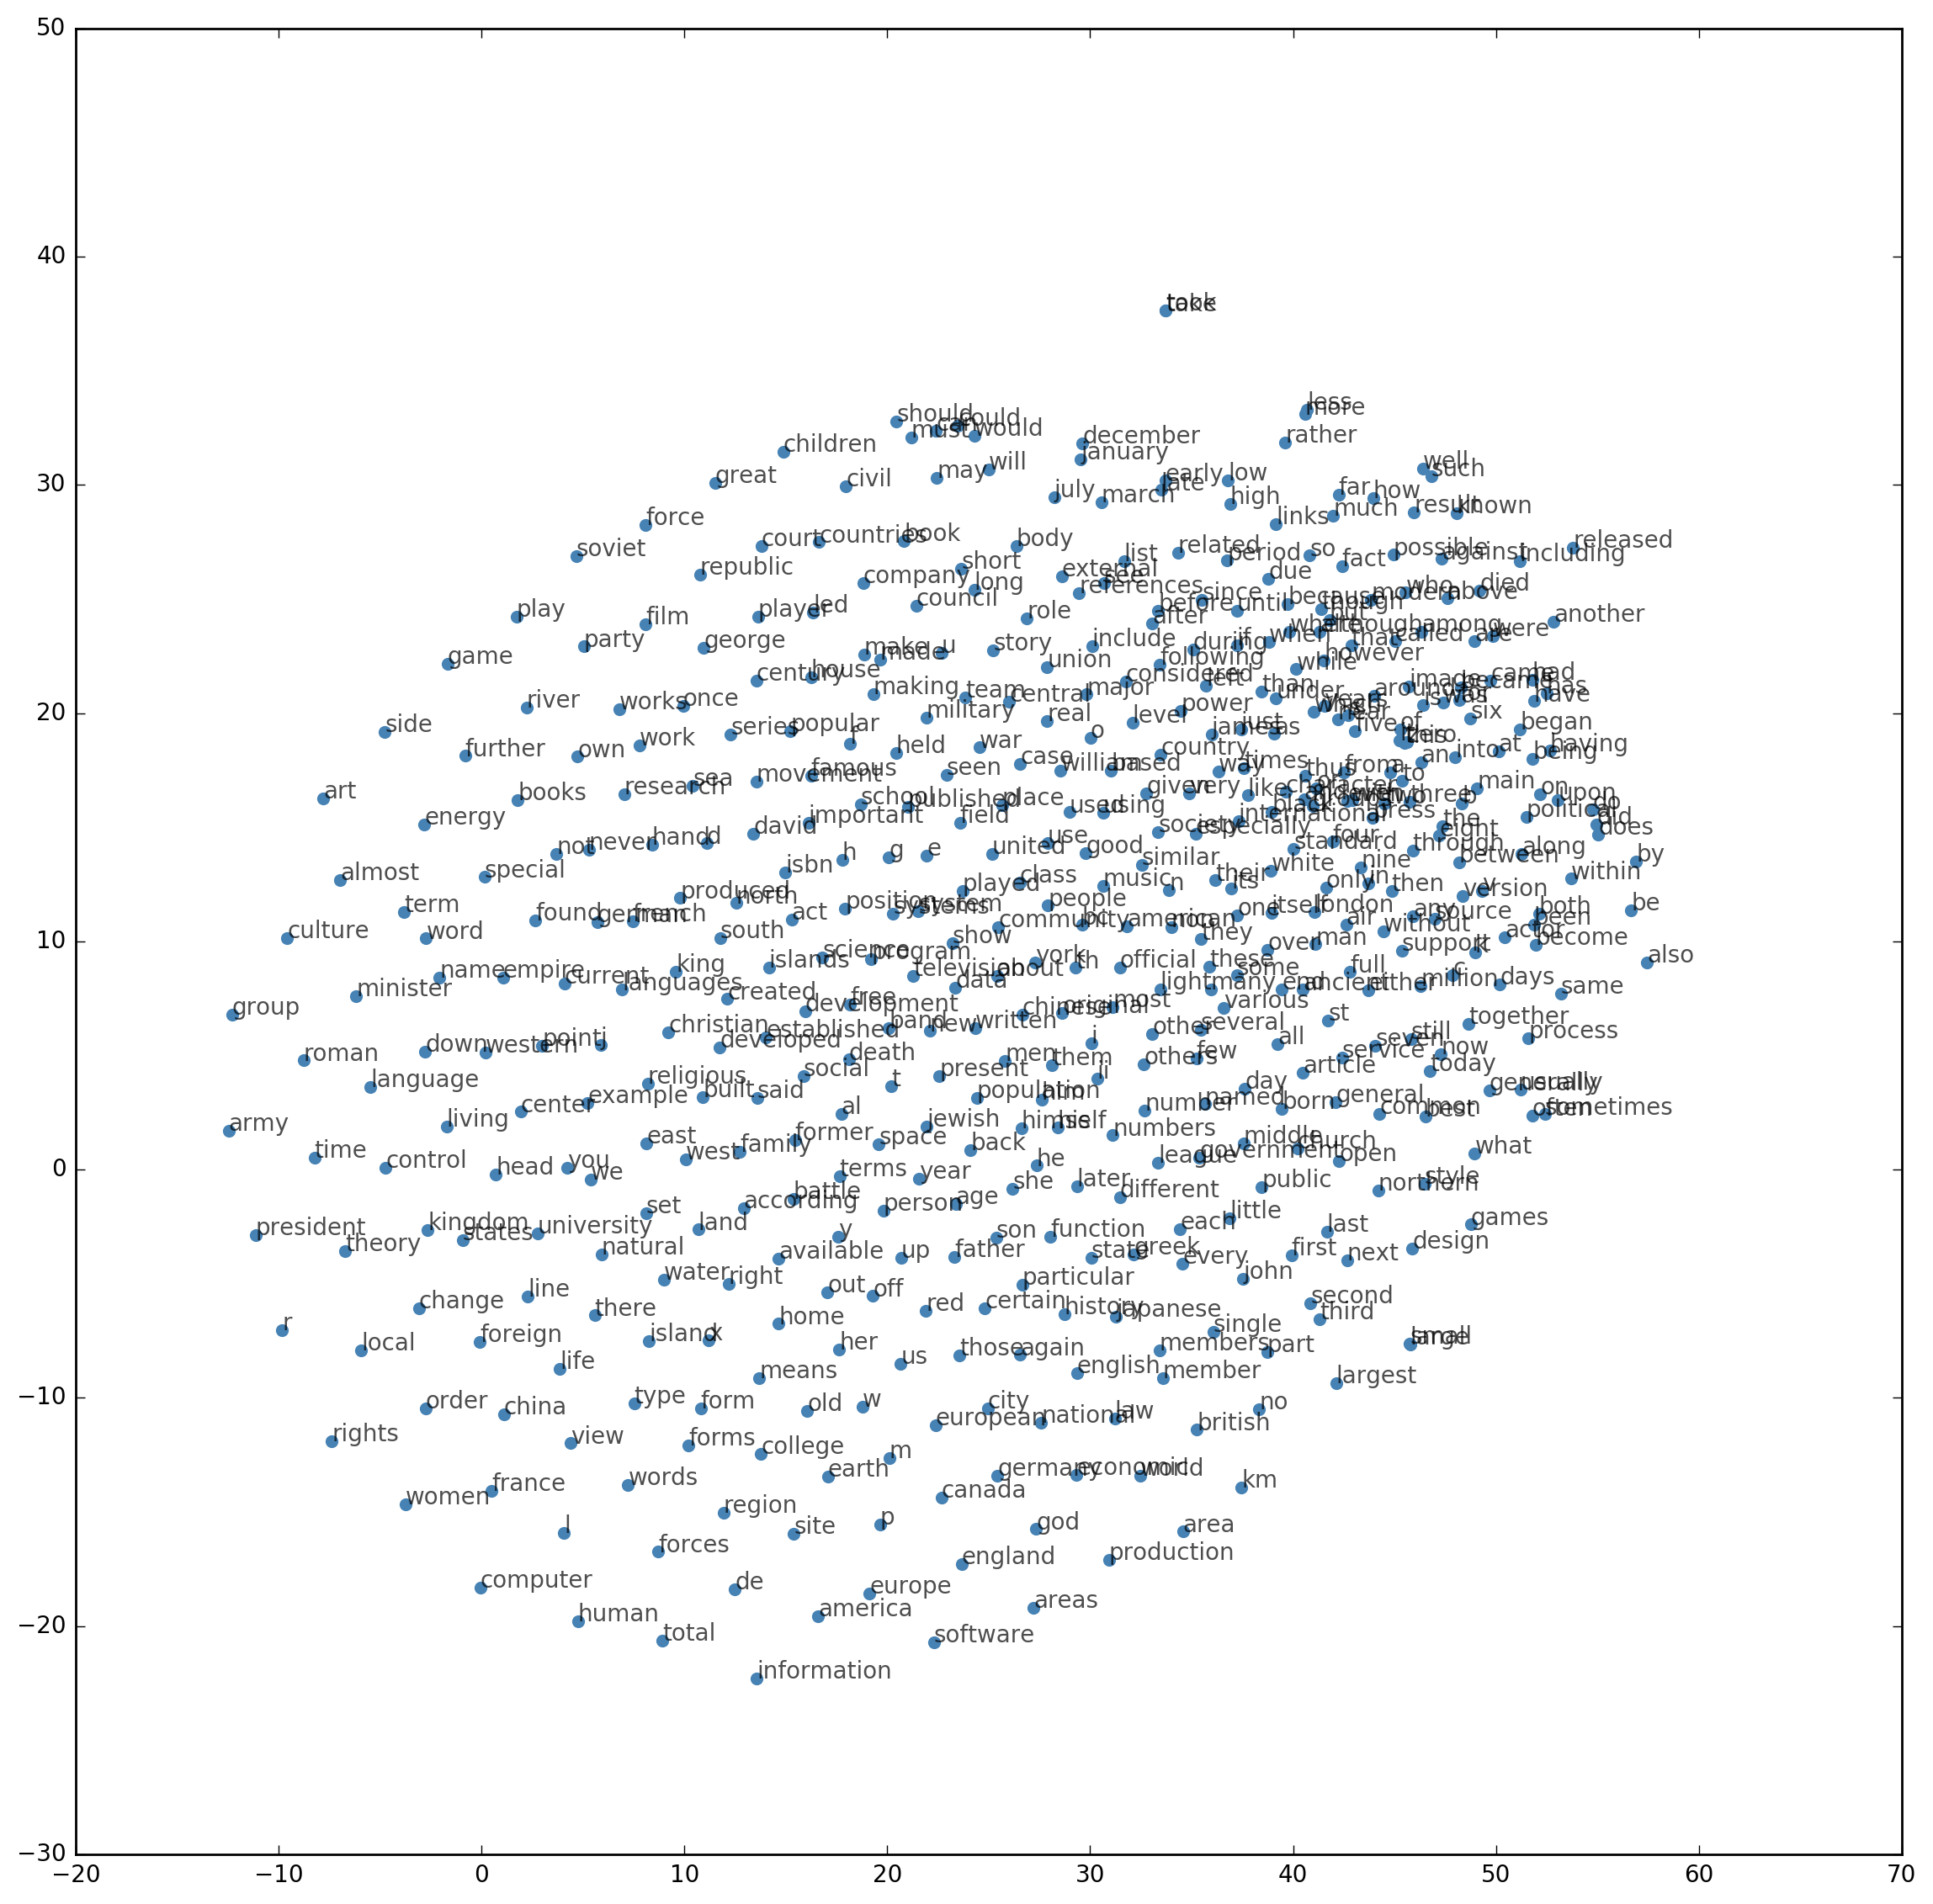

In [23]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)